In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data



def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]
n_real_stats = real_stats


#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
#lambda11 = 1
lambda12 = 0
lambda21 = 0
#lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1,
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), (None, None), (0, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None),
                       (None, None), (None, None), 
                       (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0  1.0

return_mean1                         235.938075
return_mean2                         223.945751
return_sd1                           443.113120
return_sd2                           425.421813
return_skew1                         182.161131
return_skew2                         227.916497
return_kurtosis1                     129.196190
return_kurtosis2                     175.952275
return_autocorrelation_ts1_lag1       18.001235
return_autocorrelation_ts1_lag2       17.791063
return_autocorrelation_ts1_lag3       18.372659
return_autocorrelation_ts2_lag1       17.575148
return_autocorrelation_ts2_lag2       17.489304
return_autocorrelation_ts2_lag3       17.492160
return_correlation_ts1_lag_0         168.052491
return_correlation_ts1_lag_1          17.912513
return_correlation_ts1_lag_2          16.837455
return_correlation_ts1_lag_3          19.050002
return_correlation_ts2_lag_1          18

return_mean1                         192.998072
return_mean2                         222.145355
return_sd1                           453.263765
return_sd2                           435.254095
return_skew1                         195.142012
return_skew2                         252.539531
return_kurtosis1                     144.641865
return_kurtosis2                     190.384396
return_autocorrelation_ts1_lag1       18.965108
return_autocorrelation_ts1_lag2       19.070423
return_autocorrelation_ts1_lag3       16.690371
return_autocorrelation_ts2_lag1       19.414467
return_autocorrelation_ts2_lag2       18.568196
return_autocorrelation_ts2_lag3       16.970682
return_correlation_ts1_lag_0         167.968154
return_correlation_ts1_lag_1          19.069311
return_correlation_ts1_lag_2          18.147454
return_correlation_ts1_lag_3          17.564216
return_correlation_ts2_lag_1          18.937569
return_correlation_ts2_lag_2          17.893516
return_correlation_ts2_lag_3          16

return_mean1                         192.238832
return_mean2                         222.691001
return_sd1                           454.111009
return_sd2                           436.259147
return_skew1                         198.642431
return_skew2                         242.371329
return_kurtosis1                     150.750279
return_kurtosis2                     193.972869
return_autocorrelation_ts1_lag1       19.474579
return_autocorrelation_ts1_lag2       18.906442
return_autocorrelation_ts1_lag3       18.412903
return_autocorrelation_ts2_lag1       18.421744
return_autocorrelation_ts2_lag2       18.427345
return_autocorrelation_ts2_lag3       19.499348
return_correlation_ts1_lag_0         167.959572
return_correlation_ts1_lag_1          17.653786
return_correlation_ts1_lag_2          17.751769
return_correlation_ts1_lag_3          21.432343
return_correlation_ts2_lag_1          18.163270
return_correlation_ts2_lag_2          18.305209
return_correlation_ts2_lag_3          17

return_mean1                         190.479942
return_mean2                         220.442254
return_sd1                           444.850943
return_sd2                           427.750374
return_skew1                         189.315110
return_skew2                         242.013669
return_kurtosis1                     134.473448
return_kurtosis2                     184.857569
return_autocorrelation_ts1_lag1       19.321100
return_autocorrelation_ts1_lag2       18.050626
return_autocorrelation_ts1_lag3       16.717906
return_autocorrelation_ts2_lag1       19.279567
return_autocorrelation_ts2_lag2       17.375999
return_autocorrelation_ts2_lag3       17.123655
return_correlation_ts1_lag_0         167.961230
return_correlation_ts1_lag_1          18.129912
return_correlation_ts1_lag_2          18.238864
return_correlation_ts1_lag_3          19.155417
return_correlation_ts2_lag_1          18.875706
return_correlation_ts2_lag_2          18.077354
return_correlation_ts2_lag_3          17

return_mean1                         191.896731
return_mean2                         221.562445
return_sd1                           453.715416
return_sd2                           435.892118
return_skew1                         198.871226
return_skew2                         252.082997
return_kurtosis1                     155.104663
return_kurtosis2                     201.644485
return_autocorrelation_ts1_lag1       19.780160
return_autocorrelation_ts1_lag2       19.692889
return_autocorrelation_ts1_lag3       17.909505
return_autocorrelation_ts2_lag1       19.251106
return_autocorrelation_ts2_lag2       20.039602
return_autocorrelation_ts2_lag3       18.849464
return_correlation_ts1_lag_0         167.965558
return_correlation_ts1_lag_1          18.506412
return_correlation_ts1_lag_2          17.374884
return_correlation_ts1_lag_3          18.705622
return_correlation_ts2_lag_1          18.563033
return_correlation_ts2_lag_2          18.648604
return_correlation_ts2_lag_3          17

return_mean1                          56.938325
return_mean2                         223.852271
return_sd1                           440.708758
return_sd2                           428.397761
return_skew1                         180.070943
return_skew2                         237.920323
return_kurtosis1                     128.593206
return_kurtosis2                     180.395782
return_autocorrelation_ts1_lag1       17.692486
return_autocorrelation_ts1_lag2       18.263569
return_autocorrelation_ts1_lag3       18.082054
return_autocorrelation_ts2_lag1       19.284601
return_autocorrelation_ts2_lag2       19.397331
return_autocorrelation_ts2_lag3       19.746474
return_correlation_ts1_lag_0         167.944223
return_correlation_ts1_lag_1          17.783306
return_correlation_ts1_lag_2          18.803956
return_correlation_ts1_lag_3          18.522583
return_correlation_ts2_lag_1          18.740882
return_correlation_ts2_lag_2          17.439545
return_correlation_ts2_lag_3          18

return_mean1                          55.505514
return_mean2                         225.176195
return_sd1                           445.533531
return_sd2                           431.667649
return_skew1                         188.171856
return_skew2                         232.893824
return_kurtosis1                     133.839436
return_kurtosis2                     182.140620
return_autocorrelation_ts1_lag1       18.375145
return_autocorrelation_ts1_lag2       18.696432
return_autocorrelation_ts1_lag3       18.296837
return_autocorrelation_ts2_lag1       18.508790
return_autocorrelation_ts2_lag2       16.813172
return_autocorrelation_ts2_lag3       19.040184
return_correlation_ts1_lag_0         167.924685
return_correlation_ts1_lag_1          18.482764
return_correlation_ts1_lag_2          17.855704
return_correlation_ts1_lag_3          19.148383
return_correlation_ts2_lag_1          18.821081
return_correlation_ts2_lag_2          18.073044
return_correlation_ts2_lag_3          18

return_mean1                          55.311570
return_mean2                         221.930815
return_sd1                           443.896668
return_sd2                           429.567646
return_skew1                         194.172484
return_skew2                         241.479594
return_kurtosis1                     134.581670
return_kurtosis2                     183.861270
return_autocorrelation_ts1_lag1       19.485233
return_autocorrelation_ts1_lag2       18.659073
return_autocorrelation_ts1_lag3       18.138410
return_autocorrelation_ts2_lag1       19.788918
return_autocorrelation_ts2_lag2       19.697187
return_autocorrelation_ts2_lag3       18.847628
return_correlation_ts1_lag_0         167.943016
return_correlation_ts1_lag_1          18.346787
return_correlation_ts1_lag_2          18.279364
return_correlation_ts1_lag_3          18.535876
return_correlation_ts2_lag_1          20.273719
return_correlation_ts2_lag_2          18.507097
return_correlation_ts2_lag_3          18

return_mean1                          54.503044
return_mean2                         218.495629
return_sd1                           446.445833
return_sd2                           433.862325
return_skew1                         192.117731
return_skew2                         249.172416
return_kurtosis1                     129.293036
return_kurtosis2                     189.395694
return_autocorrelation_ts1_lag1       17.828770
return_autocorrelation_ts1_lag2       18.251557
return_autocorrelation_ts1_lag3       18.612265
return_autocorrelation_ts2_lag1       19.315046
return_autocorrelation_ts2_lag2       19.061634
return_autocorrelation_ts2_lag3       18.646537
return_correlation_ts1_lag_0         167.917960
return_correlation_ts1_lag_1          16.833310
return_correlation_ts1_lag_2          18.416214
return_correlation_ts1_lag_3          19.141375
return_correlation_ts2_lag_1          19.151864
return_correlation_ts2_lag_2          18.607453
return_correlation_ts2_lag_3          18

return_mean1                          50.878623
return_mean2                         196.115733
return_sd1                           441.067457
return_sd2                           428.693996
return_skew1                         182.746326
return_skew2                         238.952130
return_kurtosis1                     119.936547
return_kurtosis2                     183.320675
return_autocorrelation_ts1_lag1       19.847361
return_autocorrelation_ts1_lag2       17.807183
return_autocorrelation_ts1_lag3       17.701512
return_autocorrelation_ts2_lag1       18.157115
return_autocorrelation_ts2_lag2       18.684018
return_autocorrelation_ts2_lag3       16.940354
return_correlation_ts1_lag_0         167.808665
return_correlation_ts1_lag_1          18.520919
return_correlation_ts1_lag_2          18.227769
return_correlation_ts1_lag_3          18.013442
return_correlation_ts2_lag_1          19.302696
return_correlation_ts2_lag_2          17.689228
return_correlation_ts2_lag_3          17

return_mean1                          54.713538
return_mean2                         194.098649
return_sd1                           444.295379
return_sd2                           432.906266
return_skew1                         194.625239
return_skew2                         240.440163
return_kurtosis1                     135.690939
return_kurtosis2                     186.260843
return_autocorrelation_ts1_lag1       19.443293
return_autocorrelation_ts1_lag2       18.910136
return_autocorrelation_ts1_lag3       18.471184
return_autocorrelation_ts2_lag1       17.973473
return_autocorrelation_ts2_lag2       18.284331
return_autocorrelation_ts2_lag3       17.722318
return_correlation_ts1_lag_0         167.775281
return_correlation_ts1_lag_1          18.990769
return_correlation_ts1_lag_2          17.575368
return_correlation_ts1_lag_3          19.686996
return_correlation_ts2_lag_1          19.617026
return_correlation_ts2_lag_2          18.001284
return_correlation_ts2_lag_3          17

return_mean1                          52.650200
return_mean2                         193.238483
return_sd1                           444.192713
return_sd2                           431.641882
return_skew1                         204.762469
return_skew2                         253.036095
return_kurtosis1                     133.921676
return_kurtosis2                     179.855336
return_autocorrelation_ts1_lag1       19.785191
return_autocorrelation_ts1_lag2       18.869483
return_autocorrelation_ts1_lag3       18.151436
return_autocorrelation_ts2_lag1       18.937769
return_autocorrelation_ts2_lag2       19.576604
return_autocorrelation_ts2_lag3       19.060678
return_correlation_ts1_lag_0         167.779376
return_correlation_ts1_lag_1          18.876465
return_correlation_ts1_lag_2          18.322475
return_correlation_ts1_lag_3          18.603926
return_correlation_ts2_lag_1          20.437233
return_correlation_ts2_lag_2          18.263540
return_correlation_ts2_lag_3          18

return_mean1                          47.604703
return_mean2                         190.570620
return_sd1                           442.409226
return_sd2                           432.117119
return_skew1                         186.124143
return_skew2                         231.721336
return_kurtosis1                     123.108184
return_kurtosis2                     175.397074
return_autocorrelation_ts1_lag1       17.228749
return_autocorrelation_ts1_lag2       18.767700
return_autocorrelation_ts1_lag3       18.400072
return_autocorrelation_ts2_lag1       17.343695
return_autocorrelation_ts2_lag2       18.746104
return_autocorrelation_ts2_lag3       17.925596
return_correlation_ts1_lag_0         167.785562
return_correlation_ts1_lag_1          17.374046
return_correlation_ts1_lag_2          18.234811
return_correlation_ts1_lag_3          18.924933
return_correlation_ts2_lag_1          17.773268
return_correlation_ts2_lag_2          18.155762
return_correlation_ts2_lag_3          17

return_mean1                          56.441106
return_mean2                         198.454120
return_sd1                           443.118873
return_sd2                           430.889450
return_skew1                         183.965241
return_skew2                         243.459710
return_kurtosis1                     131.276037
return_kurtosis2                     178.587505
return_autocorrelation_ts1_lag1       16.653805
return_autocorrelation_ts1_lag2       18.245326
return_autocorrelation_ts1_lag3       18.087425
return_autocorrelation_ts2_lag1       17.262352
return_autocorrelation_ts2_lag2       17.387406
return_autocorrelation_ts2_lag3       18.006258
return_correlation_ts1_lag_0         167.769596
return_correlation_ts1_lag_1          17.841212
return_correlation_ts1_lag_2          16.889500
return_correlation_ts1_lag_3          18.240972
return_correlation_ts2_lag_1          18.077304
return_correlation_ts2_lag_2          17.589736
return_correlation_ts2_lag_3          17

return_mean1                          53.878094
return_mean2                         308.805409
return_sd1                           437.077127
return_sd2                           451.142674
return_skew1                         189.583052
return_skew2                         233.885312
return_kurtosis1                     138.971983
return_kurtosis2                     182.988552
return_autocorrelation_ts1_lag1       18.459597
return_autocorrelation_ts1_lag2       17.711386
return_autocorrelation_ts1_lag3       18.349169
return_autocorrelation_ts2_lag1       23.195787
return_autocorrelation_ts2_lag2       23.572343
return_autocorrelation_ts2_lag3       22.638633
return_correlation_ts1_lag_0         163.791365
return_correlation_ts1_lag_1          18.103211
return_correlation_ts1_lag_2          18.222866
return_correlation_ts1_lag_3          19.471964
return_correlation_ts2_lag_1          18.779695
return_correlation_ts2_lag_2          16.687390
return_correlation_ts2_lag_3          18

return_mean1                          54.613220
return_mean2                          61.533701
return_sd1                           444.459651
return_sd2                           428.052346
return_skew1                         192.495106
return_skew2                         233.765110
return_kurtosis1                     140.074079
return_kurtosis2                     173.954665
return_autocorrelation_ts1_lag1       17.320358
return_autocorrelation_ts1_lag2       19.284071
return_autocorrelation_ts1_lag3       20.767374
return_autocorrelation_ts2_lag1       18.028912
return_autocorrelation_ts2_lag2       16.555550
return_autocorrelation_ts2_lag3       18.916726
return_correlation_ts1_lag_0         168.100236
return_correlation_ts1_lag_1          18.217336
return_correlation_ts1_lag_2          17.510823
return_correlation_ts1_lag_3          21.388387
return_correlation_ts2_lag_1          18.753376
return_correlation_ts2_lag_2          17.257784
return_correlation_ts2_lag_3          19

return_mean1                          56.254744
return_mean2                          46.434386
return_sd1                           442.138848
return_sd2                           424.710389
return_skew1                         188.485009
return_skew2                         243.812338
return_kurtosis1                     134.688213
return_kurtosis2                     186.493729
return_autocorrelation_ts1_lag1       19.171929
return_autocorrelation_ts1_lag2       19.047374
return_autocorrelation_ts1_lag3       19.239057
return_autocorrelation_ts2_lag1       18.161833
return_autocorrelation_ts2_lag2       18.641841
return_autocorrelation_ts2_lag3       19.682934
return_correlation_ts1_lag_0         168.079433
return_correlation_ts1_lag_1          18.240933
return_correlation_ts1_lag_2          17.768280
return_correlation_ts1_lag_3          19.136078
return_correlation_ts2_lag_1          18.546096
return_correlation_ts2_lag_2          17.837211
return_correlation_ts2_lag_3          19

return_mean1                          48.772605
return_mean2                          44.520982
return_sd1                           444.201869
return_sd2                           426.848524
return_skew1                         177.603200
return_skew2                         231.735747
return_kurtosis1                     127.472827
return_kurtosis2                     175.897254
return_autocorrelation_ts1_lag1       19.164034
return_autocorrelation_ts1_lag2       18.888839
return_autocorrelation_ts1_lag3       18.852320
return_autocorrelation_ts2_lag1       18.824903
return_autocorrelation_ts2_lag2       19.167896
return_autocorrelation_ts2_lag3       18.792937
return_correlation_ts1_lag_0         168.080231
return_correlation_ts1_lag_1          17.907271
return_correlation_ts1_lag_2          18.404199
return_correlation_ts1_lag_3          20.169327
return_correlation_ts2_lag_1          18.821702
return_correlation_ts2_lag_2          20.113248
return_correlation_ts2_lag_3          17

return_mean1                          54.444862
return_mean2                          48.841963
return_sd1                           437.015056
return_sd2                           420.526804
return_skew1                         182.207021
return_skew2                         225.459968
return_kurtosis1                     128.012913
return_kurtosis2                     174.540279
return_autocorrelation_ts1_lag1       20.442141
return_autocorrelation_ts1_lag2       18.155281
return_autocorrelation_ts1_lag3       18.938605
return_autocorrelation_ts2_lag1       18.554995
return_autocorrelation_ts2_lag2       17.938997
return_autocorrelation_ts2_lag3       18.357017
return_correlation_ts1_lag_0         168.078060
return_correlation_ts1_lag_1          18.403962
return_correlation_ts1_lag_2          17.449844
return_correlation_ts1_lag_3          20.161302
return_correlation_ts2_lag_1          19.966677
return_correlation_ts2_lag_2          17.200918
return_correlation_ts2_lag_3          18

return_mean1                          49.634071
return_mean2                          48.535654
return_sd1                           225.910348
return_sd2                           424.502107
return_skew1                         230.611773
return_skew2                         245.966511
return_kurtosis1                     162.853823
return_kurtosis2                     181.731023
return_autocorrelation_ts1_lag1       18.622502
return_autocorrelation_ts1_lag2       19.275653
return_autocorrelation_ts1_lag3       17.881657
return_autocorrelation_ts2_lag1       17.345234
return_autocorrelation_ts2_lag2       18.710146
return_autocorrelation_ts2_lag3       18.674098
return_correlation_ts1_lag_0         101.498071
return_correlation_ts1_lag_1          17.872114
return_correlation_ts1_lag_2          18.221760
return_correlation_ts1_lag_3          18.309623
return_correlation_ts2_lag_1          19.373076
return_correlation_ts2_lag_2          17.747499
return_correlation_ts2_lag_3          18

return_mean1                          48.337671
return_mean2                          47.286225
return_sd1                           224.119593
return_sd2                           419.984538
return_skew1                         221.971296
return_skew2                         236.980713
return_kurtosis1                     161.975616
return_kurtosis2                     180.646847
return_autocorrelation_ts1_lag1       18.099222
return_autocorrelation_ts1_lag2       19.187355
return_autocorrelation_ts1_lag3       18.812144
return_autocorrelation_ts2_lag1       18.820074
return_autocorrelation_ts2_lag2       18.418784
return_autocorrelation_ts2_lag3       19.158187
return_correlation_ts1_lag_0         109.177561
return_correlation_ts1_lag_1          18.601928
return_correlation_ts1_lag_2          18.732467
return_correlation_ts1_lag_3          19.509104
return_correlation_ts2_lag_1          18.591726
return_correlation_ts2_lag_2          19.217521
return_correlation_ts2_lag_3          17

return_mean1                          49.569580
return_mean2                          53.018106
return_sd1                           228.667221
return_sd2                           426.120117
return_skew1                         231.993133
return_skew2                         252.156789
return_kurtosis1                     159.958495
return_kurtosis2                     190.527534
return_autocorrelation_ts1_lag1       17.804188
return_autocorrelation_ts1_lag2       19.126916
return_autocorrelation_ts1_lag3       17.558561
return_autocorrelation_ts2_lag1       18.217595
return_autocorrelation_ts2_lag2       17.362904
return_autocorrelation_ts2_lag3       18.732145
return_correlation_ts1_lag_0         107.532584
return_correlation_ts1_lag_1          18.171379
return_correlation_ts1_lag_2          17.258618
return_correlation_ts1_lag_3          18.773188
return_correlation_ts2_lag_1          18.704123
return_correlation_ts2_lag_2          18.963715
return_correlation_ts2_lag_3          18

return_mean1                          48.753600
return_mean2                          46.029601
return_sd1                           218.474617
return_sd2                           421.846051
return_skew1                         199.064619
return_skew2                         232.977064
return_kurtosis1                     134.421124
return_kurtosis2                     174.490082
return_autocorrelation_ts1_lag1       18.556718
return_autocorrelation_ts1_lag2       20.100270
return_autocorrelation_ts1_lag3       19.273036
return_autocorrelation_ts2_lag1       17.881890
return_autocorrelation_ts2_lag2       18.431251
return_autocorrelation_ts2_lag3       17.537645
return_correlation_ts1_lag_0         107.220963
return_correlation_ts1_lag_1          17.012486
return_correlation_ts1_lag_2          18.823794
return_correlation_ts1_lag_3          18.004498
return_correlation_ts2_lag_1          20.355800
return_correlation_ts2_lag_2          18.432652
return_correlation_ts2_lag_3          16

return_mean1                           75.150229
return_mean2                           46.049601
return_sd1                           1182.859068
return_sd2                            431.044919
return_skew1                          169.768416
return_skew2                          242.697027
return_kurtosis1                      126.523285
return_kurtosis2                      180.216363
return_autocorrelation_ts1_lag1        18.290126
return_autocorrelation_ts1_lag2        19.054542
return_autocorrelation_ts1_lag3        17.481052
return_autocorrelation_ts2_lag1        18.458258
return_autocorrelation_ts2_lag2        19.180125
return_autocorrelation_ts2_lag3        17.337995
return_correlation_ts1_lag_0          101.244045
return_correlation_ts1_lag_1           18.418227
return_correlation_ts1_lag_2           17.583091
return_correlation_ts1_lag_3           18.453019
return_correlation_ts2_lag_1           19.162474
return_correlation_ts2_lag_2           18.816589
return_correlation_t

return_mean1                          49.148594
return_mean2                          44.438274
return_sd1                           223.614257
return_sd2                           428.949977
return_skew1                         243.103907
return_skew2                         245.583439
return_kurtosis1                     160.375002
return_kurtosis2                     177.592436
return_autocorrelation_ts1_lag1       19.533926
return_autocorrelation_ts1_lag2       19.795985
return_autocorrelation_ts1_lag3       17.658511
return_autocorrelation_ts2_lag1       18.501853
return_autocorrelation_ts2_lag2       18.348371
return_autocorrelation_ts2_lag3       18.425369
return_correlation_ts1_lag_0         108.738642
return_correlation_ts1_lag_1          18.110436
return_correlation_ts1_lag_2          18.929229
return_correlation_ts1_lag_3          19.071539
return_correlation_ts2_lag_1          20.141726
return_correlation_ts2_lag_2          17.083959
return_correlation_ts2_lag_3          17

return_mean1                          48.403923
return_mean2                          44.902827
return_sd1                           168.277221
return_sd2                           421.609336
return_skew1                         254.059856
return_skew2                         238.882445
return_kurtosis1                     193.691632
return_kurtosis2                     182.371366
return_autocorrelation_ts1_lag1       17.677141
return_autocorrelation_ts1_lag2       19.902067
return_autocorrelation_ts1_lag3       18.788855
return_autocorrelation_ts2_lag1       17.867588
return_autocorrelation_ts2_lag2       17.650213
return_autocorrelation_ts2_lag3       17.491549
return_correlation_ts1_lag_0         108.075268
return_correlation_ts1_lag_1          18.507998
return_correlation_ts1_lag_2          18.734058
return_correlation_ts1_lag_3          19.532995
return_correlation_ts2_lag_1          17.013661
return_correlation_ts2_lag_2          18.396458
return_correlation_ts2_lag_3          16

return_mean1                          48.611432
return_mean2                          47.083826
return_sd1                           170.644843
return_sd2                           430.287758
return_skew1                         255.549374
return_skew2                         247.535693
return_kurtosis1                     189.647113
return_kurtosis2                     188.512559
return_autocorrelation_ts1_lag1       19.326319
return_autocorrelation_ts1_lag2       19.652599
return_autocorrelation_ts1_lag3       17.379423
return_autocorrelation_ts2_lag1       18.479783
return_autocorrelation_ts2_lag2       17.997893
return_autocorrelation_ts2_lag3       17.101372
return_correlation_ts1_lag_0         109.006108
return_correlation_ts1_lag_1          18.982577
return_correlation_ts1_lag_2          19.184358
return_correlation_ts1_lag_3          19.015307
return_correlation_ts2_lag_1          18.925898
return_correlation_ts2_lag_2          18.462661
return_correlation_ts2_lag_3          17

return_mean1                          48.105680
return_mean2                          45.760385
return_sd1                           166.554665
return_sd2                           425.289397
return_skew1                         252.056169
return_skew2                         248.365959
return_kurtosis1                     177.194606
return_kurtosis2                     186.613528
return_autocorrelation_ts1_lag1       19.659198
return_autocorrelation_ts1_lag2       18.650383
return_autocorrelation_ts1_lag3       18.698304
return_autocorrelation_ts2_lag1       18.459109
return_autocorrelation_ts2_lag2       17.446951
return_autocorrelation_ts2_lag3       19.155329
return_correlation_ts1_lag_0         108.722701
return_correlation_ts1_lag_1          18.429345
return_correlation_ts1_lag_2          17.690255
return_correlation_ts1_lag_3          19.293975
return_correlation_ts2_lag_1          19.636849
return_correlation_ts2_lag_2          17.059820
return_correlation_ts2_lag_3          17

return_mean1                          45.977800
return_mean2                          43.598277
return_sd1                           171.613168
return_sd2                           251.511976
return_skew1                         271.809330
return_skew2                         284.672207
return_kurtosis1                     214.053741
return_kurtosis2                     217.630585
return_autocorrelation_ts1_lag1       19.316398
return_autocorrelation_ts1_lag2       19.109016
return_autocorrelation_ts1_lag3       17.528422
return_autocorrelation_ts2_lag1       18.664589
return_autocorrelation_ts2_lag2       18.253639
return_autocorrelation_ts2_lag3       18.168161
return_correlation_ts1_lag_0         157.541642
return_correlation_ts1_lag_1          18.798240
return_correlation_ts1_lag_2          17.540899
return_correlation_ts1_lag_3          19.898254
return_correlation_ts2_lag_1          18.920522
return_correlation_ts2_lag_2          18.483536
return_correlation_ts2_lag_3          16

return_mean1                          47.148983
return_mean2                          45.618112
return_sd1                           171.984403
return_sd2                           284.573107
return_skew1                         255.334051
return_skew2                         266.810197
return_kurtosis1                     198.605868
return_kurtosis2                     195.926905
return_autocorrelation_ts1_lag1       19.494033
return_autocorrelation_ts1_lag2       19.438778
return_autocorrelation_ts1_lag3       16.965619
return_autocorrelation_ts2_lag1       16.970167
return_autocorrelation_ts2_lag2       18.646532
return_autocorrelation_ts2_lag3       18.020231
return_correlation_ts1_lag_0         145.047220
return_correlation_ts1_lag_1          17.355048
return_correlation_ts1_lag_2          18.217034
return_correlation_ts1_lag_3          17.759280
return_correlation_ts2_lag_1          18.873252
return_correlation_ts2_lag_2          19.279649
return_correlation_ts2_lag_3          17

return_mean1                          45.634310
return_mean2                          40.747851
return_sd1                           163.974402
return_sd2                           282.777534
return_skew1                         264.024007
return_skew2                         271.594496
return_kurtosis1                     196.217032
return_kurtosis2                     197.318327
return_autocorrelation_ts1_lag1       19.014524
return_autocorrelation_ts1_lag2       18.675844
return_autocorrelation_ts1_lag3       18.586368
return_autocorrelation_ts2_lag1       18.731027
return_autocorrelation_ts2_lag2       18.816902
return_autocorrelation_ts2_lag3       17.204082
return_correlation_ts1_lag_0         143.854041
return_correlation_ts1_lag_1          17.601426
return_correlation_ts1_lag_2          17.599566
return_correlation_ts1_lag_3          17.609596
return_correlation_ts2_lag_1          19.262671
return_correlation_ts2_lag_2          18.454131
return_correlation_ts2_lag_3          18

return_mean1                          49.518570
return_mean2                          39.916506
return_sd1                           160.911728
return_sd2                           279.867304
return_skew1                         243.433964
return_skew2                         252.980116
return_kurtosis1                     178.883920
return_kurtosis2                     187.267110
return_autocorrelation_ts1_lag1       20.049450
return_autocorrelation_ts1_lag2       19.640791
return_autocorrelation_ts1_lag3       19.244687
return_autocorrelation_ts2_lag1       17.390148
return_autocorrelation_ts2_lag2       17.803635
return_autocorrelation_ts2_lag3       18.875821
return_correlation_ts1_lag_0         144.033008
return_correlation_ts1_lag_1          18.210850
return_correlation_ts1_lag_2          17.542949
return_correlation_ts1_lag_3          19.140058
return_correlation_ts2_lag_1          18.558781
return_correlation_ts2_lag_2          18.777845
return_correlation_ts2_lag_3          18

return_mean1                          48.425699
return_mean2                          35.533087
return_sd1                           157.679595
return_sd2                           107.663671
return_skew1                         234.538090
return_skew2                         375.638458
return_kurtosis1                     149.639107
return_kurtosis2                     277.313831
return_autocorrelation_ts1_lag1       18.241176
return_autocorrelation_ts1_lag2       19.273409
return_autocorrelation_ts1_lag3       17.373473
return_autocorrelation_ts2_lag1       18.604954
return_autocorrelation_ts2_lag2       18.537366
return_autocorrelation_ts2_lag3       17.827081
return_correlation_ts1_lag_0          48.156776
return_correlation_ts1_lag_1          18.885873
return_correlation_ts1_lag_2          17.472513
return_correlation_ts1_lag_3          19.278553
return_correlation_ts2_lag_1          20.332594
return_correlation_ts2_lag_2          19.389137
return_correlation_ts2_lag_3          18

return_mean1                          45.430176
return_mean2                          33.498008
return_sd1                           162.355941
return_sd2                           109.199471
return_skew1                         247.166097
return_skew2                         414.064059
return_kurtosis1                     157.300675
return_kurtosis2                     315.431414
return_autocorrelation_ts1_lag1       18.651125
return_autocorrelation_ts1_lag2       19.946819
return_autocorrelation_ts1_lag3       16.948992
return_autocorrelation_ts2_lag1       18.936196
return_autocorrelation_ts2_lag2       18.858978
return_autocorrelation_ts2_lag3       18.431313
return_correlation_ts1_lag_0          44.802956
return_correlation_ts1_lag_1          19.495007
return_correlation_ts1_lag_2          18.344441
return_correlation_ts1_lag_3          17.451404
return_correlation_ts2_lag_1          19.453323
return_correlation_ts2_lag_2          19.521872
return_correlation_ts2_lag_3          17

return_mean1                          45.112949
return_mean2                          33.604415
return_sd1                           172.094729
return_sd2                           114.356028
return_skew1                         296.415966
return_skew2                         473.553933
return_kurtosis1                     218.017381
return_kurtosis2                     399.233975
return_autocorrelation_ts1_lag1       19.487756
return_autocorrelation_ts1_lag2       18.150303
return_autocorrelation_ts1_lag3       17.107753
return_autocorrelation_ts2_lag1       19.449123
return_autocorrelation_ts2_lag2       18.363921
return_autocorrelation_ts2_lag3       19.772207
return_correlation_ts1_lag_0          43.865799
return_correlation_ts1_lag_1          18.618258
return_correlation_ts1_lag_2          17.530700
return_correlation_ts1_lag_3          18.883046
return_correlation_ts2_lag_1          19.223981
return_correlation_ts2_lag_2          20.621240
return_correlation_ts2_lag_3          18

return_mean1                          48.938510
return_mean2                          33.396276
return_sd1                           166.858877
return_sd2                           112.902512
return_skew1                         275.095904
return_skew2                         444.903670
return_kurtosis1                     217.231266
return_kurtosis2                     364.925966
return_autocorrelation_ts1_lag1       17.911750
return_autocorrelation_ts1_lag2       19.969588
return_autocorrelation_ts1_lag3       17.512187
return_autocorrelation_ts2_lag1       18.032283
return_autocorrelation_ts2_lag2       17.928666
return_autocorrelation_ts2_lag3       17.395121
return_correlation_ts1_lag_0          41.552011
return_correlation_ts1_lag_1          17.565346
return_correlation_ts1_lag_2          18.178991
return_correlation_ts1_lag_3          19.545457
return_correlation_ts2_lag_1          20.746991
return_correlation_ts2_lag_2          20.186677
return_correlation_ts2_lag_3          17

return_mean1                          49.073803
return_mean2                          32.993855
return_sd1                           169.127146
return_sd2                           115.688594
return_skew1                         280.111725
return_skew2                         429.381562
return_kurtosis1                     190.600310
return_kurtosis2                     329.986206
return_autocorrelation_ts1_lag1       18.181861
return_autocorrelation_ts1_lag2       18.488164
return_autocorrelation_ts1_lag3       19.018374
return_autocorrelation_ts2_lag1       18.633873
return_autocorrelation_ts2_lag2       18.409544
return_autocorrelation_ts2_lag3       17.495434
return_correlation_ts1_lag_0          42.109411
return_correlation_ts1_lag_1          18.614888
return_correlation_ts1_lag_2          17.441770
return_correlation_ts1_lag_3          19.336046
return_correlation_ts2_lag_1          18.142589
return_correlation_ts2_lag_2          19.527957
return_correlation_ts2_lag_3          18

return_mean1                          46.365441
return_mean2                          33.397422
return_sd1                           449.749498
return_sd2                           119.409851
return_skew1                         809.842208
return_skew2                         430.499366
return_kurtosis1                     892.215361
return_kurtosis2                     342.922406
return_autocorrelation_ts1_lag1       17.490102
return_autocorrelation_ts1_lag2       17.514929
return_autocorrelation_ts1_lag3       16.668209
return_autocorrelation_ts2_lag1       18.472365
return_autocorrelation_ts2_lag2       18.342264
return_autocorrelation_ts2_lag3       18.124933
return_correlation_ts1_lag_0          48.096214
return_correlation_ts1_lag_1          18.632576
return_correlation_ts1_lag_2          18.684874
return_correlation_ts1_lag_3          18.331963
return_correlation_ts2_lag_1          18.741468
return_correlation_ts2_lag_2          18.259976
return_correlation_ts2_lag_3          17

return_mean1                          50.833908
return_mean2                          31.602688
return_sd1                           148.009119
return_sd2                           114.335474
return_skew1                         191.512604
return_skew2                         409.012483
return_kurtosis1                     135.578749
return_kurtosis2                     311.521804
return_autocorrelation_ts1_lag1       19.322535
return_autocorrelation_ts1_lag2       18.399051
return_autocorrelation_ts1_lag3       18.140862
return_autocorrelation_ts2_lag1       17.741934
return_autocorrelation_ts2_lag2       18.939516
return_autocorrelation_ts2_lag3       18.372250
return_correlation_ts1_lag_0          41.751829
return_correlation_ts1_lag_1          16.985922
return_correlation_ts1_lag_2          19.470989
return_correlation_ts1_lag_3          19.643745
return_correlation_ts2_lag_1          19.726412
return_correlation_ts2_lag_2          18.651477
return_correlation_ts2_lag_3          18

return_mean1                          47.660513
return_mean2                          33.762382
return_sd1                           152.261362
return_sd2                           116.405069
return_skew1                         232.568379
return_skew2                         445.624916
return_kurtosis1                     173.020441
return_kurtosis2                     398.083309
return_autocorrelation_ts1_lag1       19.415461
return_autocorrelation_ts1_lag2       18.738295
return_autocorrelation_ts1_lag3       18.747869
return_autocorrelation_ts2_lag1       19.219606
return_autocorrelation_ts2_lag2       19.571333
return_autocorrelation_ts2_lag3       19.491759
return_correlation_ts1_lag_0          42.962431
return_correlation_ts1_lag_1          18.502989
return_correlation_ts1_lag_2          17.933502
return_correlation_ts1_lag_3          18.290207
return_correlation_ts2_lag_1          18.793778
return_correlation_ts2_lag_2          18.711673
return_correlation_ts2_lag_3          18

return_mean1                          51.503867
return_mean2                          33.598170
return_sd1                           148.348951
return_sd2                           111.473775
return_skew1                         184.981162
return_skew2                         394.400978
return_kurtosis1                     137.326217
return_kurtosis2                     317.787868
return_autocorrelation_ts1_lag1       19.011408
return_autocorrelation_ts1_lag2       19.988365
return_autocorrelation_ts1_lag3       18.104557
return_autocorrelation_ts2_lag1       17.460482
return_autocorrelation_ts2_lag2       18.698453
return_autocorrelation_ts2_lag3       17.797071
return_correlation_ts1_lag_0          41.379540
return_correlation_ts1_lag_1          18.299573
return_correlation_ts1_lag_2          19.511203
return_correlation_ts1_lag_3          19.606908
return_correlation_ts2_lag_1          17.916216
return_correlation_ts2_lag_2          19.424267
return_correlation_ts2_lag_3          18

return_mean1                          49.556495
return_mean2                          33.518539
return_sd1                           146.344256
return_sd2                           112.568710
return_skew1                         208.830705
return_skew2                         418.551414
return_kurtosis1                     145.328839
return_kurtosis2                     342.445079
return_autocorrelation_ts1_lag1       18.796572
return_autocorrelation_ts1_lag2       19.801760
return_autocorrelation_ts1_lag3       17.790202
return_autocorrelation_ts2_lag1       19.073226
return_autocorrelation_ts2_lag2       18.211536
return_autocorrelation_ts2_lag3       18.553419
return_correlation_ts1_lag_0          40.328169
return_correlation_ts1_lag_1          16.526839
return_correlation_ts1_lag_2          20.065992
return_correlation_ts1_lag_3          18.755183
return_correlation_ts2_lag_1          20.609491
return_correlation_ts2_lag_2          18.788295
return_correlation_ts2_lag_3          18

return_mean1                          52.139925
return_mean2                          32.203478
return_sd1                           134.945327
return_sd2                           115.756873
return_skew1                         168.069079
return_skew2                         398.726487
return_kurtosis1                     124.913177
return_kurtosis2                     325.366720
return_autocorrelation_ts1_lag1       19.868258
return_autocorrelation_ts1_lag2       19.891467
return_autocorrelation_ts1_lag3       18.881637
return_autocorrelation_ts2_lag1       17.771484
return_autocorrelation_ts2_lag2       18.680333
return_autocorrelation_ts2_lag3       18.440970
return_correlation_ts1_lag_0          43.678779
return_correlation_ts1_lag_1          18.035788
return_correlation_ts1_lag_2          18.531953
return_correlation_ts1_lag_3          19.606307
return_correlation_ts2_lag_1          19.357793
return_correlation_ts2_lag_2          19.112676
return_correlation_ts2_lag_3          16

return_mean1                          53.349827
return_mean2                          32.067051
return_sd1                           138.735801
return_sd2                           116.005393
return_skew1                         172.427505
return_skew2                         423.640077
return_kurtosis1                     132.141791
return_kurtosis2                     363.632289
return_autocorrelation_ts1_lag1       19.071845
return_autocorrelation_ts1_lag2       19.964330
return_autocorrelation_ts1_lag3       18.635354
return_autocorrelation_ts2_lag1       19.318946
return_autocorrelation_ts2_lag2       19.720338
return_autocorrelation_ts2_lag3       18.401086
return_correlation_ts1_lag_0          41.987419
return_correlation_ts1_lag_1          17.931757
return_correlation_ts1_lag_2          19.201849
return_correlation_ts1_lag_3          19.283729
return_correlation_ts2_lag_1          20.254626
return_correlation_ts2_lag_2          18.343929
return_correlation_ts2_lag_3          18

return_mean1                          52.953287
return_mean2                          33.595317
return_sd1                           133.963263
return_sd2                           110.820437
return_skew1                         166.800112
return_skew2                         400.025980
return_kurtosis1                     124.639831
return_kurtosis2                     318.842904
return_autocorrelation_ts1_lag1       17.897705
return_autocorrelation_ts1_lag2       19.570348
return_autocorrelation_ts1_lag3       19.097633
return_autocorrelation_ts2_lag1       18.200118
return_autocorrelation_ts2_lag2       18.693299
return_autocorrelation_ts2_lag3       18.707159
return_correlation_ts1_lag_0          42.557576
return_correlation_ts1_lag_1          17.534140
return_correlation_ts1_lag_2          18.104487
return_correlation_ts1_lag_3          17.986581
return_correlation_ts2_lag_1          19.580373
return_correlation_ts2_lag_2          18.752805
return_correlation_ts2_lag_3          19

return_mean1                           52.036773
return_mean2                          152.174285
return_sd1                            134.737493
return_sd2                           1604.868625
return_skew1                          160.599332
return_skew2                         1404.266588
return_kurtosis1                      122.018508
return_kurtosis2                     1737.434598
return_autocorrelation_ts1_lag1        18.141988
return_autocorrelation_ts1_lag2        19.231709
return_autocorrelation_ts1_lag3        17.643823
return_autocorrelation_ts2_lag1        16.696165
return_autocorrelation_ts2_lag2        16.310340
return_autocorrelation_ts2_lag3        15.573779
return_correlation_ts1_lag_0           86.370043
return_correlation_ts1_lag_1           17.849560
return_correlation_ts1_lag_2           17.421356
return_correlation_ts1_lag_3           18.375456
return_correlation_ts2_lag_1           18.474063
return_correlation_ts2_lag_2           18.267769
return_correlation_t

return_mean1                          54.969553
return_mean2                          32.892232
return_sd1                           137.835049
return_sd2                           130.431489
return_skew1                         164.993122
return_skew2                         549.008112
return_kurtosis1                     125.477138
return_kurtosis2                     516.309078
return_autocorrelation_ts1_lag1       18.650375
return_autocorrelation_ts1_lag2       19.972134
return_autocorrelation_ts1_lag3       19.607961
return_autocorrelation_ts2_lag1       19.250947
return_autocorrelation_ts2_lag2       19.993251
return_autocorrelation_ts2_lag3       17.846351
return_correlation_ts1_lag_0          52.692308
return_correlation_ts1_lag_1          18.173951
return_correlation_ts1_lag_2          18.782994
return_correlation_ts1_lag_3          18.867805
return_correlation_ts2_lag_1          20.357189
return_correlation_ts2_lag_2          16.919655
return_correlation_ts2_lag_3          18

return_mean1                          55.277098
return_mean2                          31.706975
return_sd1                           135.765817
return_sd2                           108.163943
return_skew1                         170.309049
return_skew2                         306.037096
return_kurtosis1                     125.206620
return_kurtosis2                     241.242249
return_autocorrelation_ts1_lag1       19.210087
return_autocorrelation_ts1_lag2       19.828556
return_autocorrelation_ts1_lag3       17.484199
return_autocorrelation_ts2_lag1       18.503146
return_autocorrelation_ts2_lag2       20.265597
return_autocorrelation_ts2_lag3       18.967403
return_correlation_ts1_lag_0          42.845306
return_correlation_ts1_lag_1          18.152506
return_correlation_ts1_lag_2          18.759427
return_correlation_ts1_lag_3          17.794211
return_correlation_ts2_lag_1          17.970668
return_correlation_ts2_lag_2          18.676989
return_correlation_ts2_lag_3          18

return_mean1                          50.595018
return_mean2                          30.453961
return_sd1                           136.139616
return_sd2                           112.238861
return_skew1                         168.919718
return_skew2                         334.342964
return_kurtosis1                     124.232578
return_kurtosis2                     270.752859
return_autocorrelation_ts1_lag1       19.621376
return_autocorrelation_ts1_lag2       21.037795
return_autocorrelation_ts1_lag3       18.729728
return_autocorrelation_ts2_lag1       18.006591
return_autocorrelation_ts2_lag2       18.875998
return_autocorrelation_ts2_lag3       18.948668
return_correlation_ts1_lag_0          42.853843
return_correlation_ts1_lag_1          18.705483
return_correlation_ts1_lag_2          19.056766
return_correlation_ts1_lag_3          18.140673
return_correlation_ts2_lag_1          19.188133
return_correlation_ts2_lag_2          19.536915
return_correlation_ts2_lag_3          17

return_mean1                           50.816445
return_mean2                           61.641458
return_sd1                            137.188026
return_sd2                            344.773199
return_skew1                          167.484261
return_skew2                          986.367228
return_kurtosis1                      127.662888
return_kurtosis2                     1110.004388
return_autocorrelation_ts1_lag1        19.213543
return_autocorrelation_ts1_lag2        19.309402
return_autocorrelation_ts1_lag3        17.782439
return_autocorrelation_ts2_lag1        17.587537
return_autocorrelation_ts2_lag2        17.240220
return_autocorrelation_ts2_lag3        17.528683
return_correlation_ts1_lag_0           84.611054
return_correlation_ts1_lag_1           18.399593
return_correlation_ts1_lag_2           16.914521
return_correlation_ts1_lag_3           18.654068
return_correlation_ts2_lag_1           19.372585
return_correlation_ts2_lag_2           19.053031
return_correlation_t

return_mean1                          49.278444
return_mean2                          30.136724
return_sd1                           139.060190
return_sd2                           117.050895
return_skew1                         165.866355
return_skew2                         224.849601
return_kurtosis1                     124.994509
return_kurtosis2                     179.639549
return_autocorrelation_ts1_lag1       18.998358
return_autocorrelation_ts1_lag2       20.048974
return_autocorrelation_ts1_lag3       18.223651
return_autocorrelation_ts2_lag1       19.035172
return_autocorrelation_ts2_lag2       19.031932
return_autocorrelation_ts2_lag3       20.393692
return_correlation_ts1_lag_0          50.452977
return_correlation_ts1_lag_1          20.235726
return_correlation_ts1_lag_2          18.608901
return_correlation_ts1_lag_3          18.669151
return_correlation_ts2_lag_1          19.340936
return_correlation_ts2_lag_2          18.042524
return_correlation_ts2_lag_3          19

return_mean1                          50.138124
return_mean2                          28.114595
return_sd1                           136.340137
return_sd2                           116.993942
return_skew1                         165.721525
return_skew2                         227.903024
return_kurtosis1                     125.143707
return_kurtosis2                     179.174748
return_autocorrelation_ts1_lag1       18.861855
return_autocorrelation_ts1_lag2       19.714143
return_autocorrelation_ts1_lag3       17.079295
return_autocorrelation_ts2_lag1       17.688157
return_autocorrelation_ts2_lag2       19.119319
return_autocorrelation_ts2_lag3       19.048925
return_correlation_ts1_lag_0          52.345263
return_correlation_ts1_lag_1          18.599771
return_correlation_ts1_lag_2          18.126548
return_correlation_ts1_lag_3          17.953686
return_correlation_ts2_lag_1          19.282455
return_correlation_ts2_lag_2          19.114296
return_correlation_ts2_lag_3          17

return_mean1                          53.751963
return_mean2                          30.976810
return_sd1                           137.942482
return_sd2                           115.926644
return_skew1                         166.782023
return_skew2                         226.736181
return_kurtosis1                     124.244765
return_kurtosis2                     177.987994
return_autocorrelation_ts1_lag1       17.262285
return_autocorrelation_ts1_lag2       20.549979
return_autocorrelation_ts1_lag3       19.713900
return_autocorrelation_ts2_lag1       19.147523
return_autocorrelation_ts2_lag2       19.262069
return_autocorrelation_ts2_lag3       17.237252
return_correlation_ts1_lag_0          50.557295
return_correlation_ts1_lag_1          17.343507
return_correlation_ts1_lag_2          18.315417
return_correlation_ts1_lag_3          17.953826
return_correlation_ts2_lag_1          18.089853
return_correlation_ts2_lag_2          18.541424
return_correlation_ts2_lag_3          17

return_mean1                          51.881886
return_mean2                          29.627255
return_sd1                           138.369688
return_sd2                           113.208659
return_skew1                         168.313936
return_skew2                         223.737829
return_kurtosis1                     124.281216
return_kurtosis2                     179.163713
return_autocorrelation_ts1_lag1       18.626928
return_autocorrelation_ts1_lag2       19.068455
return_autocorrelation_ts1_lag3       18.877298
return_autocorrelation_ts2_lag1       18.155696
return_autocorrelation_ts2_lag2       19.531047
return_autocorrelation_ts2_lag3       19.003148
return_correlation_ts1_lag_0          51.785604
return_correlation_ts1_lag_1          17.873116
return_correlation_ts1_lag_2          18.553790
return_correlation_ts1_lag_3          19.370255
return_correlation_ts2_lag_1          19.231270
return_correlation_ts2_lag_2          19.521229
return_correlation_ts2_lag_3          18

return_mean1                          50.169684
return_mean2                          28.701129
return_sd1                           136.430863
return_sd2                           116.768527
return_skew1                         168.656609
return_skew2                         228.625908
return_kurtosis1                     126.416406
return_kurtosis2                     178.093502
return_autocorrelation_ts1_lag1       18.426900
return_autocorrelation_ts1_lag2       20.458956
return_autocorrelation_ts1_lag3       17.101799
return_autocorrelation_ts2_lag1       19.108395
return_autocorrelation_ts2_lag2       19.587095
return_autocorrelation_ts2_lag3       18.539161
return_correlation_ts1_lag_0          51.326114
return_correlation_ts1_lag_1          18.528304
return_correlation_ts1_lag_2          18.005182
return_correlation_ts1_lag_3          19.130555
return_correlation_ts2_lag_1          18.602706
return_correlation_ts2_lag_2          19.473642
return_correlation_ts2_lag_3          17

return_mean1                          53.738866
return_mean2                          31.728146
return_sd1                           137.891786
return_sd2                           115.736432
return_skew1                         176.666530
return_skew2                         221.586861
return_kurtosis1                     126.217987
return_kurtosis2                     180.945976
return_autocorrelation_ts1_lag1       17.709057
return_autocorrelation_ts1_lag2       18.591248
return_autocorrelation_ts1_lag3       17.739560
return_autocorrelation_ts2_lag1       18.044181
return_autocorrelation_ts2_lag2       19.639007
return_autocorrelation_ts2_lag3       19.055233
return_correlation_ts1_lag_0          52.514235
return_correlation_ts1_lag_1          17.752154
return_correlation_ts1_lag_2          20.103247
return_correlation_ts1_lag_3          18.496310
return_correlation_ts2_lag_1          19.744877
return_correlation_ts2_lag_2          17.711604
return_correlation_ts2_lag_3          16

return_mean1                          52.526223
return_mean2                          28.240240
return_sd1                           137.437850
return_sd2                           115.901917
return_skew1                         170.627729
return_skew2                         227.332549
return_kurtosis1                     125.010767
return_kurtosis2                     182.874229
return_autocorrelation_ts1_lag1       18.191558
return_autocorrelation_ts1_lag2       20.206264
return_autocorrelation_ts1_lag3       18.712802
return_autocorrelation_ts2_lag1       18.808488
return_autocorrelation_ts2_lag2       20.264034
return_autocorrelation_ts2_lag3       19.375164
return_correlation_ts1_lag_0          50.376061
return_correlation_ts1_lag_1          17.802044
return_correlation_ts1_lag_2          19.654540
return_correlation_ts1_lag_3          18.854925
return_correlation_ts2_lag_1          18.058717
return_correlation_ts2_lag_2          18.388803
return_correlation_ts2_lag_3          18

return_mean1                          53.817053
return_mean2                          31.322216
return_sd1                           135.582490
return_sd2                           115.164093
return_skew1                         165.246859
return_skew2                         218.588117
return_kurtosis1                     124.624985
return_kurtosis2                     179.576268
return_autocorrelation_ts1_lag1       18.856339
return_autocorrelation_ts1_lag2       19.835219
return_autocorrelation_ts1_lag3       19.314970
return_autocorrelation_ts2_lag1       19.209781
return_autocorrelation_ts2_lag2       20.772584
return_autocorrelation_ts2_lag3       17.896218
return_correlation_ts1_lag_0          50.002378
return_correlation_ts1_lag_1          17.869843
return_correlation_ts1_lag_2          17.544410
return_correlation_ts1_lag_3          20.224591
return_correlation_ts2_lag_1          19.414684
return_correlation_ts2_lag_2          19.645723
return_correlation_ts2_lag_3          19

return_mean1                          53.085339
return_mean2                          30.857450
return_sd1                           134.905301
return_sd2                           114.392118
return_skew1                         167.089667
return_skew2                         223.912524
return_kurtosis1                     126.244081
return_kurtosis2                     177.142376
return_autocorrelation_ts1_lag1       17.741751
return_autocorrelation_ts1_lag2       20.239687
return_autocorrelation_ts1_lag3       18.846678
return_autocorrelation_ts2_lag1       20.193415
return_autocorrelation_ts2_lag2       19.711178
return_autocorrelation_ts2_lag3       18.567491
return_correlation_ts1_lag_0          52.574407
return_correlation_ts1_lag_1          17.346951
return_correlation_ts1_lag_2          18.427990
return_correlation_ts1_lag_3          19.593863
return_correlation_ts2_lag_1          19.248108
return_correlation_ts2_lag_2          19.004031
return_correlation_ts2_lag_3          17

return_mean1                          48.653311
return_mean2                          31.047055
return_sd1                           137.029496
return_sd2                           118.245003
return_skew1                         172.272759
return_skew2                         229.373234
return_kurtosis1                     125.511304
return_kurtosis2                     178.076109
return_autocorrelation_ts1_lag1       19.683153
return_autocorrelation_ts1_lag2       19.745906
return_autocorrelation_ts1_lag3       19.511377
return_autocorrelation_ts2_lag1       19.855993
return_autocorrelation_ts2_lag2       20.543574
return_autocorrelation_ts2_lag3       18.259961
return_correlation_ts1_lag_0          50.962294
return_correlation_ts1_lag_1          18.763916
return_correlation_ts1_lag_2          18.946550
return_correlation_ts1_lag_3          20.087317
return_correlation_ts2_lag_1          19.710845
return_correlation_ts2_lag_2          18.705994
return_correlation_ts2_lag_3          19

return_mean1                          49.589793
return_mean2                          27.935222
return_sd1                           133.476879
return_sd2                           116.376990
return_skew1                         162.748456
return_skew2                         223.515875
return_kurtosis1                     126.039888
return_kurtosis2                     179.221622
return_autocorrelation_ts1_lag1       19.035467
return_autocorrelation_ts1_lag2       20.287666
return_autocorrelation_ts1_lag3       18.378575
return_autocorrelation_ts2_lag1       19.785633
return_autocorrelation_ts2_lag2       18.582276
return_autocorrelation_ts2_lag3       19.653377
return_correlation_ts1_lag_0          50.717295
return_correlation_ts1_lag_1          18.914729
return_correlation_ts1_lag_2          19.980475
return_correlation_ts1_lag_3          19.151795
return_correlation_ts2_lag_1          20.820264
return_correlation_ts2_lag_2          19.725756
return_correlation_ts2_lag_3          18

return_mean1                          54.229261
return_mean2                          29.962349
return_sd1                           138.615452
return_sd2                           116.535447
return_skew1                         168.961139
return_skew2                         223.947721
return_kurtosis1                     125.635206
return_kurtosis2                     178.505380
return_autocorrelation_ts1_lag1       18.557148
return_autocorrelation_ts1_lag2       19.040338
return_autocorrelation_ts1_lag3       17.961172
return_autocorrelation_ts2_lag1       18.306419
return_autocorrelation_ts2_lag2       20.125433
return_autocorrelation_ts2_lag3       19.979580
return_correlation_ts1_lag_0          51.738995
return_correlation_ts1_lag_1          18.244840
return_correlation_ts1_lag_2          18.607613
return_correlation_ts1_lag_3          18.374888
return_correlation_ts2_lag_1          19.310649
return_correlation_ts2_lag_2          20.375314
return_correlation_ts2_lag_3          17

return_mean1                          52.278395
return_mean2                          31.725161
return_sd1                           133.886579
return_sd2                           114.141319
return_skew1                         163.347665
return_skew2                         223.899991
return_kurtosis1                     127.448186
return_kurtosis2                     178.534081
return_autocorrelation_ts1_lag1       19.460000
return_autocorrelation_ts1_lag2       19.592022
return_autocorrelation_ts1_lag3       16.969989
return_autocorrelation_ts2_lag1       19.595515
return_autocorrelation_ts2_lag2       19.560605
return_autocorrelation_ts2_lag3       19.496621
return_correlation_ts1_lag_0          50.044321
return_correlation_ts1_lag_1          18.959019
return_correlation_ts1_lag_2          19.193026
return_correlation_ts1_lag_3          18.241298
return_correlation_ts2_lag_1          18.943683
return_correlation_ts2_lag_2          18.999714
return_correlation_ts2_lag_3          17

return_mean1                          54.632031
return_mean2                          29.024908
return_sd1                           134.473334
return_sd2                           116.323628
return_skew1                         169.786421
return_skew2                         220.808163
return_kurtosis1                     125.629705
return_kurtosis2                     177.656651
return_autocorrelation_ts1_lag1       19.383835
return_autocorrelation_ts1_lag2       18.911543
return_autocorrelation_ts1_lag3       18.068646
return_autocorrelation_ts2_lag1       18.875390
return_autocorrelation_ts2_lag2       20.282221
return_autocorrelation_ts2_lag3       18.776009
return_correlation_ts1_lag_0          50.576414
return_correlation_ts1_lag_1          19.513301
return_correlation_ts1_lag_2          19.079499
return_correlation_ts1_lag_3          20.331276
return_correlation_ts2_lag_1          19.459211
return_correlation_ts2_lag_2          20.305231
return_correlation_ts2_lag_3          16

return_mean1                          54.269029
return_mean2                          31.257550
return_sd1                           135.670743
return_sd2                           115.835861
return_skew1                         165.397724
return_skew2                         221.842404
return_kurtosis1                     126.768983
return_kurtosis2                     176.463898
return_autocorrelation_ts1_lag1       19.110583
return_autocorrelation_ts1_lag2       20.671619
return_autocorrelation_ts1_lag3       18.569058
return_autocorrelation_ts2_lag1       18.985668
return_autocorrelation_ts2_lag2       20.310056
return_autocorrelation_ts2_lag3       18.932869
return_correlation_ts1_lag_0          51.162096
return_correlation_ts1_lag_1          18.346700
return_correlation_ts1_lag_2          18.391263
return_correlation_ts1_lag_3          19.938955
return_correlation_ts2_lag_1          19.864847
return_correlation_ts2_lag_2          19.304314
return_correlation_ts2_lag_3          17

return_mean1                          57.827082
return_mean2                          30.526310
return_sd1                           134.634831
return_sd2                           116.461149
return_skew1                         164.395447
return_skew2                         220.379088
return_kurtosis1                     126.801046
return_kurtosis2                     179.682154
return_autocorrelation_ts1_lag1       19.099136
return_autocorrelation_ts1_lag2       18.891578
return_autocorrelation_ts1_lag3       18.792854
return_autocorrelation_ts2_lag1       18.897006
return_autocorrelation_ts2_lag2       19.253956
return_autocorrelation_ts2_lag3       19.463499
return_correlation_ts1_lag_0          49.707383
return_correlation_ts1_lag_1          18.311333
return_correlation_ts1_lag_2          18.300924
return_correlation_ts1_lag_3          19.262619
return_correlation_ts2_lag_1          19.723678
return_correlation_ts2_lag_2          19.083843
return_correlation_ts2_lag_3          18

return_mean1                          57.557368
return_mean2                          30.512424
return_sd1                           136.244589
return_sd2                           115.816788
return_skew1                         170.993642
return_skew2                         219.520211
return_kurtosis1                     125.684860
return_kurtosis2                     178.075903
return_autocorrelation_ts1_lag1       18.794724
return_autocorrelation_ts1_lag2       19.789292
return_autocorrelation_ts1_lag3       18.703315
return_autocorrelation_ts2_lag1       18.740016
return_autocorrelation_ts2_lag2       18.001048
return_autocorrelation_ts2_lag3       20.020858
return_correlation_ts1_lag_0          48.418790
return_correlation_ts1_lag_1          17.811049
return_correlation_ts1_lag_2          19.091058
return_correlation_ts1_lag_3          19.048353
return_correlation_ts2_lag_1          18.812726
return_correlation_ts2_lag_2          20.774569
return_correlation_ts2_lag_3          17

return_mean1                          57.642583
return_mean2                          29.491372
return_sd1                           133.101876
return_sd2                           116.013560
return_skew1                         172.451980
return_skew2                         221.239253
return_kurtosis1                     126.167676
return_kurtosis2                     180.382227
return_autocorrelation_ts1_lag1       19.696042
return_autocorrelation_ts1_lag2       19.720581
return_autocorrelation_ts1_lag3       19.993773
return_autocorrelation_ts2_lag1       18.138889
return_autocorrelation_ts2_lag2       19.660562
return_autocorrelation_ts2_lag3       20.192027
return_correlation_ts1_lag_0          49.783193
return_correlation_ts1_lag_1          18.990905
return_correlation_ts1_lag_2          18.969908
return_correlation_ts1_lag_3          19.553922
return_correlation_ts2_lag_1          19.303472
return_correlation_ts2_lag_2          18.310867
return_correlation_ts2_lag_3          18

return_mean1                          56.414881
return_mean2                          29.565194
return_sd1                           134.831039
return_sd2                           115.934927
return_skew1                         166.174944
return_skew2                         223.557484
return_kurtosis1                     125.636809
return_kurtosis2                     178.359333
return_autocorrelation_ts1_lag1       19.011434
return_autocorrelation_ts1_lag2       20.287505
return_autocorrelation_ts1_lag3       18.501817
return_autocorrelation_ts2_lag1       19.450096
return_autocorrelation_ts2_lag2       21.069325
return_autocorrelation_ts2_lag3       18.433765
return_correlation_ts1_lag_0          48.238948
return_correlation_ts1_lag_1          18.810670
return_correlation_ts1_lag_2          17.901636
return_correlation_ts1_lag_3          18.004932
return_correlation_ts2_lag_1          19.109571
return_correlation_ts2_lag_2          18.590130
return_correlation_ts2_lag_3          17

return_mean1                          55.036447
return_mean2                          29.793110
return_sd1                           136.249700
return_sd2                           115.635212
return_skew1                         164.452471
return_skew2                         220.198235
return_kurtosis1                     125.857611
return_kurtosis2                     179.766976
return_autocorrelation_ts1_lag1       18.083985
return_autocorrelation_ts1_lag2       20.301812
return_autocorrelation_ts1_lag3       18.791572
return_autocorrelation_ts2_lag1       19.360432
return_autocorrelation_ts2_lag2       19.826344
return_autocorrelation_ts2_lag3       17.542416
return_correlation_ts1_lag_0          50.870286
return_correlation_ts1_lag_1          18.171652
return_correlation_ts1_lag_2          17.828176
return_correlation_ts1_lag_3          19.012279
return_correlation_ts2_lag_1          17.637524
return_correlation_ts2_lag_2          19.228891
return_correlation_ts2_lag_3          18

return_mean1                          59.461859
return_mean2                          30.054224
return_sd1                           134.120419
return_sd2                           117.593590
return_skew1                         165.465817
return_skew2                         226.717250
return_kurtosis1                     126.060435
return_kurtosis2                     178.524980
return_autocorrelation_ts1_lag1       19.232610
return_autocorrelation_ts1_lag2       20.559537
return_autocorrelation_ts1_lag3       17.076457
return_autocorrelation_ts2_lag1       20.234595
return_autocorrelation_ts2_lag2       18.111037
return_autocorrelation_ts2_lag3       19.346953
return_correlation_ts1_lag_0          49.534657
return_correlation_ts1_lag_1          17.994331
return_correlation_ts1_lag_2          19.756685
return_correlation_ts1_lag_3          18.633858
return_correlation_ts2_lag_1          19.733311
return_correlation_ts2_lag_2          19.046593
return_correlation_ts2_lag_3          18

return_mean1                          55.813229
return_mean2                          30.437695
return_sd1                           135.756020
return_sd2                           116.741638
return_skew1                         167.287023
return_skew2                         218.706168
return_kurtosis1                     126.054467
return_kurtosis2                     179.267884
return_autocorrelation_ts1_lag1       18.444465
return_autocorrelation_ts1_lag2       19.855221
return_autocorrelation_ts1_lag3       17.503827
return_autocorrelation_ts2_lag1       18.826506
return_autocorrelation_ts2_lag2       18.384805
return_autocorrelation_ts2_lag3       17.370143
return_correlation_ts1_lag_0          48.780220
return_correlation_ts1_lag_1          18.408984
return_correlation_ts1_lag_2          19.513046
return_correlation_ts1_lag_3          18.439066
return_correlation_ts2_lag_1          20.507546
return_correlation_ts2_lag_2          19.743534
return_correlation_ts2_lag_3          17

return_mean1                          59.162047
return_mean2                          28.350148
return_sd1                           133.723674
return_sd2                           116.434985
return_skew1                         166.217500
return_skew2                         221.671467
return_kurtosis1                     125.777294
return_kurtosis2                     180.096872
return_autocorrelation_ts1_lag1       20.081886
return_autocorrelation_ts1_lag2       20.330995
return_autocorrelation_ts1_lag3       17.725958
return_autocorrelation_ts2_lag1       19.158017
return_autocorrelation_ts2_lag2       20.978566
return_autocorrelation_ts2_lag3       19.441054
return_correlation_ts1_lag_0          49.361884
return_correlation_ts1_lag_1          18.536922
return_correlation_ts1_lag_2          19.008263
return_correlation_ts1_lag_3          19.886439
return_correlation_ts2_lag_1          18.056979
return_correlation_ts2_lag_2          18.845801
return_correlation_ts2_lag_3          18

return_mean1                         309.188736
return_mean2                         513.893132
return_sd1                           106.910282
return_sd2                           147.333956
return_skew1                         190.580024
return_skew2                         524.743064
return_kurtosis1                     141.369230
return_kurtosis2                     461.391658
return_autocorrelation_ts1_lag1       23.992373
return_autocorrelation_ts1_lag2       26.291735
return_autocorrelation_ts1_lag3       19.669087
return_autocorrelation_ts2_lag1       75.476390
return_autocorrelation_ts2_lag2       76.687809
return_autocorrelation_ts2_lag3       69.755691
return_correlation_ts1_lag_0          42.770669
return_correlation_ts1_lag_1          35.952486
return_correlation_ts1_lag_2          35.967660
return_correlation_ts1_lag_3          33.436662
return_correlation_ts2_lag_1          35.571734
return_correlation_ts2_lag_2          38.753083
return_correlation_ts2_lag_3          32

return_mean1                          63.165921
return_mean2                          30.859464
return_sd1                           135.422020
return_sd2                           115.222999
return_skew1                         164.127918
return_skew2                         216.952498
return_kurtosis1                     126.144200
return_kurtosis2                     179.677337
return_autocorrelation_ts1_lag1       18.816150
return_autocorrelation_ts1_lag2       19.250856
return_autocorrelation_ts1_lag3       18.655213
return_autocorrelation_ts2_lag1       21.249903
return_autocorrelation_ts2_lag2       18.219611
return_autocorrelation_ts2_lag3       17.978945
return_correlation_ts1_lag_0          49.482078
return_correlation_ts1_lag_1          19.135949
return_correlation_ts1_lag_2          17.862206
return_correlation_ts1_lag_3          17.854841
return_correlation_ts2_lag_1          19.969996
return_correlation_ts2_lag_2          20.295105
return_correlation_ts2_lag_3          18

return_mean1                          56.441616
return_mean2                          29.377913
return_sd1                           133.065616
return_sd2                           116.063356
return_skew1                         167.924410
return_skew2                         224.232580
return_kurtosis1                     125.937106
return_kurtosis2                     180.656084
return_autocorrelation_ts1_lag1       19.037645
return_autocorrelation_ts1_lag2       20.317068
return_autocorrelation_ts1_lag3       18.954895
return_autocorrelation_ts2_lag1       18.099725
return_autocorrelation_ts2_lag2       19.168336
return_autocorrelation_ts2_lag3       17.850298
return_correlation_ts1_lag_0          48.546067
return_correlation_ts1_lag_1          17.901215
return_correlation_ts1_lag_2          17.748456
return_correlation_ts1_lag_3          18.602206
return_correlation_ts2_lag_1          19.649128
return_correlation_ts2_lag_2          20.758781
return_correlation_ts2_lag_3          18

return_mean1                          60.838619
return_mean2                          30.579359
return_sd1                           132.390351
return_sd2                           117.429042
return_skew1                         167.094063
return_skew2                         220.139453
return_kurtosis1                     125.849860
return_kurtosis2                     179.437053
return_autocorrelation_ts1_lag1       19.073789
return_autocorrelation_ts1_lag2       18.383051
return_autocorrelation_ts1_lag3       18.534397
return_autocorrelation_ts2_lag1       19.038872
return_autocorrelation_ts2_lag2       18.558689
return_autocorrelation_ts2_lag3       20.097115
return_correlation_ts1_lag_0          49.426371
return_correlation_ts1_lag_1          18.420460
return_correlation_ts1_lag_2          18.704834
return_correlation_ts1_lag_3          19.026405
return_correlation_ts2_lag_1          20.494700
return_correlation_ts2_lag_2          18.335754
return_correlation_ts2_lag_3          19

return_mean1                          62.590087
return_mean2                          33.561867
return_sd1                           134.389540
return_sd2                           116.108395
return_skew1                         167.561431
return_skew2                         220.140931
return_kurtosis1                     127.143339
return_kurtosis2                     177.419140
return_autocorrelation_ts1_lag1       20.618332
return_autocorrelation_ts1_lag2       19.172061
return_autocorrelation_ts1_lag3       18.294586
return_autocorrelation_ts2_lag1       18.278155
return_autocorrelation_ts2_lag2       21.081534
return_autocorrelation_ts2_lag3       19.258345
return_correlation_ts1_lag_0          48.278433
return_correlation_ts1_lag_1          17.349441
return_correlation_ts1_lag_2          18.388757
return_correlation_ts1_lag_3          19.489851
return_correlation_ts2_lag_1          18.978551
return_correlation_ts2_lag_2          19.056183
return_correlation_ts2_lag_3          18

return_mean1                          59.425206
return_mean2                          29.238455
return_sd1                           136.185841
return_sd2                           117.524055
return_skew1                         166.781659
return_skew2                         221.097970
return_kurtosis1                     124.574138
return_kurtosis2                     177.936124
return_autocorrelation_ts1_lag1       19.261976
return_autocorrelation_ts1_lag2       20.470566
return_autocorrelation_ts1_lag3       18.455037
return_autocorrelation_ts2_lag1       19.519993
return_autocorrelation_ts2_lag2       19.836337
return_autocorrelation_ts2_lag3       18.748085
return_correlation_ts1_lag_0          49.688172
return_correlation_ts1_lag_1          18.579743
return_correlation_ts1_lag_2          19.255000
return_correlation_ts1_lag_3          18.152007
return_correlation_ts2_lag_1          19.304668
return_correlation_ts2_lag_2          18.466918
return_correlation_ts2_lag_3          17

return_mean1                          60.995577
return_mean2                          29.663307
return_sd1                           136.357522
return_sd2                           117.857152
return_skew1                         167.794734
return_skew2                         223.996835
return_kurtosis1                     126.093656
return_kurtosis2                     179.852428
return_autocorrelation_ts1_lag1       18.915411
return_autocorrelation_ts1_lag2       18.601530
return_autocorrelation_ts1_lag3       19.463057
return_autocorrelation_ts2_lag1       19.867273
return_autocorrelation_ts2_lag2       18.908868
return_autocorrelation_ts2_lag3       19.246275
return_correlation_ts1_lag_0          48.561232
return_correlation_ts1_lag_1          19.590806
return_correlation_ts1_lag_2          17.900093
return_correlation_ts1_lag_3          20.258336
return_correlation_ts2_lag_1          19.010074
return_correlation_ts2_lag_2          19.319274
return_correlation_ts2_lag_3          17

return_mean1                          61.516892
return_mean2                          28.884363
return_sd1                           135.903342
return_sd2                           116.985602
return_skew1                         164.840011
return_skew2                         221.069114
return_kurtosis1                     126.131905
return_kurtosis2                     178.519991
return_autocorrelation_ts1_lag1       17.879011
return_autocorrelation_ts1_lag2       20.195209
return_autocorrelation_ts1_lag3       18.832323
return_autocorrelation_ts2_lag1       18.764953
return_autocorrelation_ts2_lag2       19.837446
return_autocorrelation_ts2_lag3       18.219471
return_correlation_ts1_lag_0          48.068201
return_correlation_ts1_lag_1          18.275212
return_correlation_ts1_lag_2          19.318972
return_correlation_ts1_lag_3          19.040436
return_correlation_ts2_lag_1          20.495825
return_correlation_ts2_lag_2          18.483725
return_correlation_ts2_lag_3          17

return_mean1                          34.670573
return_mean2                          28.432261
return_sd1                           134.512205
return_sd2                           116.688255
return_skew1                         169.548724
return_skew2                         223.591415
return_kurtosis1                     125.696755
return_kurtosis2                     181.552745
return_autocorrelation_ts1_lag1       21.296133
return_autocorrelation_ts1_lag2       19.127606
return_autocorrelation_ts1_lag3       17.785245
return_autocorrelation_ts2_lag1       18.742811
return_autocorrelation_ts2_lag2       19.853422
return_autocorrelation_ts2_lag3       17.953813
return_correlation_ts1_lag_0          47.711100
return_correlation_ts1_lag_1          20.194862
return_correlation_ts1_lag_2          18.059088
return_correlation_ts1_lag_3          18.210969
return_correlation_ts2_lag_1          19.291339
return_correlation_ts2_lag_2          17.459853
return_correlation_ts2_lag_3          17

return_mean1                          41.810536
return_mean2                          31.321383
return_sd1                           133.718171
return_sd2                           116.756940
return_skew1                         172.121005
return_skew2                         223.846489
return_kurtosis1                     125.512520
return_kurtosis2                     180.039976
return_autocorrelation_ts1_lag1       19.021868
return_autocorrelation_ts1_lag2       18.883194
return_autocorrelation_ts1_lag3       18.079693
return_autocorrelation_ts2_lag1       18.581071
return_autocorrelation_ts2_lag2       19.327404
return_autocorrelation_ts2_lag3       20.076081
return_correlation_ts1_lag_0          48.694886
return_correlation_ts1_lag_1          18.523491
return_correlation_ts1_lag_2          18.283804
return_correlation_ts1_lag_3          18.993478
return_correlation_ts2_lag_1          19.028588
return_correlation_ts2_lag_2          19.911394
return_correlation_ts2_lag_3          17

return_mean1                          37.473172
return_mean2                          29.691529
return_sd1                           135.430560
return_sd2                           117.544216
return_skew1                         164.673335
return_skew2                         220.595917
return_kurtosis1                     125.972293
return_kurtosis2                     177.792046
return_autocorrelation_ts1_lag1       19.647280
return_autocorrelation_ts1_lag2       19.436099
return_autocorrelation_ts1_lag3       17.879860
return_autocorrelation_ts2_lag1       19.273363
return_autocorrelation_ts2_lag2       20.044641
return_autocorrelation_ts2_lag3       19.961796
return_correlation_ts1_lag_0          50.738454
return_correlation_ts1_lag_1          18.590873
return_correlation_ts1_lag_2          18.626578
return_correlation_ts1_lag_3          19.326208
return_correlation_ts2_lag_1          20.340945
return_correlation_ts2_lag_2          18.861846
return_correlation_ts2_lag_3          17

return_mean1                          36.305343
return_mean2                          31.485467
return_sd1                           133.446742
return_sd2                           117.389541
return_skew1                         163.301166
return_skew2                         215.479516
return_kurtosis1                     126.375124
return_kurtosis2                     178.636726
return_autocorrelation_ts1_lag1       18.309099
return_autocorrelation_ts1_lag2       20.218857
return_autocorrelation_ts1_lag3       19.341555
return_autocorrelation_ts2_lag1       19.382347
return_autocorrelation_ts2_lag2       21.029647
return_autocorrelation_ts2_lag3       19.151084
return_correlation_ts1_lag_0          49.398410
return_correlation_ts1_lag_1          18.374278
return_correlation_ts1_lag_2          18.024474
return_correlation_ts1_lag_3          19.453599
return_correlation_ts2_lag_1          19.832337
return_correlation_ts2_lag_2          19.797243
return_correlation_ts2_lag_3          17

return_mean1                          38.139668
return_mean2                          35.987825
return_sd1                           131.241547
return_sd2                           113.516301
return_skew1                         166.174175
return_skew2                         221.011592
return_kurtosis1                     126.003298
return_kurtosis2                     179.616497
return_autocorrelation_ts1_lag1       18.550389
return_autocorrelation_ts1_lag2       19.980124
return_autocorrelation_ts1_lag3       17.285753
return_autocorrelation_ts2_lag1       20.528825
return_autocorrelation_ts2_lag2       20.622441
return_autocorrelation_ts2_lag3       19.063060
return_correlation_ts1_lag_0          50.040653
return_correlation_ts1_lag_1          19.105987
return_correlation_ts1_lag_2          19.133434
return_correlation_ts1_lag_3          19.635691
return_correlation_ts2_lag_1          18.604846
return_correlation_ts2_lag_2          20.261032
return_correlation_ts2_lag_3          18

return_mean1                          37.186171
return_mean2                          30.681246
return_sd1                           132.359111
return_sd2                           114.953652
return_skew1                         169.163173
return_skew2                         231.280502
return_kurtosis1                     126.857797
return_kurtosis2                     187.494774
return_autocorrelation_ts1_lag1       18.869728
return_autocorrelation_ts1_lag2       19.330064
return_autocorrelation_ts1_lag3       17.385973
return_autocorrelation_ts2_lag1       19.288016
return_autocorrelation_ts2_lag2       19.947181
return_autocorrelation_ts2_lag3       18.573942
return_correlation_ts1_lag_0          50.175344
return_correlation_ts1_lag_1          18.136542
return_correlation_ts1_lag_2          19.540516
return_correlation_ts1_lag_3          19.645798
return_correlation_ts2_lag_1          18.708025
return_correlation_ts2_lag_2          18.901502
return_correlation_ts2_lag_3          16

return_mean1                          35.768367
return_mean2                          28.543454
return_sd1                           135.054371
return_sd2                           116.481109
return_skew1                         168.455781
return_skew2                         219.430326
return_kurtosis1                     127.802362
return_kurtosis2                     178.744734
return_autocorrelation_ts1_lag1       19.043853
return_autocorrelation_ts1_lag2       19.499595
return_autocorrelation_ts1_lag3       18.469750
return_autocorrelation_ts2_lag1       19.781238
return_autocorrelation_ts2_lag2       18.880684
return_autocorrelation_ts2_lag3       19.269643
return_correlation_ts1_lag_0          49.013629
return_correlation_ts1_lag_1          18.078389
return_correlation_ts1_lag_2          18.986994
return_correlation_ts1_lag_3          20.545727
return_correlation_ts2_lag_1          18.865127
return_correlation_ts2_lag_2          19.090493
return_correlation_ts2_lag_3          17

return_mean1                          36.064080
return_mean2                          29.607393
return_sd1                           136.049319
return_sd2                           115.512880
return_skew1                         163.200264
return_skew2                         219.181802
return_kurtosis1                     124.713040
return_kurtosis2                     177.674091
return_autocorrelation_ts1_lag1       18.432594
return_autocorrelation_ts1_lag2       19.023943
return_autocorrelation_ts1_lag3       18.629591
return_autocorrelation_ts2_lag1       19.387546
return_autocorrelation_ts2_lag2       20.630175
return_autocorrelation_ts2_lag3       19.531181
return_correlation_ts1_lag_0          49.945864
return_correlation_ts1_lag_1          17.409741
return_correlation_ts1_lag_2          18.697598
return_correlation_ts1_lag_3          19.396522
return_correlation_ts2_lag_1          20.073057
return_correlation_ts2_lag_2          20.042518
return_correlation_ts2_lag_3          17

return_mean1                          36.895121
return_mean2                          29.445164
return_sd1                           133.611201
return_sd2                           116.248448
return_skew1                         168.637558
return_skew2                         221.499948
return_kurtosis1                     126.733545
return_kurtosis2                     179.822082
return_autocorrelation_ts1_lag1       18.822432
return_autocorrelation_ts1_lag2       18.662915
return_autocorrelation_ts1_lag3       20.496735
return_autocorrelation_ts2_lag1       19.131635
return_autocorrelation_ts2_lag2       19.730476
return_autocorrelation_ts2_lag3       18.125856
return_correlation_ts1_lag_0          50.875606
return_correlation_ts1_lag_1          18.164139
return_correlation_ts1_lag_2          17.459643
return_correlation_ts1_lag_3          17.034792
return_correlation_ts2_lag_1          18.012776
return_correlation_ts2_lag_2          18.261135
return_correlation_ts2_lag_3          18

return_mean1                          35.209037
return_mean2                          29.330982
return_sd1                           132.706875
return_sd2                           116.202597
return_skew1                         163.293179
return_skew2                         223.716428
return_kurtosis1                     126.362329
return_kurtosis2                     178.614978
return_autocorrelation_ts1_lag1       19.358271
return_autocorrelation_ts1_lag2       20.605068
return_autocorrelation_ts1_lag3       17.118254
return_autocorrelation_ts2_lag1       18.822722
return_autocorrelation_ts2_lag2       19.422646
return_autocorrelation_ts2_lag3       18.534856
return_correlation_ts1_lag_0          48.951651
return_correlation_ts1_lag_1          18.748814
return_correlation_ts1_lag_2          18.370432
return_correlation_ts1_lag_3          19.788453
return_correlation_ts2_lag_1          18.870148
return_correlation_ts2_lag_2          18.706402
return_correlation_ts2_lag_3          17

return_mean1                          34.834070
return_mean2                          30.013032
return_sd1                           132.367308
return_sd2                           115.836108
return_skew1                         169.622970
return_skew2                         221.092209
return_kurtosis1                     125.313000
return_kurtosis2                     178.652333
return_autocorrelation_ts1_lag1       19.770959
return_autocorrelation_ts1_lag2       20.304465
return_autocorrelation_ts1_lag3       19.585078
return_autocorrelation_ts2_lag1       18.993065
return_autocorrelation_ts2_lag2       20.500727
return_autocorrelation_ts2_lag3       19.744244
return_correlation_ts1_lag_0          49.255164
return_correlation_ts1_lag_1          18.915583
return_correlation_ts1_lag_2          19.245947
return_correlation_ts1_lag_3          19.144124
return_correlation_ts2_lag_1          18.334128
return_correlation_ts2_lag_2          18.757878
return_correlation_ts2_lag_3          17

return_mean1                          38.034356
return_mean2                         118.928782
return_sd1                           134.845648
return_sd2                           113.848018
return_skew1                         173.749806
return_skew2                         222.729779
return_kurtosis1                     128.448020
return_kurtosis2                     179.518608
return_autocorrelation_ts1_lag1       19.633129
return_autocorrelation_ts1_lag2       19.295612
return_autocorrelation_ts1_lag3       18.598813
return_autocorrelation_ts2_lag1       20.785808
return_autocorrelation_ts2_lag2       21.131777
return_autocorrelation_ts2_lag3       19.854655
return_correlation_ts1_lag_0          48.469890
return_correlation_ts1_lag_1          18.565605
return_correlation_ts1_lag_2          20.123455
return_correlation_ts1_lag_3          17.957591
return_correlation_ts2_lag_1          18.844703
return_correlation_ts2_lag_2          20.588983
return_correlation_ts2_lag_3          18

return_mean1                          38.826494
return_mean2                          34.042157
return_sd1                           135.744112
return_sd2                           117.037358
return_skew1                         172.402255
return_skew2                         220.638438
return_kurtosis1                     128.720619
return_kurtosis2                     178.406704
return_autocorrelation_ts1_lag1       17.072737
return_autocorrelation_ts1_lag2       19.373782
return_autocorrelation_ts1_lag3       19.696445
return_autocorrelation_ts2_lag1       19.186240
return_autocorrelation_ts2_lag2       20.396336
return_autocorrelation_ts2_lag3       20.015090
return_correlation_ts1_lag_0          49.246563
return_correlation_ts1_lag_1          19.134989
return_correlation_ts1_lag_2          18.596584
return_correlation_ts1_lag_3          18.360833
return_correlation_ts2_lag_1          19.773771
return_correlation_ts2_lag_2          18.526931
return_correlation_ts2_lag_3          18

return_mean1                          35.660915
return_mean2                          30.932409
return_sd1                           133.755586
return_sd2                           116.727622
return_skew1                         171.115809
return_skew2                         219.730255
return_kurtosis1                     127.346185
return_kurtosis2                     179.560534
return_autocorrelation_ts1_lag1       20.203210
return_autocorrelation_ts1_lag2       19.290197
return_autocorrelation_ts1_lag3       18.614606
return_autocorrelation_ts2_lag1       18.665321
return_autocorrelation_ts2_lag2       19.377858
return_autocorrelation_ts2_lag3       19.393038
return_correlation_ts1_lag_0          49.667315
return_correlation_ts1_lag_1          18.561443
return_correlation_ts1_lag_2          17.629761
return_correlation_ts1_lag_3          18.685219
return_correlation_ts2_lag_1          18.706633
return_correlation_ts2_lag_2          18.913401
return_correlation_ts2_lag_3          17

return_mean1                          36.516073
return_mean2                          31.823304
return_sd1                           134.319085
return_sd2                           116.097677
return_skew1                         170.641355
return_skew2                         230.165855
return_kurtosis1                     125.616801
return_kurtosis2                     181.915418
return_autocorrelation_ts1_lag1       18.723025
return_autocorrelation_ts1_lag2       18.978243
return_autocorrelation_ts1_lag3       18.437206
return_autocorrelation_ts2_lag1       19.354202
return_autocorrelation_ts2_lag2       19.438567
return_autocorrelation_ts2_lag3       18.620507
return_correlation_ts1_lag_0          49.583941
return_correlation_ts1_lag_1          17.939580
return_correlation_ts1_lag_2          18.996956
return_correlation_ts1_lag_3          19.672070
return_correlation_ts2_lag_1          18.990917
return_correlation_ts2_lag_2          19.434341
return_correlation_ts2_lag_3          17

return_mean1                          35.924691
return_mean2                          31.066163
return_sd1                           133.045054
return_sd2                           117.271464
return_skew1                         166.992994
return_skew2                         221.622273
return_kurtosis1                     126.444888
return_kurtosis2                     180.262376
return_autocorrelation_ts1_lag1       19.733103
return_autocorrelation_ts1_lag2       20.024836
return_autocorrelation_ts1_lag3       18.363782
return_autocorrelation_ts2_lag1       18.562564
return_autocorrelation_ts2_lag2       21.084077
return_autocorrelation_ts2_lag3       19.950257
return_correlation_ts1_lag_0          49.527529
return_correlation_ts1_lag_1          17.968928
return_correlation_ts1_lag_2          18.712926
return_correlation_ts1_lag_3          18.580529
return_correlation_ts2_lag_1          18.904287
return_correlation_ts2_lag_2          19.288626
return_correlation_ts2_lag_3          17

return_mean1                          41.945662
return_mean2                          31.107739
return_sd1                           207.056273
return_sd2                           116.784126
return_skew1                         168.655235
return_skew2                         225.647442
return_kurtosis1                     128.304609
return_kurtosis2                     180.214005
return_autocorrelation_ts1_lag1       18.968864
return_autocorrelation_ts1_lag2       19.867010
return_autocorrelation_ts1_lag3       19.268882
return_autocorrelation_ts2_lag1       20.155928
return_autocorrelation_ts2_lag2       18.668052
return_autocorrelation_ts2_lag3       17.573637
return_correlation_ts1_lag_0          77.352102
return_correlation_ts1_lag_1          18.871652
return_correlation_ts1_lag_2          16.919112
return_correlation_ts1_lag_3          17.810040
return_correlation_ts2_lag_1          20.336358
return_correlation_ts2_lag_2          19.103156
return_correlation_ts2_lag_3          18

return_mean1                          37.712445
return_mean2                          30.449402
return_sd1                           147.859620
return_sd2                           115.575680
return_skew1                         167.746458
return_skew2                         224.333622
return_kurtosis1                     125.498474
return_kurtosis2                     180.009775
return_autocorrelation_ts1_lag1       18.304848
return_autocorrelation_ts1_lag2       19.241918
return_autocorrelation_ts1_lag3       18.803117
return_autocorrelation_ts2_lag1       18.997192
return_autocorrelation_ts2_lag2       20.910807
return_autocorrelation_ts2_lag3       18.719920
return_correlation_ts1_lag_0          35.705910
return_correlation_ts1_lag_1          17.892948
return_correlation_ts1_lag_2          17.525731
return_correlation_ts1_lag_3          18.956355
return_correlation_ts2_lag_1          18.592348
return_correlation_ts2_lag_2          19.006705
return_correlation_ts2_lag_3          17

return_mean1                          36.927875
return_mean2                          31.153818
return_sd1                           144.637614
return_sd2                           116.688960
return_skew1                         172.298581
return_skew2                         222.066102
return_kurtosis1                     131.103742
return_kurtosis2                     178.710801
return_autocorrelation_ts1_lag1       19.033424
return_autocorrelation_ts1_lag2       18.633087
return_autocorrelation_ts1_lag3       18.179333
return_autocorrelation_ts2_lag1       18.491461
return_autocorrelation_ts2_lag2       19.059553
return_autocorrelation_ts2_lag3       18.791938
return_correlation_ts1_lag_0          35.564836
return_correlation_ts1_lag_1          19.469699
return_correlation_ts1_lag_2          17.864946
return_correlation_ts1_lag_3          18.580368
return_correlation_ts2_lag_1          19.253598
return_correlation_ts2_lag_2          18.999948
return_correlation_ts2_lag_3          17

return_mean1                          37.187684
return_mean2                          29.224985
return_sd1                           143.286424
return_sd2                           116.235185
return_skew1                         165.083643
return_skew2                         218.949136
return_kurtosis1                     125.269434
return_kurtosis2                     179.201438
return_autocorrelation_ts1_lag1       19.069991
return_autocorrelation_ts1_lag2       19.279634
return_autocorrelation_ts1_lag3       18.946573
return_autocorrelation_ts2_lag1       19.548678
return_autocorrelation_ts2_lag2       19.868756
return_autocorrelation_ts2_lag3       19.870859
return_correlation_ts1_lag_0          36.869423
return_correlation_ts1_lag_1          19.417696
return_correlation_ts1_lag_2          19.985242
return_correlation_ts1_lag_3          19.146676
return_correlation_ts2_lag_1          18.497725
return_correlation_ts2_lag_2          18.482869
return_correlation_ts2_lag_3          18

return_mean1                          68.175794
return_mean2                          30.345080
return_sd1                           947.012442
return_sd2                           116.412168
return_skew1                         165.936868
return_skew2                         220.572298
return_kurtosis1                     128.162242
return_kurtosis2                     178.613288
return_autocorrelation_ts1_lag1       17.735965
return_autocorrelation_ts1_lag2       19.461548
return_autocorrelation_ts1_lag3       17.393056
return_autocorrelation_ts2_lag1       19.875842
return_autocorrelation_ts2_lag2       18.542600
return_autocorrelation_ts2_lag3       18.669307
return_correlation_ts1_lag_0          44.954453
return_correlation_ts1_lag_1          16.951443
return_correlation_ts1_lag_2          15.535806
return_correlation_ts1_lag_3          19.752100
return_correlation_ts2_lag_1          19.354917
return_correlation_ts2_lag_2          18.577578
return_correlation_ts2_lag_3          17

return_mean1                          37.129587
return_mean2                          31.886592
return_sd1                            89.355121
return_sd2                           116.135433
return_skew1                         173.711570
return_skew2                         224.729866
return_kurtosis1                     124.805897
return_kurtosis2                     181.731361
return_autocorrelation_ts1_lag1       20.545208
return_autocorrelation_ts1_lag2       21.694161
return_autocorrelation_ts1_lag3       17.885551
return_autocorrelation_ts2_lag1       17.982283
return_autocorrelation_ts2_lag2       18.554773
return_autocorrelation_ts2_lag3       18.751648
return_correlation_ts1_lag_0          36.698145
return_correlation_ts1_lag_1          17.565276
return_correlation_ts1_lag_2          19.027226
return_correlation_ts1_lag_3          19.822599
return_correlation_ts2_lag_1          19.261432
return_correlation_ts2_lag_2          18.410159
return_correlation_ts2_lag_3          17

return_mean1                          35.405399
return_mean2                          31.400153
return_sd1                            94.631614
return_sd2                           117.441905
return_skew1                         167.937532
return_skew2                         223.629099
return_kurtosis1                     124.508027
return_kurtosis2                     179.248046
return_autocorrelation_ts1_lag1       18.856022
return_autocorrelation_ts1_lag2       18.851013
return_autocorrelation_ts1_lag3       17.452264
return_autocorrelation_ts2_lag1       18.009051
return_autocorrelation_ts2_lag2       21.002426
return_autocorrelation_ts2_lag3       18.119296
return_correlation_ts1_lag_0          37.580807
return_correlation_ts1_lag_1          18.975864
return_correlation_ts1_lag_2          18.860128
return_correlation_ts1_lag_3          21.265079
return_correlation_ts2_lag_1          19.497280
return_correlation_ts2_lag_2          20.073380
return_correlation_ts2_lag_3          17

return_mean1                          36.075939
return_mean2                          29.936829
return_sd1                            91.559883
return_sd2                           117.078703
return_skew1                         169.386754
return_skew2                         226.246527
return_kurtosis1                     124.533053
return_kurtosis2                     177.088161
return_autocorrelation_ts1_lag1       20.069017
return_autocorrelation_ts1_lag2       20.747231
return_autocorrelation_ts1_lag3       17.488908
return_autocorrelation_ts2_lag1       18.423263
return_autocorrelation_ts2_lag2       18.275987
return_autocorrelation_ts2_lag3       18.383985
return_correlation_ts1_lag_0          35.051242
return_correlation_ts1_lag_1          19.230016
return_correlation_ts1_lag_2          20.113981
return_correlation_ts1_lag_3          18.730167
return_correlation_ts2_lag_1          19.458444
return_correlation_ts2_lag_2          20.336483
return_correlation_ts2_lag_3          17

return_mean1                          34.886882
return_mean2                          32.632417
return_sd1                            90.082075
return_sd2                           116.419170
return_skew1                         173.015751
return_skew2                         218.891819
return_kurtosis1                     124.907273
return_kurtosis2                     178.661182
return_autocorrelation_ts1_lag1       18.524285
return_autocorrelation_ts1_lag2       20.071269
return_autocorrelation_ts1_lag3       17.283403
return_autocorrelation_ts2_lag1       19.665461
return_autocorrelation_ts2_lag2       20.979872
return_autocorrelation_ts2_lag3       17.987572
return_correlation_ts1_lag_0          37.075567
return_correlation_ts1_lag_1          17.041903
return_correlation_ts1_lag_2          18.175954
return_correlation_ts1_lag_3          18.347205
return_correlation_ts2_lag_1          19.378461
return_correlation_ts2_lag_2          19.374385
return_correlation_ts2_lag_3          17

return_mean1                          34.554660
return_mean2                          30.699470
return_sd1                            88.213517
return_sd2                           116.267123
return_skew1                         172.737272
return_skew2                         224.540198
return_kurtosis1                     126.691643
return_kurtosis2                     180.942348
return_autocorrelation_ts1_lag1       18.773396
return_autocorrelation_ts1_lag2       19.491093
return_autocorrelation_ts1_lag3       18.453876
return_autocorrelation_ts2_lag1       19.457289
return_autocorrelation_ts2_lag2       18.223012
return_autocorrelation_ts2_lag3       18.342680
return_correlation_ts1_lag_0          35.894733
return_correlation_ts1_lag_1          19.526594
return_correlation_ts1_lag_2          19.046650
return_correlation_ts1_lag_3          19.395370
return_correlation_ts2_lag_1          18.581728
return_correlation_ts2_lag_2          18.461979
return_correlation_ts2_lag_3          16

return_mean1                          35.706781
return_mean2                          35.269953
return_sd1                            91.864704
return_sd2                           122.690833
return_skew1                         168.777520
return_skew2                         223.592041
return_kurtosis1                     126.097882
return_kurtosis2                     180.209122
return_autocorrelation_ts1_lag1       18.241798
return_autocorrelation_ts1_lag2       18.573493
return_autocorrelation_ts1_lag3       18.407114
return_autocorrelation_ts2_lag1       18.154706
return_autocorrelation_ts2_lag2       17.127932
return_autocorrelation_ts2_lag3       18.873870
return_correlation_ts1_lag_0          36.440210
return_correlation_ts1_lag_1          18.149348
return_correlation_ts1_lag_2          19.147227
return_correlation_ts1_lag_3          18.900766
return_correlation_ts2_lag_1          19.560102
return_correlation_ts2_lag_2          18.859225
return_correlation_ts2_lag_3          17

return_mean1                          36.563299
return_mean2                          31.876199
return_sd1                            90.691002
return_sd2                           100.522690
return_skew1                         176.305578
return_skew2                         222.291841
return_kurtosis1                     129.669708
return_kurtosis2                     179.112660
return_autocorrelation_ts1_lag1       19.103003
return_autocorrelation_ts1_lag2       21.240681
return_autocorrelation_ts1_lag3       17.755102
return_autocorrelation_ts2_lag1       18.383115
return_autocorrelation_ts2_lag2       18.521937
return_autocorrelation_ts2_lag3       17.847868
return_correlation_ts1_lag_0          36.599697
return_correlation_ts1_lag_1          17.566835
return_correlation_ts1_lag_2          19.639993
return_correlation_ts1_lag_3          18.979657
return_correlation_ts2_lag_1          18.833699
return_correlation_ts2_lag_2          19.825283
return_correlation_ts2_lag_3          17

return_mean1                          33.893745
return_mean2                          32.590300
return_sd1                            92.361640
return_sd2                           100.006550
return_skew1                         165.358962
return_skew2                         222.403682
return_kurtosis1                     126.476246
return_kurtosis2                     178.403908
return_autocorrelation_ts1_lag1       18.861746
return_autocorrelation_ts1_lag2       21.160240
return_autocorrelation_ts1_lag3       17.222642
return_autocorrelation_ts2_lag1       19.471094
return_autocorrelation_ts2_lag2       20.159427
return_autocorrelation_ts2_lag3       17.936536
return_correlation_ts1_lag_0          37.408829
return_correlation_ts1_lag_1          18.130798
return_correlation_ts1_lag_2          18.896781
return_correlation_ts1_lag_3          18.360203
return_correlation_ts2_lag_1          19.331159
return_correlation_ts2_lag_2          19.774647
return_correlation_ts2_lag_3          17

return_mean1                          35.122374
return_mean2                          32.090039
return_sd1                            90.283370
return_sd2                           101.475612
return_skew1                         170.336224
return_skew2                         216.054376
return_kurtosis1                     125.919652
return_kurtosis2                     179.446559
return_autocorrelation_ts1_lag1       18.297357
return_autocorrelation_ts1_lag2       19.945561
return_autocorrelation_ts1_lag3       17.799872
return_autocorrelation_ts2_lag1       18.741350
return_autocorrelation_ts2_lag2       18.887862
return_autocorrelation_ts2_lag3       18.370302
return_correlation_ts1_lag_0          36.968028
return_correlation_ts1_lag_1          18.367313
return_correlation_ts1_lag_2          18.632472
return_correlation_ts1_lag_3          19.737675
return_correlation_ts2_lag_1          20.359797
return_correlation_ts2_lag_2          18.735678
return_correlation_ts2_lag_3          16

return_mean1                          33.805628
return_mean2                          32.911648
return_sd1                            89.637305
return_sd2                           100.114900
return_skew1                         169.079323
return_skew2                         220.238488
return_kurtosis1                     123.385489
return_kurtosis2                     179.615603
return_autocorrelation_ts1_lag1       19.144297
return_autocorrelation_ts1_lag2       18.456809
return_autocorrelation_ts1_lag3       18.309946
return_autocorrelation_ts2_lag1       17.758843
return_autocorrelation_ts2_lag2       19.020181
return_autocorrelation_ts2_lag3       20.435218
return_correlation_ts1_lag_0          35.897808
return_correlation_ts1_lag_1          18.469792
return_correlation_ts1_lag_2          17.097331
return_correlation_ts1_lag_3          20.119971
return_correlation_ts2_lag_1          18.160017
return_correlation_ts2_lag_2          18.946066
return_correlation_ts2_lag_3          17

return_mean1                          35.370347
return_mean2                          32.075266
return_sd1                            90.533963
return_sd2                           102.252961
return_skew1                         171.423257
return_skew2                         222.698820
return_kurtosis1                     124.828839
return_kurtosis2                     178.367018
return_autocorrelation_ts1_lag1       18.669722
return_autocorrelation_ts1_lag2       19.593732
return_autocorrelation_ts1_lag3       19.082053
return_autocorrelation_ts2_lag1       18.462683
return_autocorrelation_ts2_lag2       18.242136
return_autocorrelation_ts2_lag3       18.807730
return_correlation_ts1_lag_0          35.633309
return_correlation_ts1_lag_1          18.408311
return_correlation_ts1_lag_2          19.447052
return_correlation_ts1_lag_3          17.199479
return_correlation_ts2_lag_1          20.432374
return_correlation_ts2_lag_2          19.802875
return_correlation_ts2_lag_3          18

return_mean1                          35.834152
return_mean2                          30.435283
return_sd1                            93.513046
return_sd2                           100.111922
return_skew1                         171.527347
return_skew2                         221.052632
return_kurtosis1                     127.143556
return_kurtosis2                     178.926133
return_autocorrelation_ts1_lag1       19.128389
return_autocorrelation_ts1_lag2       18.127350
return_autocorrelation_ts1_lag3       17.344997
return_autocorrelation_ts2_lag1       19.970089
return_autocorrelation_ts2_lag2       19.371210
return_autocorrelation_ts2_lag3       18.084051
return_correlation_ts1_lag_0          34.630166
return_correlation_ts1_lag_1          18.153597
return_correlation_ts1_lag_2          20.350180
return_correlation_ts1_lag_3          18.528702
return_correlation_ts2_lag_1          19.150606
return_correlation_ts2_lag_2          19.882224
return_correlation_ts2_lag_3          17

return_mean1                          34.527266
return_mean2                          32.019909
return_sd1                            90.752228
return_sd2                            99.429239
return_skew1                         175.041289
return_skew2                         227.062051
return_kurtosis1                     128.351096
return_kurtosis2                     179.848188
return_autocorrelation_ts1_lag1       18.783783
return_autocorrelation_ts1_lag2       18.851090
return_autocorrelation_ts1_lag3       17.902193
return_autocorrelation_ts2_lag1       19.380530
return_autocorrelation_ts2_lag2       18.850448
return_autocorrelation_ts2_lag3       18.473505
return_correlation_ts1_lag_0          35.113066
return_correlation_ts1_lag_1          18.952543
return_correlation_ts1_lag_2          18.805878
return_correlation_ts1_lag_3          17.078609
return_correlation_ts2_lag_1          17.993309
return_correlation_ts2_lag_2          18.879379
return_correlation_ts2_lag_3          16

return_mean1                          35.538658
return_mean2                          31.852999
return_sd1                            91.803034
return_sd2                           101.471027
return_skew1                         168.124509
return_skew2                         220.227674
return_kurtosis1                     125.243187
return_kurtosis2                     179.492078
return_autocorrelation_ts1_lag1       19.395593
return_autocorrelation_ts1_lag2       20.823092
return_autocorrelation_ts1_lag3       18.271017
return_autocorrelation_ts2_lag1       18.053195
return_autocorrelation_ts2_lag2       19.325729
return_autocorrelation_ts2_lag3       19.928379
return_correlation_ts1_lag_0          35.615692
return_correlation_ts1_lag_1          18.804156
return_correlation_ts1_lag_2          17.494463
return_correlation_ts1_lag_3          19.388366
return_correlation_ts2_lag_1          18.255999
return_correlation_ts2_lag_2          19.633656
return_correlation_ts2_lag_3          17

return_mean1                          35.320658
return_mean2                          32.594065
return_sd1                            88.193446
return_sd2                           101.894580
return_skew1                         168.407388
return_skew2                         220.399086
return_kurtosis1                     126.628682
return_kurtosis2                     180.668809
return_autocorrelation_ts1_lag1       18.014663
return_autocorrelation_ts1_lag2       19.807369
return_autocorrelation_ts1_lag3       18.537979
return_autocorrelation_ts2_lag1       19.716627
return_autocorrelation_ts2_lag2       20.818622
return_autocorrelation_ts2_lag3       20.531544
return_correlation_ts1_lag_0          37.196693
return_correlation_ts1_lag_1          16.588773
return_correlation_ts1_lag_2          19.753192
return_correlation_ts1_lag_3          17.939122
return_correlation_ts2_lag_1          19.797210
return_correlation_ts2_lag_2          19.290545
return_correlation_ts2_lag_3          17

return_mean1                          55.996978
return_mean2                          32.140899
return_sd1                           345.181517
return_sd2                           100.980380
return_skew1                         798.991883
return_skew2                         223.561639
return_kurtosis1                     846.772552
return_kurtosis2                     180.959144
return_autocorrelation_ts1_lag1       17.760928
return_autocorrelation_ts1_lag2       17.526992
return_autocorrelation_ts1_lag3       17.721953
return_autocorrelation_ts2_lag1       18.301435
return_autocorrelation_ts2_lag2       18.695693
return_autocorrelation_ts2_lag3       18.507217
return_correlation_ts1_lag_0          43.319372
return_correlation_ts1_lag_1          18.123723
return_correlation_ts1_lag_2          17.564372
return_correlation_ts1_lag_3          20.029040
return_correlation_ts2_lag_1          20.094835
return_correlation_ts2_lag_2          19.374450
return_correlation_ts2_lag_3          17

return_mean1                          34.225476
return_mean2                          32.603510
return_sd1                            91.064984
return_sd2                            99.798098
return_skew1                         180.731064
return_skew2                         216.554463
return_kurtosis1                     129.427969
return_kurtosis2                     178.209198
return_autocorrelation_ts1_lag1       18.468440
return_autocorrelation_ts1_lag2       20.564523
return_autocorrelation_ts1_lag3       19.613227
return_autocorrelation_ts2_lag1       18.498724
return_autocorrelation_ts2_lag2       18.707491
return_autocorrelation_ts2_lag3       18.332445
return_correlation_ts1_lag_0          35.017020
return_correlation_ts1_lag_1          18.748951
return_correlation_ts1_lag_2          18.992645
return_correlation_ts1_lag_3          19.729477
return_correlation_ts2_lag_1          18.851034
return_correlation_ts2_lag_2          19.070563
return_correlation_ts2_lag_3          18

return_mean1                          36.043583
return_mean2                          30.400963
return_sd1                            90.909151
return_sd2                           102.326057
return_skew1                         169.528672
return_skew2                         227.508591
return_kurtosis1                     126.220738
return_kurtosis2                     179.986453
return_autocorrelation_ts1_lag1       20.414068
return_autocorrelation_ts1_lag2       20.027102
return_autocorrelation_ts1_lag3       18.344866
return_autocorrelation_ts2_lag1       19.317032
return_autocorrelation_ts2_lag2       19.153505
return_autocorrelation_ts2_lag3       18.894482
return_correlation_ts1_lag_0          36.712777
return_correlation_ts1_lag_1          18.100396
return_correlation_ts1_lag_2          20.159115
return_correlation_ts1_lag_3          18.842337
return_correlation_ts2_lag_1          20.326108
return_correlation_ts2_lag_2          19.639660
return_correlation_ts2_lag_3          18

return_mean1                          33.523322
return_mean2                          31.464270
return_sd1                            89.791858
return_sd2                            99.931999
return_skew1                         170.033904
return_skew2                         228.663530
return_kurtosis1                     126.915319
return_kurtosis2                     177.443975
return_autocorrelation_ts1_lag1       20.237820
return_autocorrelation_ts1_lag2       19.410596
return_autocorrelation_ts1_lag3       18.956839
return_autocorrelation_ts2_lag1       17.895886
return_autocorrelation_ts2_lag2       19.057161
return_autocorrelation_ts2_lag3       18.965095
return_correlation_ts1_lag_0          34.640326
return_correlation_ts1_lag_1          18.652306
return_correlation_ts1_lag_2          17.731397
return_correlation_ts1_lag_3          19.497060
return_correlation_ts2_lag_1          19.644716
return_correlation_ts2_lag_2          18.966682
return_correlation_ts2_lag_3          19

return_mean1                          34.791046
return_mean2                          33.103868
return_sd1                            89.577334
return_sd2                           100.923774
return_skew1                         168.063385
return_skew2                         227.059284
return_kurtosis1                     124.846898
return_kurtosis2                     179.574934
return_autocorrelation_ts1_lag1       19.125029
return_autocorrelation_ts1_lag2       20.313732
return_autocorrelation_ts1_lag3       18.435545
return_autocorrelation_ts2_lag1       19.259574
return_autocorrelation_ts2_lag2       20.503188
return_autocorrelation_ts2_lag3       18.641774
return_correlation_ts1_lag_0          34.941045
return_correlation_ts1_lag_1          19.567776
return_correlation_ts1_lag_2          18.964530
return_correlation_ts1_lag_3          19.181889
return_correlation_ts2_lag_1          18.801663
return_correlation_ts2_lag_2          19.012358
return_correlation_ts2_lag_3          18

return_mean1                          37.397649
return_mean2                          32.364195
return_sd1                            89.909127
return_sd2                           100.018062
return_skew1                         169.860311
return_skew2                         226.754966
return_kurtosis1                     129.237692
return_kurtosis2                     179.777967
return_autocorrelation_ts1_lag1       18.495828
return_autocorrelation_ts1_lag2       19.608621
return_autocorrelation_ts1_lag3       17.770845
return_autocorrelation_ts2_lag1       18.777831
return_autocorrelation_ts2_lag2       20.763046
return_autocorrelation_ts2_lag3       19.992211
return_correlation_ts1_lag_0          37.661875
return_correlation_ts1_lag_1          16.904322
return_correlation_ts1_lag_2          19.498140
return_correlation_ts1_lag_3          19.545343
return_correlation_ts2_lag_1          19.109290
return_correlation_ts2_lag_2          18.373768
return_correlation_ts2_lag_3          17

return_mean1                          33.841376
return_mean2                          32.224929
return_sd1                            91.296108
return_sd2                           101.446509
return_skew1                         160.502499
return_skew2                         218.414084
return_kurtosis1                     124.120858
return_kurtosis2                     179.396090
return_autocorrelation_ts1_lag1       19.688985
return_autocorrelation_ts1_lag2       19.158014
return_autocorrelation_ts1_lag3       18.245224
return_autocorrelation_ts2_lag1       19.598313
return_autocorrelation_ts2_lag2       19.149201
return_autocorrelation_ts2_lag3       17.817748
return_correlation_ts1_lag_0          35.858254
return_correlation_ts1_lag_1          19.297280
return_correlation_ts1_lag_2          18.287978
return_correlation_ts1_lag_3          19.584757
return_correlation_ts2_lag_1          19.467981
return_correlation_ts2_lag_2          19.736315
return_correlation_ts2_lag_3          19

return_mean1                          33.764860
return_mean2                          30.886149
return_sd1                            90.727661
return_sd2                           102.991599
return_skew1                         169.183123
return_skew2                         221.148408
return_kurtosis1                     123.850290
return_kurtosis2                     179.595526
return_autocorrelation_ts1_lag1       17.907627
return_autocorrelation_ts1_lag2       19.319545
return_autocorrelation_ts1_lag3       18.858016
return_autocorrelation_ts2_lag1       19.686527
return_autocorrelation_ts2_lag2       18.647881
return_autocorrelation_ts2_lag3       18.111707
return_correlation_ts1_lag_0          35.411923
return_correlation_ts1_lag_1          20.478315
return_correlation_ts1_lag_2          17.113475
return_correlation_ts1_lag_3          18.639762
return_correlation_ts2_lag_1          19.074459
return_correlation_ts2_lag_2          17.881831
return_correlation_ts2_lag_3          17

return_mean1                          35.537142
return_mean2                          31.344114
return_sd1                            89.540145
return_sd2                           100.759194
return_skew1                         171.041160
return_skew2                         224.092250
return_kurtosis1                     124.223957
return_kurtosis2                     179.296374
return_autocorrelation_ts1_lag1       19.257077
return_autocorrelation_ts1_lag2       20.208332
return_autocorrelation_ts1_lag3       19.247577
return_autocorrelation_ts2_lag1       19.919444
return_autocorrelation_ts2_lag2       19.771692
return_autocorrelation_ts2_lag3       17.617906
return_correlation_ts1_lag_0          36.319072
return_correlation_ts1_lag_1          19.254563
return_correlation_ts1_lag_2          18.355379
return_correlation_ts1_lag_3          19.217358
return_correlation_ts2_lag_1          18.570183
return_correlation_ts2_lag_2          20.248801
return_correlation_ts2_lag_3          18

return_mean1                           80.744523
return_mean2                           30.099257
return_sd1                           1170.014150
return_sd2                            100.457500
return_skew1                         1260.366182
return_skew2                          222.708578
return_kurtosis1                     1622.152150
return_kurtosis2                      180.806180
return_autocorrelation_ts1_lag1        15.615983
return_autocorrelation_ts1_lag2        16.294260
return_autocorrelation_ts1_lag3        18.059294
return_autocorrelation_ts2_lag1        17.459127
return_autocorrelation_ts2_lag2        19.638269
return_autocorrelation_ts2_lag3        18.349106
return_correlation_ts1_lag_0           48.270243
return_correlation_ts1_lag_1           17.470217
return_correlation_ts1_lag_2           18.422563
return_correlation_ts1_lag_3           20.140218
return_correlation_ts2_lag_1           18.515205
return_correlation_ts2_lag_2           18.487818
return_correlation_t

return_mean1                          33.671976
return_mean2                          31.925698
return_sd1                            87.645966
return_sd2                           101.650227
return_skew1                         166.869875
return_skew2                         222.718784
return_kurtosis1                     126.663514
return_kurtosis2                     179.832370
return_autocorrelation_ts1_lag1       18.350429
return_autocorrelation_ts1_lag2       19.894805
return_autocorrelation_ts1_lag3       18.438298
return_autocorrelation_ts2_lag1       17.904266
return_autocorrelation_ts2_lag2       18.931549
return_autocorrelation_ts2_lag3       18.073427
return_correlation_ts1_lag_0          35.361808
return_correlation_ts1_lag_1          17.265322
return_correlation_ts1_lag_2          18.206354
return_correlation_ts1_lag_3          19.704457
return_correlation_ts2_lag_1          18.743698
return_correlation_ts2_lag_2          17.807832
return_correlation_ts2_lag_3          18

return_mean1                          35.149430
return_mean2                          31.990570
return_sd1                            88.860238
return_sd2                            99.396743
return_skew1                         170.180797
return_skew2                         220.202035
return_kurtosis1                     124.902916
return_kurtosis2                     179.678334
return_autocorrelation_ts1_lag1       20.649068
return_autocorrelation_ts1_lag2       19.801538
return_autocorrelation_ts1_lag3       19.742462
return_autocorrelation_ts2_lag1       18.337234
return_autocorrelation_ts2_lag2       19.384591
return_autocorrelation_ts2_lag3       19.246634
return_correlation_ts1_lag_0          37.095895
return_correlation_ts1_lag_1          19.621044
return_correlation_ts1_lag_2          18.511319
return_correlation_ts1_lag_3          18.958987
return_correlation_ts2_lag_1          19.502009
return_correlation_ts2_lag_2          19.453376
return_correlation_ts2_lag_3          18

return_mean1                          33.193829
return_mean2                          31.393744
return_sd1                            90.534676
return_sd2                           100.804297
return_skew1                         168.476105
return_skew2                         223.994927
return_kurtosis1                     125.779227
return_kurtosis2                     179.858620
return_autocorrelation_ts1_lag1       19.350301
return_autocorrelation_ts1_lag2       20.480310
return_autocorrelation_ts1_lag3       18.857933
return_autocorrelation_ts2_lag1       19.460952
return_autocorrelation_ts2_lag2       19.327613
return_autocorrelation_ts2_lag3       17.403982
return_correlation_ts1_lag_0          34.768283
return_correlation_ts1_lag_1          17.976496
return_correlation_ts1_lag_2          18.011153
return_correlation_ts1_lag_3          18.530133
return_correlation_ts2_lag_1          20.514873
return_correlation_ts2_lag_2          20.580820
return_correlation_ts2_lag_3          18

return_mean1                          34.239223
return_mean2                          33.247640
return_sd1                            89.802813
return_sd2                           102.054218
return_skew1                         163.314174
return_skew2                         222.641746
return_kurtosis1                     126.034731
return_kurtosis2                     181.755299
return_autocorrelation_ts1_lag1       19.101252
return_autocorrelation_ts1_lag2       20.100264
return_autocorrelation_ts1_lag3       18.457740
return_autocorrelation_ts2_lag1       18.343813
return_autocorrelation_ts2_lag2       18.637590
return_autocorrelation_ts2_lag3       18.003143
return_correlation_ts1_lag_0          35.475441
return_correlation_ts1_lag_1          17.875542
return_correlation_ts1_lag_2          17.830145
return_correlation_ts1_lag_3          18.826285
return_correlation_ts2_lag_1          19.912311
return_correlation_ts2_lag_2          18.465434
return_correlation_ts2_lag_3          17

return_mean1                          37.595672
return_mean2                          31.109524
return_sd1                            89.409489
return_sd2                           101.159206
return_skew1                         166.916879
return_skew2                         220.373086
return_kurtosis1                     125.709164
return_kurtosis2                     179.470844
return_autocorrelation_ts1_lag1       19.971556
return_autocorrelation_ts1_lag2       20.050412
return_autocorrelation_ts1_lag3       17.901751
return_autocorrelation_ts2_lag1       18.469492
return_autocorrelation_ts2_lag2       19.927422
return_autocorrelation_ts2_lag3       18.891148
return_correlation_ts1_lag_0          34.638272
return_correlation_ts1_lag_1          18.629581
return_correlation_ts1_lag_2          17.869654
return_correlation_ts1_lag_3          18.244097
return_correlation_ts2_lag_1          19.466077
return_correlation_ts2_lag_2          18.751460
return_correlation_ts2_lag_3          17

return_mean1                          35.044476
return_mean2                          36.938773
return_sd1                            89.696639
return_sd2                           124.326849
return_skew1                         161.686506
return_skew2                         491.642422
return_kurtosis1                     126.515262
return_kurtosis2                     377.298916
return_autocorrelation_ts1_lag1       19.516815
return_autocorrelation_ts1_lag2       19.300959
return_autocorrelation_ts1_lag3       18.802121
return_autocorrelation_ts2_lag1       19.238983
return_autocorrelation_ts2_lag2       18.306060
return_autocorrelation_ts2_lag3       18.510373
return_correlation_ts1_lag_0          35.238620
return_correlation_ts1_lag_1          18.168144
return_correlation_ts1_lag_2          18.428663
return_correlation_ts1_lag_3          18.708524
return_correlation_ts2_lag_1          18.560706
return_correlation_ts2_lag_2          18.109926
return_correlation_ts2_lag_3          17

return_mean1                          34.265321
return_mean2                          31.042751
return_sd1                            89.563193
return_sd2                            99.952783
return_skew1                         163.762323
return_skew2                         223.502070
return_kurtosis1                     125.860629
return_kurtosis2                     178.337579
return_autocorrelation_ts1_lag1       19.271831
return_autocorrelation_ts1_lag2       18.862803
return_autocorrelation_ts1_lag3       17.458735
return_autocorrelation_ts2_lag1       18.575619
return_autocorrelation_ts2_lag2       20.502786
return_autocorrelation_ts2_lag3       19.356191
return_correlation_ts1_lag_0          35.089206
return_correlation_ts1_lag_1          18.844720
return_correlation_ts1_lag_2          18.461799
return_correlation_ts1_lag_3          19.538890
return_correlation_ts2_lag_1          19.251086
return_correlation_ts2_lag_2          19.368597
return_correlation_ts2_lag_3          16

return_mean1                          35.387453
return_mean2                          32.986414
return_sd1                            89.879048
return_sd2                           102.475161
return_skew1                         166.557917
return_skew2                         223.271623
return_kurtosis1                     126.179231
return_kurtosis2                     176.579006
return_autocorrelation_ts1_lag1       19.683268
return_autocorrelation_ts1_lag2       19.927463
return_autocorrelation_ts1_lag3       19.026175
return_autocorrelation_ts2_lag1       20.136683
return_autocorrelation_ts2_lag2       19.593849
return_autocorrelation_ts2_lag3       18.987685
return_correlation_ts1_lag_0          34.724417
return_correlation_ts1_lag_1          18.223507
return_correlation_ts1_lag_2          19.130396
return_correlation_ts1_lag_3          19.682679
return_correlation_ts2_lag_1          20.519478
return_correlation_ts2_lag_2          20.134700
return_correlation_ts2_lag_3          19

return_mean1                          35.802441
return_mean2                          31.537222
return_sd1                            91.223180
return_sd2                            99.583047
return_skew1                         165.912875
return_skew2                         228.524414
return_kurtosis1                     126.979241
return_kurtosis2                     177.364032
return_autocorrelation_ts1_lag1       18.911037
return_autocorrelation_ts1_lag2       19.896180
return_autocorrelation_ts1_lag3       18.128270
return_autocorrelation_ts2_lag1       18.956389
return_autocorrelation_ts2_lag2       18.060897
return_autocorrelation_ts2_lag3       18.644790
return_correlation_ts1_lag_0          35.977587
return_correlation_ts1_lag_1          16.935019
return_correlation_ts1_lag_2          16.898945
return_correlation_ts1_lag_3          17.612797
return_correlation_ts2_lag_1          18.717763
return_correlation_ts2_lag_2          19.836854
return_correlation_ts2_lag_3          17

return_mean1                          35.768765
return_mean2                          30.476333
return_sd1                            90.100891
return_sd2                           101.987705
return_skew1                         166.628289
return_skew2                         281.437300
return_kurtosis1                     127.218462
return_kurtosis2                     203.446058
return_autocorrelation_ts1_lag1       18.856419
return_autocorrelation_ts1_lag2       19.721383
return_autocorrelation_ts1_lag3       18.055748
return_autocorrelation_ts2_lag1       19.474952
return_autocorrelation_ts2_lag2       18.509731
return_autocorrelation_ts2_lag3       19.551424
return_correlation_ts1_lag_0          34.307979
return_correlation_ts1_lag_1          18.012975
return_correlation_ts1_lag_2          18.492601
return_correlation_ts1_lag_3          20.066972
return_correlation_ts2_lag_1          18.667149
return_correlation_ts2_lag_2          17.774231
return_correlation_ts2_lag_3          17

return_mean1                          36.208015
return_mean2                          31.671997
return_sd1                            89.228195
return_sd2                           101.642825
return_skew1                         165.176019
return_skew2                         220.337220
return_kurtosis1                     126.116140
return_kurtosis2                     178.105072
return_autocorrelation_ts1_lag1       20.001889
return_autocorrelation_ts1_lag2       20.338008
return_autocorrelation_ts1_lag3       18.254957
return_autocorrelation_ts2_lag1       19.038007
return_autocorrelation_ts2_lag2       19.561645
return_autocorrelation_ts2_lag3       19.159487
return_correlation_ts1_lag_0          35.048047
return_correlation_ts1_lag_1          17.464364
return_correlation_ts1_lag_2          18.763950
return_correlation_ts1_lag_3          20.635299
return_correlation_ts2_lag_1          18.559666
return_correlation_ts2_lag_2          18.090806
return_correlation_ts2_lag_3          17

return_mean1                          35.518472
return_mean2                          32.138351
return_sd1                            89.320154
return_sd2                           100.667149
return_skew1                         167.681227
return_skew2                         223.993768
return_kurtosis1                     127.179567
return_kurtosis2                     179.540394
return_autocorrelation_ts1_lag1       18.818963
return_autocorrelation_ts1_lag2       19.475310
return_autocorrelation_ts1_lag3       18.573102
return_autocorrelation_ts2_lag1       18.705569
return_autocorrelation_ts2_lag2       18.227653
return_autocorrelation_ts2_lag3       18.460871
return_correlation_ts1_lag_0          34.134784
return_correlation_ts1_lag_1          19.245562
return_correlation_ts1_lag_2          19.024443
return_correlation_ts1_lag_3          18.915763
return_correlation_ts2_lag_1          19.253121
return_correlation_ts2_lag_2          18.543293
return_correlation_ts2_lag_3          16

return_mean1                          33.179523
return_mean2                          32.807038
return_sd1                            89.696855
return_sd2                           100.093184
return_skew1                         164.464726
return_skew2                         230.803376
return_kurtosis1                     125.231083
return_kurtosis2                     179.258741
return_autocorrelation_ts1_lag1       17.502230
return_autocorrelation_ts1_lag2       20.411373
return_autocorrelation_ts1_lag3       17.508827
return_autocorrelation_ts2_lag1       18.103745
return_autocorrelation_ts2_lag2       18.742408
return_autocorrelation_ts2_lag3       18.233439
return_correlation_ts1_lag_0          36.422313
return_correlation_ts1_lag_1          17.222693
return_correlation_ts1_lag_2          18.878818
return_correlation_ts1_lag_3          19.238895
return_correlation_ts2_lag_1          20.051079
return_correlation_ts2_lag_2          19.398926
return_correlation_ts2_lag_3          19

return_mean1                          36.288615
return_mean2                          31.541133
return_sd1                            89.352369
return_sd2                           100.651374
return_skew1                         166.611711
return_skew2                         225.473412
return_kurtosis1                     126.502881
return_kurtosis2                     179.348253
return_autocorrelation_ts1_lag1       18.195514
return_autocorrelation_ts1_lag2       19.171105
return_autocorrelation_ts1_lag3       18.099038
return_autocorrelation_ts2_lag1       18.957276
return_autocorrelation_ts2_lag2       18.969609
return_autocorrelation_ts2_lag3       17.717032
return_correlation_ts1_lag_0          33.792441
return_correlation_ts1_lag_1          20.003899
return_correlation_ts1_lag_2          17.912310
return_correlation_ts1_lag_3          18.337617
return_correlation_ts2_lag_1          19.763635
return_correlation_ts2_lag_2          18.827807
return_correlation_ts2_lag_3          19

return_mean1                          34.754929
return_mean2                          30.292314
return_sd1                            90.458361
return_sd2                            98.988580
return_skew1                         167.243231
return_skew2                         220.308375
return_kurtosis1                     127.216199
return_kurtosis2                     179.465870
return_autocorrelation_ts1_lag1       19.464793
return_autocorrelation_ts1_lag2       19.348536
return_autocorrelation_ts1_lag3       18.105892
return_autocorrelation_ts2_lag1       17.884861
return_autocorrelation_ts2_lag2       20.416940
return_autocorrelation_ts2_lag3       18.078373
return_correlation_ts1_lag_0          34.164228
return_correlation_ts1_lag_1          17.562960
return_correlation_ts1_lag_2          18.913299
return_correlation_ts1_lag_3          19.449973
return_correlation_ts2_lag_1          19.126453
return_correlation_ts2_lag_2          19.283086
return_correlation_ts2_lag_3          17

return_mean1                          35.497978
return_mean2                          30.796629
return_sd1                            88.975715
return_sd2                           101.946356
return_skew1                         163.697621
return_skew2                         217.850297
return_kurtosis1                     127.477689
return_kurtosis2                     179.843839
return_autocorrelation_ts1_lag1       19.687272
return_autocorrelation_ts1_lag2       20.763610
return_autocorrelation_ts1_lag3       19.181919
return_autocorrelation_ts2_lag1       16.939451
return_autocorrelation_ts2_lag2       20.570354
return_autocorrelation_ts2_lag3       19.249288
return_correlation_ts1_lag_0          35.430456
return_correlation_ts1_lag_1          17.891173
return_correlation_ts1_lag_2          18.815283
return_correlation_ts1_lag_3          18.837409
return_correlation_ts2_lag_1          19.676178
return_correlation_ts2_lag_2          18.937040
return_correlation_ts2_lag_3          17

return_mean1                          37.278875
return_mean2                          31.683222
return_sd1                            89.917838
return_sd2                           100.044943
return_skew1                         162.265617
return_skew2                         225.947280
return_kurtosis1                     127.154314
return_kurtosis2                     179.760726
return_autocorrelation_ts1_lag1       18.040976
return_autocorrelation_ts1_lag2       19.538367
return_autocorrelation_ts1_lag3       17.639661
return_autocorrelation_ts2_lag1       19.344531
return_autocorrelation_ts2_lag2       18.432139
return_autocorrelation_ts2_lag3       17.720998
return_correlation_ts1_lag_0          34.093219
return_correlation_ts1_lag_1          18.971289
return_correlation_ts1_lag_2          18.969858
return_correlation_ts1_lag_3          19.924181
return_correlation_ts2_lag_1          20.148013
return_correlation_ts2_lag_2          20.122288
return_correlation_ts2_lag_3          17

return_mean1                          34.967517
return_mean2                          30.597658
return_sd1                            87.341612
return_sd2                           102.028959
return_skew1                         162.557126
return_skew2                         218.756698
return_kurtosis1                     126.895985
return_kurtosis2                     178.625281
return_autocorrelation_ts1_lag1       18.088131
return_autocorrelation_ts1_lag2       19.617023
return_autocorrelation_ts1_lag3       18.864551
return_autocorrelation_ts2_lag1       18.707154
return_autocorrelation_ts2_lag2       20.594575
return_autocorrelation_ts2_lag3       19.574503
return_correlation_ts1_lag_0          34.777251
return_correlation_ts1_lag_1          18.850916
return_correlation_ts1_lag_2          18.144150
return_correlation_ts1_lag_3          19.926854
return_correlation_ts2_lag_1          19.349728
return_correlation_ts2_lag_2          19.557178
return_correlation_ts2_lag_3          18

return_mean1                          33.373696
return_mean2                          32.228453
return_sd1                            89.717737
return_sd2                            99.109854
return_skew1                         165.518849
return_skew2                         219.162151
return_kurtosis1                     127.385744
return_kurtosis2                     179.912058
return_autocorrelation_ts1_lag1       18.682979
return_autocorrelation_ts1_lag2       19.879276
return_autocorrelation_ts1_lag3       18.569977
return_autocorrelation_ts2_lag1       18.338296
return_autocorrelation_ts2_lag2       18.606313
return_autocorrelation_ts2_lag3       18.715977
return_correlation_ts1_lag_0          35.107549
return_correlation_ts1_lag_1          18.600480
return_correlation_ts1_lag_2          18.756444
return_correlation_ts1_lag_3          20.312284
return_correlation_ts2_lag_1          19.754076
return_correlation_ts2_lag_2          18.624136
return_correlation_ts2_lag_3          18

return_mean1                          34.374099
return_mean2                          31.023163
return_sd1                            87.448079
return_sd2                           102.346288
return_skew1                         165.290136
return_skew2                         221.087379
return_kurtosis1                     127.459610
return_kurtosis2                     179.511602
return_autocorrelation_ts1_lag1       16.920149
return_autocorrelation_ts1_lag2       19.177125
return_autocorrelation_ts1_lag3       18.467378
return_autocorrelation_ts2_lag1       19.040334
return_autocorrelation_ts2_lag2       18.587007
return_autocorrelation_ts2_lag3       18.565629
return_correlation_ts1_lag_0          35.162757
return_correlation_ts1_lag_1          17.906131
return_correlation_ts1_lag_2          17.626748
return_correlation_ts1_lag_3          20.034545
return_correlation_ts2_lag_1          17.999243
return_correlation_ts2_lag_2          19.298056
return_correlation_ts2_lag_3          17

return_mean1                          34.158028
return_mean2                          31.489918
return_sd1                            89.081310
return_sd2                           102.340439
return_skew1                         165.369365
return_skew2                         225.084925
return_kurtosis1                     126.057262
return_kurtosis2                     180.417246
return_autocorrelation_ts1_lag1       19.309411
return_autocorrelation_ts1_lag2       19.044874
return_autocorrelation_ts1_lag3       19.363634
return_autocorrelation_ts2_lag1       17.807482
return_autocorrelation_ts2_lag2       18.628375
return_autocorrelation_ts2_lag3       18.770134
return_correlation_ts1_lag_0          36.537446
return_correlation_ts1_lag_1          18.336329
return_correlation_ts1_lag_2          18.924037
return_correlation_ts1_lag_3          18.467603
return_correlation_ts2_lag_1          21.303694
return_correlation_ts2_lag_2          18.496166
return_correlation_ts2_lag_3          18

return_mean1                          32.786360
return_mean2                          33.507259
return_sd1                            88.173806
return_sd2                           100.366171
return_skew1                         167.700968
return_skew2                         217.188451
return_kurtosis1                     127.607974
return_kurtosis2                     179.058034
return_autocorrelation_ts1_lag1       18.998581
return_autocorrelation_ts1_lag2       19.920070
return_autocorrelation_ts1_lag3       18.804545
return_autocorrelation_ts2_lag1       20.004477
return_autocorrelation_ts2_lag2       18.678286
return_autocorrelation_ts2_lag3       17.337858
return_correlation_ts1_lag_0          34.688425
return_correlation_ts1_lag_1          19.161060
return_correlation_ts1_lag_2          18.087614
return_correlation_ts1_lag_3          19.698036
return_correlation_ts2_lag_1          20.806690
return_correlation_ts2_lag_2          18.920746
return_correlation_ts2_lag_3          17

return_mean1                          34.318586
return_mean2                          33.724869
return_sd1                            91.302824
return_sd2                            99.211036
return_skew1                         162.319298
return_skew2                         216.541668
return_kurtosis1                     127.498986
return_kurtosis2                     179.802686
return_autocorrelation_ts1_lag1       18.566307
return_autocorrelation_ts1_lag2       19.244381
return_autocorrelation_ts1_lag3       17.721733
return_autocorrelation_ts2_lag1       18.682935
return_autocorrelation_ts2_lag2       18.522392
return_autocorrelation_ts2_lag3       19.248901
return_correlation_ts1_lag_0          34.756234
return_correlation_ts1_lag_1          17.931918
return_correlation_ts1_lag_2          18.430378
return_correlation_ts1_lag_3          18.270012
return_correlation_ts2_lag_1          19.193056
return_correlation_ts2_lag_2          19.390292
return_correlation_ts2_lag_3          17

return_mean1                          36.054436
return_mean2                          34.254420
return_sd1                            89.746151
return_sd2                            99.573361
return_skew1                         162.050894
return_skew2                         223.534099
return_kurtosis1                     127.547816
return_kurtosis2                     179.592472
return_autocorrelation_ts1_lag1       19.722380
return_autocorrelation_ts1_lag2       19.956986
return_autocorrelation_ts1_lag3       18.055762
return_autocorrelation_ts2_lag1       18.100335
return_autocorrelation_ts2_lag2       18.727713
return_autocorrelation_ts2_lag3       17.793969
return_correlation_ts1_lag_0          37.018038
return_correlation_ts1_lag_1          18.834842
return_correlation_ts1_lag_2          18.046788
return_correlation_ts1_lag_3          17.492703
return_correlation_ts2_lag_1          18.061503
return_correlation_ts2_lag_2          17.984265
return_correlation_ts2_lag_3          16

return_mean1                          33.886600
return_mean2                          33.419418
return_sd1                            87.383736
return_sd2                           100.441360
return_skew1                         166.048407
return_skew2                         221.466251
return_kurtosis1                     126.988729
return_kurtosis2                     179.178079
return_autocorrelation_ts1_lag1       18.267761
return_autocorrelation_ts1_lag2       21.070405
return_autocorrelation_ts1_lag3       18.453833
return_autocorrelation_ts2_lag1       19.233858
return_autocorrelation_ts2_lag2       20.363385
return_autocorrelation_ts2_lag3       18.766163
return_correlation_ts1_lag_0          33.987076
return_correlation_ts1_lag_1          17.227486
return_correlation_ts1_lag_2          18.813142
return_correlation_ts1_lag_3          20.539352
return_correlation_ts2_lag_1          19.602990
return_correlation_ts2_lag_2          19.358130
return_correlation_ts2_lag_3          18

return_mean1                          35.963292
return_mean2                          35.382066
return_sd1                            89.103446
return_sd2                           100.010665
return_skew1                         168.222133
return_skew2                         221.310869
return_kurtosis1                     127.534583
return_kurtosis2                     180.136414
return_autocorrelation_ts1_lag1       20.354296
return_autocorrelation_ts1_lag2       20.574715
return_autocorrelation_ts1_lag3       19.656150
return_autocorrelation_ts2_lag1       18.123899
return_autocorrelation_ts2_lag2       19.784195
return_autocorrelation_ts2_lag3       19.644780
return_correlation_ts1_lag_0          34.785708
return_correlation_ts1_lag_1          18.194560
return_correlation_ts1_lag_2          19.110448
return_correlation_ts1_lag_3          20.257686
return_correlation_ts2_lag_1          19.391533
return_correlation_ts2_lag_2          20.333281
return_correlation_ts2_lag_3          18

return_mean1                          35.467786
return_mean2                          32.729373
return_sd1                            89.642301
return_sd2                           102.646351
return_skew1                         163.777825
return_skew2                         223.728744
return_kurtosis1                     127.795376
return_kurtosis2                     178.793609
return_autocorrelation_ts1_lag1       20.909852
return_autocorrelation_ts1_lag2       19.345679
return_autocorrelation_ts1_lag3       18.385131
return_autocorrelation_ts2_lag1       18.073704
return_autocorrelation_ts2_lag2       19.603670
return_autocorrelation_ts2_lag3       18.982683
return_correlation_ts1_lag_0          34.372127
return_correlation_ts1_lag_1          17.894794
return_correlation_ts1_lag_2          19.165869
return_correlation_ts1_lag_3          18.996683
return_correlation_ts2_lag_1          20.100207
return_correlation_ts2_lag_2          18.916249
return_correlation_ts2_lag_3          17

return_mean1                          35.009622
return_mean2                          33.353230
return_sd1                            90.233050
return_sd2                            98.270996
return_skew1                         163.229566
return_skew2                         224.607013
return_kurtosis1                     127.088620
return_kurtosis2                     178.570828
return_autocorrelation_ts1_lag1       19.374595
return_autocorrelation_ts1_lag2       20.588113
return_autocorrelation_ts1_lag3       17.456316
return_autocorrelation_ts2_lag1       19.290980
return_autocorrelation_ts2_lag2       19.212154
return_autocorrelation_ts2_lag3       18.754183
return_correlation_ts1_lag_0          35.466421
return_correlation_ts1_lag_1          18.966102
return_correlation_ts1_lag_2          18.747353
return_correlation_ts1_lag_3          19.296395
return_correlation_ts2_lag_1          18.125400
return_correlation_ts2_lag_2          19.547622
return_correlation_ts2_lag_3          17

return_mean1                          35.075758
return_mean2                          31.691378
return_sd1                            89.555990
return_sd2                           100.402856
return_skew1                         164.255543
return_skew2                         220.274995
return_kurtosis1                     127.310737
return_kurtosis2                     178.539498
return_autocorrelation_ts1_lag1       19.198529
return_autocorrelation_ts1_lag2       19.832928
return_autocorrelation_ts1_lag3       18.667464
return_autocorrelation_ts2_lag1       18.702997
return_autocorrelation_ts2_lag2       19.010775
return_autocorrelation_ts2_lag3       19.315181
return_correlation_ts1_lag_0          34.819091
return_correlation_ts1_lag_1          18.227872
return_correlation_ts1_lag_2          17.551879
return_correlation_ts1_lag_3          18.392275
return_correlation_ts2_lag_1          19.802418
return_correlation_ts2_lag_2          19.306181
return_correlation_ts2_lag_3          17

return_mean1                          36.448500
return_mean2                          32.849999
return_sd1                            88.722063
return_sd2                            99.951685
return_skew1                         163.613422
return_skew2                         224.394335
return_kurtosis1                     127.018109
return_kurtosis2                     179.548296
return_autocorrelation_ts1_lag1       18.013387
return_autocorrelation_ts1_lag2       20.406370
return_autocorrelation_ts1_lag3       18.149759
return_autocorrelation_ts2_lag1       19.247266
return_autocorrelation_ts2_lag2       18.512990
return_autocorrelation_ts2_lag3       17.483584
return_correlation_ts1_lag_0          33.989184
return_correlation_ts1_lag_1          19.853958
return_correlation_ts1_lag_2          19.422026
return_correlation_ts1_lag_3          19.096371
return_correlation_ts2_lag_1          18.836569
return_correlation_ts2_lag_2          20.546563
return_correlation_ts2_lag_3          16

return_mean1                          31.609070
return_mean2                          31.932296
return_sd1                            90.072887
return_sd2                           101.284580
return_skew1                         165.489568
return_skew2                         218.635974
return_kurtosis1                     126.940092
return_kurtosis2                     179.108176
return_autocorrelation_ts1_lag1       20.220158
return_autocorrelation_ts1_lag2       20.178288
return_autocorrelation_ts1_lag3       16.674280
return_autocorrelation_ts2_lag1       19.657641
return_autocorrelation_ts2_lag2       19.139197
return_autocorrelation_ts2_lag3       18.866800
return_correlation_ts1_lag_0          35.264662
return_correlation_ts1_lag_1          19.429427
return_correlation_ts1_lag_2          19.505563
return_correlation_ts1_lag_3          18.208791
return_correlation_ts2_lag_1          18.539491
return_correlation_ts2_lag_2          20.070855
return_correlation_ts2_lag_3          18

return_mean1                          32.033879
return_mean2                          32.459986
return_sd1                            87.502356
return_sd2                           100.792487
return_skew1                         168.067680
return_skew2                         218.755546
return_kurtosis1                     128.135694
return_kurtosis2                     178.521406
return_autocorrelation_ts1_lag1       19.985475
return_autocorrelation_ts1_lag2       19.002758
return_autocorrelation_ts1_lag3       18.075870
return_autocorrelation_ts2_lag1       18.503615
return_autocorrelation_ts2_lag2       19.540931
return_autocorrelation_ts2_lag3       19.788386
return_correlation_ts1_lag_0          35.507841
return_correlation_ts1_lag_1          16.537079
return_correlation_ts1_lag_2          17.578007
return_correlation_ts1_lag_3          18.900643
return_correlation_ts2_lag_1          19.611483
return_correlation_ts2_lag_2          18.678186
return_correlation_ts2_lag_3          18

return_mean1                          32.465642
return_mean2                          33.106541
return_sd1                            88.144760
return_sd2                           101.698304
return_skew1                         166.885119
return_skew2                         219.840077
return_kurtosis1                     126.244101
return_kurtosis2                     179.473863
return_autocorrelation_ts1_lag1       19.621980
return_autocorrelation_ts1_lag2       18.729606
return_autocorrelation_ts1_lag3       17.882825
return_autocorrelation_ts2_lag1       18.518353
return_autocorrelation_ts2_lag2       19.096700
return_autocorrelation_ts2_lag3       19.593108
return_correlation_ts1_lag_0          34.967582
return_correlation_ts1_lag_1          18.087614
return_correlation_ts1_lag_2          20.166889
return_correlation_ts1_lag_3          18.173154
return_correlation_ts2_lag_1          18.307777
return_correlation_ts2_lag_2          17.720710
return_correlation_ts2_lag_3          16

return_mean1                          33.876407
return_mean2                          33.854048
return_sd1                            90.030461
return_sd2                           102.640162
return_skew1                         164.069964
return_skew2                         223.205693
return_kurtosis1                     128.019926
return_kurtosis2                     179.108197
return_autocorrelation_ts1_lag1       19.380984
return_autocorrelation_ts1_lag2       19.099841
return_autocorrelation_ts1_lag3       18.040388
return_autocorrelation_ts2_lag1       16.771289
return_autocorrelation_ts2_lag2       19.652041
return_autocorrelation_ts2_lag3       18.481909
return_correlation_ts1_lag_0          34.797177
return_correlation_ts1_lag_1          19.455066
return_correlation_ts1_lag_2          18.022832
return_correlation_ts1_lag_3          20.530019
return_correlation_ts2_lag_1          18.616443
return_correlation_ts2_lag_2          19.101011
return_correlation_ts2_lag_3          16

return_mean1                          34.202429
return_mean2                          32.660476
return_sd1                            88.903398
return_sd2                           101.143098
return_skew1                         168.786720
return_skew2                         218.149102
return_kurtosis1                     127.192921
return_kurtosis2                     178.835414
return_autocorrelation_ts1_lag1       19.402161
return_autocorrelation_ts1_lag2       19.375309
return_autocorrelation_ts1_lag3       17.732760
return_autocorrelation_ts2_lag1       19.578696
return_autocorrelation_ts2_lag2       18.533066
return_autocorrelation_ts2_lag3       17.536366
return_correlation_ts1_lag_0          35.714703
return_correlation_ts1_lag_1          16.757408
return_correlation_ts1_lag_2          18.874070
return_correlation_ts1_lag_3          19.498749
return_correlation_ts2_lag_1          18.884466
return_correlation_ts2_lag_2          18.603253
return_correlation_ts2_lag_3          18

return_mean1                          33.174931
return_mean2                          32.836295
return_sd1                            90.274650
return_sd2                           101.217311
return_skew1                         165.532271
return_skew2                         221.919916
return_kurtosis1                     127.756443
return_kurtosis2                     179.227494
return_autocorrelation_ts1_lag1       17.906039
return_autocorrelation_ts1_lag2       20.045764
return_autocorrelation_ts1_lag3       18.825411
return_autocorrelation_ts2_lag1       19.262600
return_autocorrelation_ts2_lag2       18.429583
return_autocorrelation_ts2_lag3       19.389009
return_correlation_ts1_lag_0          34.899240
return_correlation_ts1_lag_1          18.078862
return_correlation_ts1_lag_2          18.953563
return_correlation_ts1_lag_3          17.922987
return_correlation_ts2_lag_1          19.763370
return_correlation_ts2_lag_2          19.062163
return_correlation_ts2_lag_3          17

return_mean1                          32.632766
return_mean2                          33.624177
return_sd1                            89.428765
return_sd2                            99.866080
return_skew1                         165.674082
return_skew2                         220.298654
return_kurtosis1                     127.205690
return_kurtosis2                     178.157223
return_autocorrelation_ts1_lag1       19.897628
return_autocorrelation_ts1_lag2       19.246824
return_autocorrelation_ts1_lag3       17.433889
return_autocorrelation_ts2_lag1       19.105524
return_autocorrelation_ts2_lag2       19.514591
return_autocorrelation_ts2_lag3       17.377549
return_correlation_ts1_lag_0          34.780878
return_correlation_ts1_lag_1          19.422457
return_correlation_ts1_lag_2          18.738691
return_correlation_ts1_lag_3          19.020679
return_correlation_ts2_lag_1          18.944386
return_correlation_ts2_lag_2          18.490596
return_correlation_ts2_lag_3          18

return_mean1                          34.306602
return_mean2                          32.557890
return_sd1                            90.046972
return_sd2                           100.095583
return_skew1                         166.549729
return_skew2                         221.731146
return_kurtosis1                     128.100809
return_kurtosis2                     179.127723
return_autocorrelation_ts1_lag1       19.225619
return_autocorrelation_ts1_lag2       20.956964
return_autocorrelation_ts1_lag3       19.415873
return_autocorrelation_ts2_lag1       19.102022
return_autocorrelation_ts2_lag2       18.156645
return_autocorrelation_ts2_lag3       17.813362
return_correlation_ts1_lag_0          34.966467
return_correlation_ts1_lag_1          17.936351
return_correlation_ts1_lag_2          18.137140
return_correlation_ts1_lag_3          17.968887
return_correlation_ts2_lag_1          19.559649
return_correlation_ts2_lag_2          17.820710
return_correlation_ts2_lag_3          17

return_mean1                          34.856833
return_mean2                          34.540086
return_sd1                            91.326522
return_sd2                           102.507303
return_skew1                         165.530580
return_skew2                         224.092666
return_kurtosis1                     126.786932
return_kurtosis2                     178.625387
return_autocorrelation_ts1_lag1       19.542308
return_autocorrelation_ts1_lag2       20.454125
return_autocorrelation_ts1_lag3       18.433876
return_autocorrelation_ts2_lag1       18.823248
return_autocorrelation_ts2_lag2       18.912724
return_autocorrelation_ts2_lag3       19.579936
return_correlation_ts1_lag_0          35.294186
return_correlation_ts1_lag_1          17.486859
return_correlation_ts1_lag_2          18.233381
return_correlation_ts1_lag_3          18.706552
return_correlation_ts2_lag_1          20.329268
return_correlation_ts2_lag_2          19.041142
return_correlation_ts2_lag_3          18

return_mean1                          32.136897
return_mean2                          32.514343
return_sd1                            88.230270
return_sd2                           102.333906
return_skew1                         160.808912
return_skew2                         220.559300
return_kurtosis1                     127.299943
return_kurtosis2                     178.804416
return_autocorrelation_ts1_lag1       18.575059
return_autocorrelation_ts1_lag2       19.762512
return_autocorrelation_ts1_lag3       18.105625
return_autocorrelation_ts2_lag1       19.598704
return_autocorrelation_ts2_lag2       19.129609
return_autocorrelation_ts2_lag3       17.658251
return_correlation_ts1_lag_0          34.053102
return_correlation_ts1_lag_1          18.646606
return_correlation_ts1_lag_2          18.752610
return_correlation_ts1_lag_3          18.056325
return_correlation_ts2_lag_1          18.165641
return_correlation_ts2_lag_2          18.757485
return_correlation_ts2_lag_3          18

return_mean1                          37.189490
return_mean2                          33.098410
return_sd1                            90.263968
return_sd2                           102.590633
return_skew1                         167.805488
return_skew2                         222.811783
return_kurtosis1                     127.511606
return_kurtosis2                     178.734038
return_autocorrelation_ts1_lag1       17.940466
return_autocorrelation_ts1_lag2       19.855278
return_autocorrelation_ts1_lag3       19.047384
return_autocorrelation_ts2_lag1       19.042970
return_autocorrelation_ts2_lag2       20.486677
return_autocorrelation_ts2_lag3       18.564776
return_correlation_ts1_lag_0          36.532572
return_correlation_ts1_lag_1          18.805950
return_correlation_ts1_lag_2          18.948571
return_correlation_ts1_lag_3          19.365730
return_correlation_ts2_lag_1          18.600850
return_correlation_ts2_lag_2          18.492583
return_correlation_ts2_lag_3          16

return_mean1                          30.796733
return_mean2                          33.253008
return_sd1                            88.295098
return_sd2                           102.015431
return_skew1                         166.975556
return_skew2                         221.321074
return_kurtosis1                     126.747269
return_kurtosis2                     180.166536
return_autocorrelation_ts1_lag1       19.116856
return_autocorrelation_ts1_lag2       20.706664
return_autocorrelation_ts1_lag3       17.663680
return_autocorrelation_ts2_lag1       18.316872
return_autocorrelation_ts2_lag2       18.925243
return_autocorrelation_ts2_lag3       18.440455
return_correlation_ts1_lag_0          36.195972
return_correlation_ts1_lag_1          20.101953
return_correlation_ts1_lag_2          17.614610
return_correlation_ts1_lag_3          18.897856
return_correlation_ts2_lag_1          19.914526
return_correlation_ts2_lag_2          21.229682
return_correlation_ts2_lag_3          19

return_mean1                          30.830750
return_mean2                          33.508846
return_sd1                            87.839812
return_sd2                            99.341803
return_skew1                         165.673316
return_skew2                         219.048889
return_kurtosis1                     126.924266
return_kurtosis2                     178.798560
return_autocorrelation_ts1_lag1       20.956897
return_autocorrelation_ts1_lag2       20.401179
return_autocorrelation_ts1_lag3       17.757606
return_autocorrelation_ts2_lag1       19.500143
return_autocorrelation_ts2_lag2       19.588155
return_autocorrelation_ts2_lag3       18.222580
return_correlation_ts1_lag_0          34.755304
return_correlation_ts1_lag_1          18.685429
return_correlation_ts1_lag_2          20.408662
return_correlation_ts1_lag_3          17.497242
return_correlation_ts2_lag_1          21.070875
return_correlation_ts2_lag_2          18.258270
return_correlation_ts2_lag_3          17

return_mean1                          32.351905
return_mean2                          33.855369
return_sd1                            89.719513
return_sd2                            99.301748
return_skew1                         159.448762
return_skew2                         223.184569
return_kurtosis1                     126.773358
return_kurtosis2                     178.075004
return_autocorrelation_ts1_lag1       19.965693
return_autocorrelation_ts1_lag2       20.841823
return_autocorrelation_ts1_lag3       19.004261
return_autocorrelation_ts2_lag1       19.005553
return_autocorrelation_ts2_lag2       18.805675
return_autocorrelation_ts2_lag3       18.949441
return_correlation_ts1_lag_0          35.878320
return_correlation_ts1_lag_1          18.328073
return_correlation_ts1_lag_2          18.278759
return_correlation_ts1_lag_3          19.975428
return_correlation_ts2_lag_1          18.750923
return_correlation_ts2_lag_2          20.661877
return_correlation_ts2_lag_3          18

return_mean1                          32.925971
return_mean2                          31.357680
return_sd1                            89.630886
return_sd2                            99.815275
return_skew1                         163.549984
return_skew2                         220.614420
return_kurtosis1                     127.052344
return_kurtosis2                     178.519931
return_autocorrelation_ts1_lag1       20.667161
return_autocorrelation_ts1_lag2       20.059321
return_autocorrelation_ts1_lag3       18.513049
return_autocorrelation_ts2_lag1       18.282893
return_autocorrelation_ts2_lag2       18.199937
return_autocorrelation_ts2_lag3       19.344529
return_correlation_ts1_lag_0          35.552550
return_correlation_ts1_lag_1          19.925214
return_correlation_ts1_lag_2          19.153264
return_correlation_ts1_lag_3          19.057068
return_correlation_ts2_lag_1          20.421097
return_correlation_ts2_lag_2          19.318403
return_correlation_ts2_lag_3          17

return_mean1                          31.820171
return_mean2                          33.887087
return_sd1                            90.743261
return_sd2                           101.800407
return_skew1                         167.158104
return_skew2                         223.027593
return_kurtosis1                     126.620595
return_kurtosis2                     178.827657
return_autocorrelation_ts1_lag1       20.511812
return_autocorrelation_ts1_lag2       19.402778
return_autocorrelation_ts1_lag3       18.437169
return_autocorrelation_ts2_lag1       19.635317
return_autocorrelation_ts2_lag2       21.253202
return_autocorrelation_ts2_lag3       19.777400
return_correlation_ts1_lag_0          34.417478
return_correlation_ts1_lag_1          18.218362
return_correlation_ts1_lag_2          18.547648
return_correlation_ts1_lag_3          19.387793
return_correlation_ts2_lag_1          20.175463
return_correlation_ts2_lag_2          20.290038
return_correlation_ts2_lag_3          17

return_mean1                         236.945399
return_mean2                          33.544400
return_sd1                           100.008105
return_sd2                           101.047497
return_skew1                         160.300305
return_skew2                         220.092608
return_kurtosis1                     128.532051
return_kurtosis2                     178.608863
return_autocorrelation_ts1_lag1       33.383580
return_autocorrelation_ts1_lag2       38.258488
return_autocorrelation_ts1_lag3       28.268967
return_autocorrelation_ts2_lag1       18.323442
return_autocorrelation_ts2_lag2       19.487802
return_autocorrelation_ts2_lag3       19.472538
return_correlation_ts1_lag_0          36.126799
return_correlation_ts1_lag_1          20.676631
return_correlation_ts1_lag_2          22.187364
return_correlation_ts1_lag_3          20.173887
return_correlation_ts2_lag_1          20.702453
return_correlation_ts2_lag_2          22.445357
return_correlation_ts2_lag_3          19

return_mean1                          32.571167
return_mean2                          33.838426
return_sd1                            89.334762
return_sd2                           100.491354
return_skew1                         162.378460
return_skew2                         221.867825
return_kurtosis1                     127.201559
return_kurtosis2                     179.244637
return_autocorrelation_ts1_lag1       19.937467
return_autocorrelation_ts1_lag2       21.264197
return_autocorrelation_ts1_lag3       18.474776
return_autocorrelation_ts2_lag1       18.061857
return_autocorrelation_ts2_lag2       18.780560
return_autocorrelation_ts2_lag3       18.266092
return_correlation_ts1_lag_0          35.874405
return_correlation_ts1_lag_1          19.281326
return_correlation_ts1_lag_2          18.934574
return_correlation_ts1_lag_3          19.717681
return_correlation_ts2_lag_1          19.521175
return_correlation_ts2_lag_2          20.193330
return_correlation_ts2_lag_3          19

return_mean1                          31.415114
return_mean2                          34.647591
return_sd1                            89.863699
return_sd2                           100.525070
return_skew1                         165.542034
return_skew2                         219.599166
return_kurtosis1                     127.273909
return_kurtosis2                     178.636789
return_autocorrelation_ts1_lag1       20.073404
return_autocorrelation_ts1_lag2       19.856938
return_autocorrelation_ts1_lag3       18.620304
return_autocorrelation_ts2_lag1       19.787732
return_autocorrelation_ts2_lag2       18.340387
return_autocorrelation_ts2_lag3       17.705637
return_correlation_ts1_lag_0          35.760030
return_correlation_ts1_lag_1          17.931915
return_correlation_ts1_lag_2          19.394463
return_correlation_ts1_lag_3          19.521787
return_correlation_ts2_lag_1          18.395575
return_correlation_ts2_lag_2          19.190106
return_correlation_ts2_lag_3          17

return_mean1                          30.683282
return_mean2                          33.319096
return_sd1                            89.673481
return_sd2                           100.783156
return_skew1                         169.359230
return_skew2                         223.437110
return_kurtosis1                     127.510426
return_kurtosis2                     179.457253
return_autocorrelation_ts1_lag1       18.895323
return_autocorrelation_ts1_lag2       20.449790
return_autocorrelation_ts1_lag3       18.746965
return_autocorrelation_ts2_lag1       18.605085
return_autocorrelation_ts2_lag2       18.818714
return_autocorrelation_ts2_lag3       18.337851
return_correlation_ts1_lag_0          34.437704
return_correlation_ts1_lag_1          17.873150
return_correlation_ts1_lag_2          18.476328
return_correlation_ts1_lag_3          18.291212
return_correlation_ts2_lag_1          18.961946
return_correlation_ts2_lag_2          19.582102
return_correlation_ts2_lag_3          18

return_mean1                          31.702318
return_mean2                          32.953520
return_sd1                            91.539033
return_sd2                           102.021579
return_skew1                         166.396256
return_skew2                         217.909370
return_kurtosis1                     127.173549
return_kurtosis2                     178.055997
return_autocorrelation_ts1_lag1       19.881600
return_autocorrelation_ts1_lag2       20.486209
return_autocorrelation_ts1_lag3       17.801386
return_autocorrelation_ts2_lag1       17.785118
return_autocorrelation_ts2_lag2       20.353220
return_autocorrelation_ts2_lag3       17.519939
return_correlation_ts1_lag_0          34.515124
return_correlation_ts1_lag_1          19.158551
return_correlation_ts1_lag_2          18.447512
return_correlation_ts1_lag_3          18.725494
return_correlation_ts2_lag_1          18.777590
return_correlation_ts2_lag_2          19.948450
return_correlation_ts2_lag_3          17

return_mean1                          31.849098
return_mean2                          34.671759
return_sd1                            92.464634
return_sd2                            99.185907
return_skew1                         165.754866
return_skew2                         224.636441
return_kurtosis1                     127.066092
return_kurtosis2                     179.571192
return_autocorrelation_ts1_lag1       18.300520
return_autocorrelation_ts1_lag2       20.799734
return_autocorrelation_ts1_lag3       17.893472
return_autocorrelation_ts2_lag1       18.133708
return_autocorrelation_ts2_lag2       18.074627
return_autocorrelation_ts2_lag3       20.654302
return_correlation_ts1_lag_0          35.095171
return_correlation_ts1_lag_1          19.331500
return_correlation_ts1_lag_2          18.460910
return_correlation_ts1_lag_3          19.535325
return_correlation_ts2_lag_1          20.345613
return_correlation_ts2_lag_2          19.463850
return_correlation_ts2_lag_3          18

return_mean1                          30.235358
return_mean2                          33.877451
return_sd1                            91.169815
return_sd2                            99.510720
return_skew1                         165.340383
return_skew2                         221.465583
return_kurtosis1                     126.481315
return_kurtosis2                     179.062278
return_autocorrelation_ts1_lag1       20.731840
return_autocorrelation_ts1_lag2       20.724531
return_autocorrelation_ts1_lag3       19.268368
return_autocorrelation_ts2_lag1       17.997685
return_autocorrelation_ts2_lag2       19.189684
return_autocorrelation_ts2_lag3       17.131256
return_correlation_ts1_lag_0          35.085204
return_correlation_ts1_lag_1          18.495827
return_correlation_ts1_lag_2          19.325427
return_correlation_ts1_lag_3          17.282183
return_correlation_ts2_lag_1          18.606973
return_correlation_ts2_lag_2          18.272359
return_correlation_ts2_lag_3          17

return_mean1                          30.772615
return_mean2                          33.271613
return_sd1                            92.165930
return_sd2                            99.620595
return_skew1                         164.411959
return_skew2                         225.360150
return_kurtosis1                     127.093473
return_kurtosis2                     177.754632
return_autocorrelation_ts1_lag1       20.019417
return_autocorrelation_ts1_lag2       21.157338
return_autocorrelation_ts1_lag3       20.326264
return_autocorrelation_ts2_lag1       19.870675
return_autocorrelation_ts2_lag2       20.010242
return_autocorrelation_ts2_lag3       18.162542
return_correlation_ts1_lag_0          35.172033
return_correlation_ts1_lag_1          20.122429
return_correlation_ts1_lag_2          18.728243
return_correlation_ts1_lag_3          18.390730
return_correlation_ts2_lag_1          19.713008
return_correlation_ts2_lag_2          19.374270
return_correlation_ts2_lag_3          18

return_mean1                          31.112056
return_mean2                          32.183935
return_sd1                            89.890785
return_sd2                           101.307347
return_skew1                         164.887668
return_skew2                         221.197176
return_kurtosis1                     127.765413
return_kurtosis2                     179.438911
return_autocorrelation_ts1_lag1       20.151898
return_autocorrelation_ts1_lag2       21.203532
return_autocorrelation_ts1_lag3       16.775574
return_autocorrelation_ts2_lag1       19.646471
return_autocorrelation_ts2_lag2       19.159058
return_autocorrelation_ts2_lag3       19.254850
return_correlation_ts1_lag_0          34.259976
return_correlation_ts1_lag_1          20.015060
return_correlation_ts1_lag_2          18.800002
return_correlation_ts1_lag_3          18.941093
return_correlation_ts2_lag_1          19.002281
return_correlation_ts2_lag_2          19.426391
return_correlation_ts2_lag_3          19

return_mean1                          31.489387
return_mean2                          32.810037
return_sd1                            90.054422
return_sd2                           101.133471
return_skew1                         165.237851
return_skew2                         224.358075
return_kurtosis1                     127.426845
return_kurtosis2                     178.640628
return_autocorrelation_ts1_lag1       19.145866
return_autocorrelation_ts1_lag2       19.553384
return_autocorrelation_ts1_lag3       18.953981
return_autocorrelation_ts2_lag1       20.195096
return_autocorrelation_ts2_lag2       19.585423
return_autocorrelation_ts2_lag3       19.415344
return_correlation_ts1_lag_0          34.926271
return_correlation_ts1_lag_1          19.164530
return_correlation_ts1_lag_2          17.850993
return_correlation_ts1_lag_3          19.712036
return_correlation_ts2_lag_1          18.539310
return_correlation_ts2_lag_2          19.104047
return_correlation_ts2_lag_3          17

return_mean1                          34.249005
return_mean2                          30.717093
return_sd1                            91.150328
return_sd2                           100.573149
return_skew1                         165.681525
return_skew2                         223.645048
return_kurtosis1                     126.412965
return_kurtosis2                     179.929643
return_autocorrelation_ts1_lag1       20.321828
return_autocorrelation_ts1_lag2       20.338477
return_autocorrelation_ts1_lag3       18.193490
return_autocorrelation_ts2_lag1       19.174581
return_autocorrelation_ts2_lag2       19.114631
return_autocorrelation_ts2_lag3       19.649631
return_correlation_ts1_lag_0          33.987382
return_correlation_ts1_lag_1          19.841064
return_correlation_ts1_lag_2          18.682025
return_correlation_ts1_lag_3          17.984065
return_correlation_ts2_lag_1          19.367747
return_correlation_ts2_lag_2          19.766674
return_correlation_ts2_lag_3          18

return_mean1                          32.619854
return_mean2                          34.568086
return_sd1                            91.452911
return_sd2                           100.614174
return_skew1                         162.505068
return_skew2                         219.160625
return_kurtosis1                     126.678303
return_kurtosis2                     178.538999
return_autocorrelation_ts1_lag1       18.122185
return_autocorrelation_ts1_lag2       19.305544
return_autocorrelation_ts1_lag3       18.737620
return_autocorrelation_ts2_lag1       18.569484
return_autocorrelation_ts2_lag2       20.599092
return_autocorrelation_ts2_lag3       17.930459
return_correlation_ts1_lag_0          33.959651
return_correlation_ts1_lag_1          18.108785
return_correlation_ts1_lag_2          20.680285
return_correlation_ts1_lag_3          19.716247
return_correlation_ts2_lag_1          19.150313
return_correlation_ts2_lag_2          18.981123
return_correlation_ts2_lag_3          17

return_mean1                          32.036453
return_mean2                          32.144575
return_sd1                            90.779008
return_sd2                            99.822821
return_skew1                         168.344033
return_skew2                         217.764236
return_kurtosis1                     126.914939
return_kurtosis2                     178.450921
return_autocorrelation_ts1_lag1       19.483058
return_autocorrelation_ts1_lag2       19.485773
return_autocorrelation_ts1_lag3       18.636631
return_autocorrelation_ts2_lag1       19.696113
return_autocorrelation_ts2_lag2       20.503712
return_autocorrelation_ts2_lag3       20.021925
return_correlation_ts1_lag_0          34.834507
return_correlation_ts1_lag_1          18.115685
return_correlation_ts1_lag_2          19.002762
return_correlation_ts1_lag_3          18.779601
return_correlation_ts2_lag_1          19.489008
return_correlation_ts2_lag_2          18.876411
return_correlation_ts2_lag_3          18

return_mean1                          29.677118
return_mean2                          34.224752
return_sd1                            90.680572
return_sd2                           101.277643
return_skew1                         167.980701
return_skew2                         219.530689
return_kurtosis1                     127.509460
return_kurtosis2                     179.339331
return_autocorrelation_ts1_lag1       19.391666
return_autocorrelation_ts1_lag2       22.299448
return_autocorrelation_ts1_lag3       19.670765
return_autocorrelation_ts2_lag1       19.322307
return_autocorrelation_ts2_lag2       19.546771
return_autocorrelation_ts2_lag3       20.217491
return_correlation_ts1_lag_0          33.541112
return_correlation_ts1_lag_1          20.273071
return_correlation_ts1_lag_2          19.262478
return_correlation_ts1_lag_3          18.986440
return_correlation_ts2_lag_1          20.076409
return_correlation_ts2_lag_2          20.242751
return_correlation_ts2_lag_3          16

return_mean1                          30.574028
return_mean2                          35.551832
return_sd1                            89.592614
return_sd2                           100.219544
return_skew1                         167.220045
return_skew2                         215.370312
return_kurtosis1                     127.470655
return_kurtosis2                     179.993536
return_autocorrelation_ts1_lag1       19.060399
return_autocorrelation_ts1_lag2       19.730970
return_autocorrelation_ts1_lag3       15.993919
return_autocorrelation_ts2_lag1       19.037464
return_autocorrelation_ts2_lag2       20.230014
return_autocorrelation_ts2_lag3       20.819383
return_correlation_ts1_lag_0          36.049082
return_correlation_ts1_lag_1          18.574776
return_correlation_ts1_lag_2          20.181588
return_correlation_ts1_lag_3          19.987175
return_correlation_ts2_lag_1          19.709679
return_correlation_ts2_lag_2          20.803133
return_correlation_ts2_lag_3          18

return_mean1                          31.398982
return_mean2                          32.968064
return_sd1                            89.923106
return_sd2                            96.325044
return_skew1                         164.240108
return_skew2                         219.047519
return_kurtosis1                     126.976411
return_kurtosis2                     178.838810
return_autocorrelation_ts1_lag1       18.759869
return_autocorrelation_ts1_lag2       21.406937
return_autocorrelation_ts1_lag3       17.799145
return_autocorrelation_ts2_lag1       20.352780
return_autocorrelation_ts2_lag2       20.327621
return_autocorrelation_ts2_lag3       18.698264
return_correlation_ts1_lag_0          36.524137
return_correlation_ts1_lag_1          19.597092
return_correlation_ts1_lag_2          19.505872
return_correlation_ts1_lag_3          17.966704
return_correlation_ts2_lag_1          20.362715
return_correlation_ts2_lag_2          20.129278
return_correlation_ts2_lag_3          18

return_mean1                          30.328419
return_mean2                         221.583070
return_sd1                            92.728390
return_sd2                           100.470428
return_skew1                         164.453085
return_skew2                         220.219007
return_kurtosis1                     127.431756
return_kurtosis2                     180.076614
return_autocorrelation_ts1_lag1       19.532593
return_autocorrelation_ts1_lag2       21.565489
return_autocorrelation_ts1_lag3       19.373344
return_autocorrelation_ts2_lag1       35.564753
return_autocorrelation_ts2_lag2       37.377015
return_autocorrelation_ts2_lag3       33.700628
return_correlation_ts1_lag_0          35.060060
return_correlation_ts1_lag_1          20.336705
return_correlation_ts1_lag_2          24.128239
return_correlation_ts1_lag_3          21.128930
return_correlation_ts2_lag_1          22.873992
return_correlation_ts2_lag_2          24.239019
return_correlation_ts2_lag_3          22

return_mean1                          30.104833
return_mean2                          30.403495
return_sd1                            90.237820
return_sd2                           101.120828
return_skew1                         164.728496
return_skew2                         220.797462
return_kurtosis1                     127.501831
return_kurtosis2                     179.341357
return_autocorrelation_ts1_lag1       18.417428
return_autocorrelation_ts1_lag2       20.698518
return_autocorrelation_ts1_lag3       18.881583
return_autocorrelation_ts2_lag1       19.462073
return_autocorrelation_ts2_lag2       21.552393
return_autocorrelation_ts2_lag3       19.859189
return_correlation_ts1_lag_0          36.113535
return_correlation_ts1_lag_1          19.753661
return_correlation_ts1_lag_2          20.336569
return_correlation_ts1_lag_3          19.031792
return_correlation_ts2_lag_1          19.880487
return_correlation_ts2_lag_2          20.132625
return_correlation_ts2_lag_3          18

return_mean1                          31.130366
return_mean2                          32.371862
return_sd1                            89.859918
return_sd2                           101.274841
return_skew1                         166.998334
return_skew2                         225.181693
return_kurtosis1                     127.440112
return_kurtosis2                     179.358134
return_autocorrelation_ts1_lag1       19.716859
return_autocorrelation_ts1_lag2       20.212773
return_autocorrelation_ts1_lag3       18.940053
return_autocorrelation_ts2_lag1       19.652683
return_autocorrelation_ts2_lag2       20.948247
return_autocorrelation_ts2_lag3       18.554932
return_correlation_ts1_lag_0          35.465352
return_correlation_ts1_lag_1          17.824938
return_correlation_ts1_lag_2          19.912171
return_correlation_ts1_lag_3          19.585136
return_correlation_ts2_lag_1          19.135848
return_correlation_ts2_lag_2          21.613065
return_correlation_ts2_lag_3          19

return_mean1                          32.146492
return_mean2                          31.296827
return_sd1                            92.228685
return_sd2                            98.404203
return_skew1                         165.167988
return_skew2                         218.083399
return_kurtosis1                     127.435426
return_kurtosis2                     179.281257
return_autocorrelation_ts1_lag1       18.654690
return_autocorrelation_ts1_lag2       21.788233
return_autocorrelation_ts1_lag3       19.170641
return_autocorrelation_ts2_lag1       18.250927
return_autocorrelation_ts2_lag2       21.280943
return_autocorrelation_ts2_lag3       20.472848
return_correlation_ts1_lag_0          35.147785
return_correlation_ts1_lag_1          19.193619
return_correlation_ts1_lag_2          19.553681
return_correlation_ts1_lag_3          20.184152
return_correlation_ts2_lag_1          19.451046
return_correlation_ts2_lag_2          19.283301
return_correlation_ts2_lag_3          19

return_mean1                          31.098892
return_mean2                          32.159122
return_sd1                           133.226138
return_sd2                           100.419242
return_skew1                         169.844975
return_skew2                         221.101051
return_kurtosis1                     127.896345
return_kurtosis2                     178.972830
return_autocorrelation_ts1_lag1       19.957693
return_autocorrelation_ts1_lag2       19.852989
return_autocorrelation_ts1_lag3       17.309429
return_autocorrelation_ts2_lag1       21.414171
return_autocorrelation_ts2_lag2       22.098092
return_autocorrelation_ts2_lag3       19.295082
return_correlation_ts1_lag_0          77.111897
return_correlation_ts1_lag_1          19.167191
return_correlation_ts1_lag_2          19.730319
return_correlation_ts1_lag_3          19.850431
return_correlation_ts2_lag_1          19.768108
return_correlation_ts2_lag_2          21.260877
return_correlation_ts2_lag_3          18

return_mean1                          31.290863
return_mean2                          32.564544
return_sd1                            88.810016
return_sd2                            99.470040
return_skew1                         165.563255
return_skew2                         221.439320
return_kurtosis1                     127.409913
return_kurtosis2                     178.897682
return_autocorrelation_ts1_lag1       17.207933
return_autocorrelation_ts1_lag2       19.818418
return_autocorrelation_ts1_lag3       17.402591
return_autocorrelation_ts2_lag1       20.247678
return_autocorrelation_ts2_lag2       20.100624
return_autocorrelation_ts2_lag3       20.786956
return_correlation_ts1_lag_0          35.937100
return_correlation_ts1_lag_1          19.093436
return_correlation_ts1_lag_2          19.732945
return_correlation_ts1_lag_3          20.139191
return_correlation_ts2_lag_1          19.359517
return_correlation_ts2_lag_2          19.820672
return_correlation_ts2_lag_3          18

return_mean1                          29.950504
return_mean2                          30.950386
return_sd1                            88.540886
return_sd2                            99.332180
return_skew1                         161.363826
return_skew2                         216.939381
return_kurtosis1                     127.060031
return_kurtosis2                     178.699087
return_autocorrelation_ts1_lag1       19.119935
return_autocorrelation_ts1_lag2       20.817398
return_autocorrelation_ts1_lag3       17.779903
return_autocorrelation_ts2_lag1       19.284964
return_autocorrelation_ts2_lag2       21.327341
return_autocorrelation_ts2_lag3       19.206776
return_correlation_ts1_lag_0          36.266019
return_correlation_ts1_lag_1          18.303978
return_correlation_ts1_lag_2          17.986401
return_correlation_ts1_lag_3          20.096753
return_correlation_ts2_lag_1          19.702854
return_correlation_ts2_lag_2          20.101153
return_correlation_ts2_lag_3          17

return_mean1                          31.469714
return_mean2                          33.903308
return_sd1                            88.553661
return_sd2                           101.207195
return_skew1                         169.143899
return_skew2                         219.802436
return_kurtosis1                     126.270980
return_kurtosis2                     179.660399
return_autocorrelation_ts1_lag1       18.536865
return_autocorrelation_ts1_lag2       19.980077
return_autocorrelation_ts1_lag3       18.867663
return_autocorrelation_ts2_lag1       19.233115
return_autocorrelation_ts2_lag2       19.904030
return_autocorrelation_ts2_lag3       16.996416
return_correlation_ts1_lag_0          38.364335
return_correlation_ts1_lag_1          18.502800
return_correlation_ts1_lag_2          18.411437
return_correlation_ts1_lag_3          18.703037
return_correlation_ts2_lag_1          21.390510
return_correlation_ts2_lag_2          21.896143
return_correlation_ts2_lag_3          19

return_mean1                          31.148768
return_mean2                          34.650075
return_sd1                            89.573351
return_sd2                           100.435729
return_skew1                         167.335408
return_skew2                         219.888026
return_kurtosis1                     126.854040
return_kurtosis2                     179.367186
return_autocorrelation_ts1_lag1       19.323754
return_autocorrelation_ts1_lag2       22.057270
return_autocorrelation_ts1_lag3       18.315693
return_autocorrelation_ts2_lag1       20.449437
return_autocorrelation_ts2_lag2       21.049897
return_autocorrelation_ts2_lag3       19.827634
return_correlation_ts1_lag_0          37.927658
return_correlation_ts1_lag_1          17.865908
return_correlation_ts1_lag_2          20.731229
return_correlation_ts1_lag_3          19.851857
return_correlation_ts2_lag_1          20.316384
return_correlation_ts2_lag_2          20.379074
return_correlation_ts2_lag_3          19

return_mean1                          29.772917
return_mean2                          33.459085
return_sd1                            89.074081
return_sd2                            99.131348
return_skew1                         166.191545
return_skew2                         220.503246
return_kurtosis1                     126.824433
return_kurtosis2                     179.652344
return_autocorrelation_ts1_lag1       17.837496
return_autocorrelation_ts1_lag2       19.889769
return_autocorrelation_ts1_lag3       17.357038
return_autocorrelation_ts2_lag1       19.335928
return_autocorrelation_ts2_lag2       22.630541
return_autocorrelation_ts2_lag3       19.273601
return_correlation_ts1_lag_0          36.672064
return_correlation_ts1_lag_1          17.680388
return_correlation_ts1_lag_2          19.736975
return_correlation_ts1_lag_3          19.401124
return_correlation_ts2_lag_1          19.699535
return_correlation_ts2_lag_2          21.041664
return_correlation_ts2_lag_3          18

return_mean1                          28.428837
return_mean2                          30.157054
return_sd1                           166.796204
return_sd2                           100.057598
return_skew1                         169.126377
return_skew2                         221.379493
return_kurtosis1                     126.074732
return_kurtosis2                     178.247750
return_autocorrelation_ts1_lag1       25.259619
return_autocorrelation_ts1_lag2       28.254484
return_autocorrelation_ts1_lag3       22.072426
return_autocorrelation_ts2_lag1       19.709653
return_autocorrelation_ts2_lag2       21.954781
return_autocorrelation_ts2_lag3       19.926719
return_correlation_ts1_lag_0          41.240585
return_correlation_ts1_lag_1          20.511755
return_correlation_ts1_lag_2          20.695519
return_correlation_ts1_lag_3          21.374761
return_correlation_ts2_lag_1          21.915801
return_correlation_ts2_lag_2          23.540950
return_correlation_ts2_lag_3          19

return_mean1                          31.795639
return_mean2                          32.489547
return_sd1                            87.939832
return_sd2                           100.186117
return_skew1                         163.802788
return_skew2                         220.635298
return_kurtosis1                     126.986373
return_kurtosis2                     178.670051
return_autocorrelation_ts1_lag1       21.813186
return_autocorrelation_ts1_lag2       21.554332
return_autocorrelation_ts1_lag3       18.300408
return_autocorrelation_ts2_lag1       20.372205
return_autocorrelation_ts2_lag2       19.311430
return_autocorrelation_ts2_lag3       17.972504
return_correlation_ts1_lag_0          36.129022
return_correlation_ts1_lag_1          19.736030
return_correlation_ts1_lag_2          18.770963
return_correlation_ts1_lag_3          18.940051
return_correlation_ts2_lag_1          21.027650
return_correlation_ts2_lag_2          21.424994
return_correlation_ts2_lag_3          17

return_mean1                          29.749777
return_mean2                          32.391284
return_sd1                            87.574315
return_sd2                           100.625713
return_skew1                         161.297536
return_skew2                         220.746732
return_kurtosis1                     127.586540
return_kurtosis2                     180.245862
return_autocorrelation_ts1_lag1       18.587175
return_autocorrelation_ts1_lag2       21.692952
return_autocorrelation_ts1_lag3       19.010766
return_autocorrelation_ts2_lag1       19.236879
return_autocorrelation_ts2_lag2       18.890483
return_autocorrelation_ts2_lag3       19.120260
return_correlation_ts1_lag_0          37.142046
return_correlation_ts1_lag_1          17.744329
return_correlation_ts1_lag_2          19.913559
return_correlation_ts1_lag_3          19.399422
return_correlation_ts2_lag_1          20.422001
return_correlation_ts2_lag_2          19.001198
return_correlation_ts2_lag_3          18

return_mean1                          31.116132
return_mean2                          31.547606
return_sd1                            86.149913
return_sd2                            99.457371
return_skew1                         163.691929
return_skew2                         223.203430
return_kurtosis1                     126.866484
return_kurtosis2                     177.514782
return_autocorrelation_ts1_lag1       20.752660
return_autocorrelation_ts1_lag2       20.521042
return_autocorrelation_ts1_lag3       17.570891
return_autocorrelation_ts2_lag1       20.039235
return_autocorrelation_ts2_lag2       21.808075
return_autocorrelation_ts2_lag3       18.550753
return_correlation_ts1_lag_0          35.752425
return_correlation_ts1_lag_1          18.398745
return_correlation_ts1_lag_2          20.585477
return_correlation_ts1_lag_3          18.795051
return_correlation_ts2_lag_1          21.161124
return_correlation_ts2_lag_2          20.421446
return_correlation_ts2_lag_3          17

return_mean1                          31.748874
return_mean2                          32.512341
return_sd1                            87.189269
return_sd2                           101.682939
return_skew1                         164.205341
return_skew2                         220.876135
return_kurtosis1                     126.241858
return_kurtosis2                     178.918949
return_autocorrelation_ts1_lag1       20.200488
return_autocorrelation_ts1_lag2       22.035410
return_autocorrelation_ts1_lag3       18.144339
return_autocorrelation_ts2_lag1       19.468086
return_autocorrelation_ts2_lag2       19.120502
return_autocorrelation_ts2_lag3       20.491637
return_correlation_ts1_lag_0          37.049432
return_correlation_ts1_lag_1          19.251734
return_correlation_ts1_lag_2          18.826664
return_correlation_ts1_lag_3          19.869896
return_correlation_ts2_lag_1          20.236503
return_correlation_ts2_lag_2          19.896439
return_correlation_ts2_lag_3          19

return_mean1                          29.317596
return_mean2                          29.821582
return_sd1                            85.385561
return_sd2                           201.902331
return_skew1                         166.106411
return_skew2                         222.557419
return_kurtosis1                     127.085125
return_kurtosis2                     174.028706
return_autocorrelation_ts1_lag1       18.398483
return_autocorrelation_ts1_lag2       21.200785
return_autocorrelation_ts1_lag3       19.106446
return_autocorrelation_ts2_lag1       31.292805
return_autocorrelation_ts2_lag2       31.329981
return_autocorrelation_ts2_lag3       29.935463
return_correlation_ts1_lag_0          36.135711
return_correlation_ts1_lag_1          21.575400
return_correlation_ts1_lag_2          23.164423
return_correlation_ts1_lag_3          21.337644
return_correlation_ts2_lag_1          22.855887
return_correlation_ts2_lag_2          22.595068
return_correlation_ts2_lag_3          20

return_mean1                          29.144541
return_mean2                          33.788105
return_sd1                            87.831379
return_sd2                            98.709061
return_skew1                         169.492695
return_skew2                         221.745621
return_kurtosis1                     127.239643
return_kurtosis2                     180.063952
return_autocorrelation_ts1_lag1       19.288401
return_autocorrelation_ts1_lag2       20.027445
return_autocorrelation_ts1_lag3       19.009606
return_autocorrelation_ts2_lag1       18.879321
return_autocorrelation_ts2_lag2       20.688890
return_autocorrelation_ts2_lag3       18.589215
return_correlation_ts1_lag_0          36.917126
return_correlation_ts1_lag_1          17.233692
return_correlation_ts1_lag_2          18.849630
return_correlation_ts1_lag_3          19.299330
return_correlation_ts2_lag_1          20.614266
return_correlation_ts2_lag_2          19.515328
return_correlation_ts2_lag_3          17

return_mean1                          29.871998
return_mean2                          32.647402
return_sd1                            87.575417
return_sd2                           101.575929
return_skew1                         166.553040
return_skew2                         218.733858
return_kurtosis1                     127.302100
return_kurtosis2                     180.012567
return_autocorrelation_ts1_lag1       18.312996
return_autocorrelation_ts1_lag2       22.113493
return_autocorrelation_ts1_lag3       18.200065
return_autocorrelation_ts2_lag1       18.788552
return_autocorrelation_ts2_lag2       19.782548
return_autocorrelation_ts2_lag3       18.994655
return_correlation_ts1_lag_0          35.451412
return_correlation_ts1_lag_1          20.926149
return_correlation_ts1_lag_2          20.822710
return_correlation_ts1_lag_3          19.989446
return_correlation_ts2_lag_1          20.413593
return_correlation_ts2_lag_2          19.166267
return_correlation_ts2_lag_3          18

return_mean1                          30.846085
return_mean2                          32.448818
return_sd1                            86.725090
return_sd2                           100.008176
return_skew1                         167.292835
return_skew2                         218.361426
return_kurtosis1                     126.733669
return_kurtosis2                     178.673149
return_autocorrelation_ts1_lag1       20.659101
return_autocorrelation_ts1_lag2       21.749881
return_autocorrelation_ts1_lag3       19.386526
return_autocorrelation_ts2_lag1       18.916388
return_autocorrelation_ts2_lag2       18.921789
return_autocorrelation_ts2_lag3       20.285782
return_correlation_ts1_lag_0          37.862719
return_correlation_ts1_lag_1          19.919871
return_correlation_ts1_lag_2          18.682849
return_correlation_ts1_lag_3          19.320723
return_correlation_ts2_lag_1          21.133155
return_correlation_ts2_lag_2          19.260971
return_correlation_ts2_lag_3          17

return_mean1                          31.554980
return_mean2                          33.633822
return_sd1                            86.634171
return_sd2                            97.985225
return_skew1                         164.106190
return_skew2                         219.484821
return_kurtosis1                     126.411822
return_kurtosis2                     180.370084
return_autocorrelation_ts1_lag1       19.949359
return_autocorrelation_ts1_lag2       20.661134
return_autocorrelation_ts1_lag3       18.831051
return_autocorrelation_ts2_lag1       17.504872
return_autocorrelation_ts2_lag2       20.417241
return_autocorrelation_ts2_lag3       18.254927
return_correlation_ts1_lag_0          36.928239
return_correlation_ts1_lag_1          19.897877
return_correlation_ts1_lag_2          19.510029
return_correlation_ts1_lag_3          20.940083
return_correlation_ts2_lag_1          19.225753
return_correlation_ts2_lag_2          18.935641
return_correlation_ts2_lag_3          17

return_mean1                          30.490824
return_mean2                          33.326199
return_sd1                            87.443778
return_sd2                            99.348689
return_skew1                         163.417072
return_skew2                         218.512413
return_kurtosis1                     127.521838
return_kurtosis2                     179.763119
return_autocorrelation_ts1_lag1       20.191214
return_autocorrelation_ts1_lag2       22.864457
return_autocorrelation_ts1_lag3       16.612239
return_autocorrelation_ts2_lag1       18.438066
return_autocorrelation_ts2_lag2       19.364581
return_autocorrelation_ts2_lag3       18.862021
return_correlation_ts1_lag_0          37.924813
return_correlation_ts1_lag_1          19.931800
return_correlation_ts1_lag_2          18.804010
return_correlation_ts1_lag_3          19.093642
return_correlation_ts2_lag_1          19.699476
return_correlation_ts2_lag_2          19.729307
return_correlation_ts2_lag_3          18

return_mean1                          31.735308
return_mean2                          34.288532
return_sd1                            86.767875
return_sd2                           100.001739
return_skew1                         162.476415
return_skew2                         220.721475
return_kurtosis1                     127.292527
return_kurtosis2                     178.933095
return_autocorrelation_ts1_lag1       18.321702
return_autocorrelation_ts1_lag2       20.342307
return_autocorrelation_ts1_lag3       18.872647
return_autocorrelation_ts2_lag1       18.286295
return_autocorrelation_ts2_lag2       20.273701
return_autocorrelation_ts2_lag3       19.563785
return_correlation_ts1_lag_0          39.670207
return_correlation_ts1_lag_1          17.951552
return_correlation_ts1_lag_2          20.325686
return_correlation_ts1_lag_3          19.148922
return_correlation_ts2_lag_1          18.685318
return_correlation_ts2_lag_2          19.871150
return_correlation_ts2_lag_3          18

return_mean1                          31.648280
return_mean2                          31.604479
return_sd1                            85.698609
return_sd2                            99.607748
return_skew1                         164.979787
return_skew2                         217.153976
return_kurtosis1                     126.974530
return_kurtosis2                     179.007749
return_autocorrelation_ts1_lag1       20.263658
return_autocorrelation_ts1_lag2       22.712055
return_autocorrelation_ts1_lag3       17.770857
return_autocorrelation_ts2_lag1       18.722271
return_autocorrelation_ts2_lag2       21.761006
return_autocorrelation_ts2_lag3       18.963671
return_correlation_ts1_lag_0          40.230407
return_correlation_ts1_lag_1          20.214971
return_correlation_ts1_lag_2          19.021639
return_correlation_ts1_lag_3          19.647421
return_correlation_ts2_lag_1          19.226449
return_correlation_ts2_lag_2          21.284008
return_correlation_ts2_lag_3          18

return_mean1                          29.552988
return_mean2                          32.179023
return_sd1                            88.435498
return_sd2                            98.211571
return_skew1                         163.096728
return_skew2                         221.475857
return_kurtosis1                     127.333584
return_kurtosis2                     178.395536
return_autocorrelation_ts1_lag1       20.638843
return_autocorrelation_ts1_lag2       20.833921
return_autocorrelation_ts1_lag3       18.441120
return_autocorrelation_ts2_lag1       20.423351
return_autocorrelation_ts2_lag2       18.611124
return_autocorrelation_ts2_lag3       18.075064
return_correlation_ts1_lag_0          38.890909
return_correlation_ts1_lag_1          20.211239
return_correlation_ts1_lag_2          19.009249
return_correlation_ts1_lag_3          19.164601
return_correlation_ts2_lag_1          20.427395
return_correlation_ts2_lag_2          19.541021
return_correlation_ts2_lag_3          17

return_mean1                          51.674831
return_mean2                          34.254527
return_sd1                           397.212631
return_sd2                            99.873191
return_skew1                         554.292209
return_skew2                         218.383223
return_kurtosis1                     475.679594
return_kurtosis2                     180.055986
return_autocorrelation_ts1_lag1       18.425862
return_autocorrelation_ts1_lag2       19.000402
return_autocorrelation_ts1_lag3       17.328509
return_autocorrelation_ts2_lag1       19.765675
return_autocorrelation_ts2_lag2       19.232992
return_autocorrelation_ts2_lag3       20.615997
return_correlation_ts1_lag_0          38.815218
return_correlation_ts1_lag_1          19.422287
return_correlation_ts1_lag_2          19.250399
return_correlation_ts1_lag_3          19.339919
return_correlation_ts2_lag_1          18.364721
return_correlation_ts2_lag_2          19.914609
return_correlation_ts2_lag_3          18

return_mean1                          30.706944
return_mean2                          33.123540
return_sd1                           107.343096
return_sd2                            98.936922
return_skew1                         239.086545
return_skew2                         221.422033
return_kurtosis1                     146.071359
return_kurtosis2                     179.679136
return_autocorrelation_ts1_lag1       18.826980
return_autocorrelation_ts1_lag2       21.067527
return_autocorrelation_ts1_lag3       17.678243
return_autocorrelation_ts2_lag1       18.970269
return_autocorrelation_ts2_lag2       20.473514
return_autocorrelation_ts2_lag3       18.938586
return_correlation_ts1_lag_0          56.017677
return_correlation_ts1_lag_1          17.704417
return_correlation_ts1_lag_2          18.483876
return_correlation_ts1_lag_3          19.773150
return_correlation_ts2_lag_1          19.696178
return_correlation_ts2_lag_2          18.269716
return_correlation_ts2_lag_3          18

return_mean1                          30.377911
return_mean2                          31.347245
return_sd1                            90.506740
return_sd2                           101.014147
return_skew1                         167.863256
return_skew2                         226.641443
return_kurtosis1                     126.136531
return_kurtosis2                     179.156874
return_autocorrelation_ts1_lag1       21.576436
return_autocorrelation_ts1_lag2       21.213171
return_autocorrelation_ts1_lag3       17.937206
return_autocorrelation_ts2_lag1       19.281134
return_autocorrelation_ts2_lag2       20.018650
return_autocorrelation_ts2_lag3       20.271105
return_correlation_ts1_lag_0          44.822676
return_correlation_ts1_lag_1          19.106904
return_correlation_ts1_lag_2          19.823661
return_correlation_ts1_lag_3          19.684631
return_correlation_ts2_lag_1          19.420176
return_correlation_ts2_lag_2          19.788582
return_correlation_ts2_lag_3          17

return_mean1                          32.155370
return_mean2                          32.810348
return_sd1                            88.791936
return_sd2                           100.261750
return_skew1                         169.064463
return_skew2                         222.243060
return_kurtosis1                     124.604368
return_kurtosis2                     179.094733
return_autocorrelation_ts1_lag1       18.675544
return_autocorrelation_ts1_lag2       21.469084
return_autocorrelation_ts1_lag3       18.198429
return_autocorrelation_ts2_lag1       20.232216
return_autocorrelation_ts2_lag2       20.841344
return_autocorrelation_ts2_lag3       19.760071
return_correlation_ts1_lag_0          44.278884
return_correlation_ts1_lag_1          18.227507
return_correlation_ts1_lag_2          19.653333
return_correlation_ts1_lag_3          18.868521
return_correlation_ts2_lag_1          19.388434
return_correlation_ts2_lag_2          19.725657
return_correlation_ts2_lag_3          18

return_mean1                          32.481552
return_mean2                          35.368275
return_sd1                            87.832140
return_sd2                           100.856327
return_skew1                         165.177738
return_skew2                         221.431488
return_kurtosis1                     126.155345
return_kurtosis2                     179.357652
return_autocorrelation_ts1_lag1       20.097446
return_autocorrelation_ts1_lag2       21.509289
return_autocorrelation_ts1_lag3       18.653917
return_autocorrelation_ts2_lag1       19.966443
return_autocorrelation_ts2_lag2       18.909506
return_autocorrelation_ts2_lag3       18.656535
return_correlation_ts1_lag_0          43.849367
return_correlation_ts1_lag_1          18.243332
return_correlation_ts1_lag_2          18.668301
return_correlation_ts1_lag_3          18.879748
return_correlation_ts2_lag_1          20.690330
return_correlation_ts2_lag_2          20.611230
return_correlation_ts2_lag_3          18

return_mean1                          137.642242
return_mean2                           32.933903
return_sd1                           1330.338304
return_sd2                             99.634954
return_skew1                          714.284099
return_skew2                          221.825351
return_kurtosis1                      765.344830
return_kurtosis2                      178.571083
return_autocorrelation_ts1_lag1        19.044540
return_autocorrelation_ts1_lag2        18.002329
return_autocorrelation_ts1_lag3        16.477785
return_autocorrelation_ts2_lag1        19.572337
return_autocorrelation_ts2_lag2        19.680379
return_autocorrelation_ts2_lag3        19.696047
return_correlation_ts1_lag_0           57.538095
return_correlation_ts1_lag_1           18.322904
return_correlation_ts1_lag_2           17.927120
return_correlation_ts1_lag_3           17.972356
return_correlation_ts2_lag_1           19.702110
return_correlation_ts2_lag_2           20.051143
return_correlation_t

return_mean1                          28.781648
return_mean2                          32.279996
return_sd1                            86.434908
return_sd2                            99.797487
return_skew1                         168.237392
return_skew2                         217.776594
return_kurtosis1                     126.121222
return_kurtosis2                     179.393270
return_autocorrelation_ts1_lag1       20.175740
return_autocorrelation_ts1_lag2       21.135308
return_autocorrelation_ts1_lag3       18.800774
return_autocorrelation_ts2_lag1       20.538091
return_autocorrelation_ts2_lag2       20.589929
return_autocorrelation_ts2_lag3       18.947498
return_correlation_ts1_lag_0          44.722002
return_correlation_ts1_lag_1          17.322272
return_correlation_ts1_lag_2          20.372924
return_correlation_ts1_lag_3          20.285821
return_correlation_ts2_lag_1          19.666809
return_correlation_ts2_lag_2          19.589077
return_correlation_ts2_lag_3          17

return_mean1                          31.700155
return_mean2                          33.027849
return_sd1                            87.613912
return_sd2                            99.869492
return_skew1                         169.967756
return_skew2                         218.498145
return_kurtosis1                     124.835211
return_kurtosis2                     178.912515
return_autocorrelation_ts1_lag1       21.369360
return_autocorrelation_ts1_lag2       20.553952
return_autocorrelation_ts1_lag3       19.494080
return_autocorrelation_ts2_lag1       20.254461
return_autocorrelation_ts2_lag2       19.921318
return_autocorrelation_ts2_lag3       19.550551
return_correlation_ts1_lag_0          41.692719
return_correlation_ts1_lag_1          19.555789
return_correlation_ts1_lag_2          18.247669
return_correlation_ts1_lag_3          17.043633
return_correlation_ts2_lag_1          19.149960
return_correlation_ts2_lag_2          20.122513
return_correlation_ts2_lag_3          19

return_mean1                          33.050098
return_mean2                          33.570283
return_sd1                            86.915360
return_sd2                           100.205513
return_skew1                         163.619127
return_skew2                         222.187834
return_kurtosis1                     124.981546
return_kurtosis2                     179.963823
return_autocorrelation_ts1_lag1       20.205138
return_autocorrelation_ts1_lag2       20.371281
return_autocorrelation_ts1_lag3       18.190248
return_autocorrelation_ts2_lag1       20.632273
return_autocorrelation_ts2_lag2       20.772314
return_autocorrelation_ts2_lag3       19.576628
return_correlation_ts1_lag_0          44.144192
return_correlation_ts1_lag_1          18.713662
return_correlation_ts1_lag_2          20.427520
return_correlation_ts1_lag_3          21.390706
return_correlation_ts2_lag_1          21.188611
return_correlation_ts2_lag_2          21.327632
return_correlation_ts2_lag_3          17

return_mean1                          30.995333
return_mean2                          33.940698
return_sd1                            88.135458
return_sd2                            98.006985
return_skew1                         166.926105
return_skew2                         220.876926
return_kurtosis1                     124.774230
return_kurtosis2                     180.068716
return_autocorrelation_ts1_lag1       19.488104
return_autocorrelation_ts1_lag2       20.906729
return_autocorrelation_ts1_lag3       18.469093
return_autocorrelation_ts2_lag1       18.845477
return_autocorrelation_ts2_lag2       19.230486
return_autocorrelation_ts2_lag3       19.457822
return_correlation_ts1_lag_0          41.889893
return_correlation_ts1_lag_1          18.748025
return_correlation_ts1_lag_2          19.841633
return_correlation_ts1_lag_3          19.458748
return_correlation_ts2_lag_1          20.131136
return_correlation_ts2_lag_2          20.531630
return_correlation_ts2_lag_3          19

return_mean1                          29.646913
return_mean2                          61.609908
return_sd1                            89.175504
return_sd2                           410.069386
return_skew1                         168.195035
return_skew2                         518.057262
return_kurtosis1                     123.775643
return_kurtosis2                     442.872275
return_autocorrelation_ts1_lag1       19.535285
return_autocorrelation_ts1_lag2       20.910868
return_autocorrelation_ts1_lag3       17.220123
return_autocorrelation_ts2_lag1       18.207968
return_autocorrelation_ts2_lag2       17.948532
return_autocorrelation_ts2_lag3       18.769270
return_correlation_ts1_lag_0          94.202014
return_correlation_ts1_lag_1          18.479191
return_correlation_ts1_lag_2          19.355439
return_correlation_ts1_lag_3          18.529745
return_correlation_ts2_lag_1          19.693996
return_correlation_ts2_lag_2          18.157196
return_correlation_ts2_lag_3          17

return_mean1                          29.061690
return_mean2                          32.595007
return_sd1                            88.384164
return_sd2                           102.948278
return_skew1                         168.990713
return_skew2                         233.840536
return_kurtosis1                     124.440173
return_kurtosis2                     174.461611
return_autocorrelation_ts1_lag1       18.823074
return_autocorrelation_ts1_lag2       20.860635
return_autocorrelation_ts1_lag3       19.383682
return_autocorrelation_ts2_lag1       17.889864
return_autocorrelation_ts2_lag2       21.431406
return_autocorrelation_ts2_lag3       18.919629
return_correlation_ts1_lag_0          36.588992
return_correlation_ts1_lag_1          17.260630
return_correlation_ts1_lag_2          19.075419
return_correlation_ts1_lag_3          20.231714
return_correlation_ts2_lag_1          20.024679
return_correlation_ts2_lag_2          20.813742
return_correlation_ts2_lag_3          17

return_mean1                          30.372588
return_mean2                          32.149647
return_sd1                            89.147050
return_sd2                           100.244917
return_skew1                         164.441456
return_skew2                         220.809746
return_kurtosis1                     123.212972
return_kurtosis2                     178.994667
return_autocorrelation_ts1_lag1       19.738512
return_autocorrelation_ts1_lag2       20.966036
return_autocorrelation_ts1_lag3       16.934808
return_autocorrelation_ts2_lag1       18.914484
return_autocorrelation_ts2_lag2       19.750282
return_autocorrelation_ts2_lag3       21.142054
return_correlation_ts1_lag_0          37.045974
return_correlation_ts1_lag_1          18.905206
return_correlation_ts1_lag_2          19.658534
return_correlation_ts1_lag_3          19.005296
return_correlation_ts2_lag_1          19.416859
return_correlation_ts2_lag_2          20.020718
return_correlation_ts2_lag_3          18

return_mean1                          32.665986
return_mean2                          32.307497
return_sd1                            87.304219
return_sd2                           100.682492
return_skew1                         170.932906
return_skew2                         219.773366
return_kurtosis1                     122.645949
return_kurtosis2                     179.092869
return_autocorrelation_ts1_lag1       20.085383
return_autocorrelation_ts1_lag2       21.096479
return_autocorrelation_ts1_lag3       19.359205
return_autocorrelation_ts2_lag1       18.870273
return_autocorrelation_ts2_lag2       18.996994
return_autocorrelation_ts2_lag3       19.618434
return_correlation_ts1_lag_0          34.960611
return_correlation_ts1_lag_1          18.159104
return_correlation_ts1_lag_2          18.741847
return_correlation_ts1_lag_3          19.062883
return_correlation_ts2_lag_1          19.773394
return_correlation_ts2_lag_2          19.176287
return_correlation_ts2_lag_3          16

return_mean1                          29.507629
return_mean2                          34.413638
return_sd1                            85.444792
return_sd2                            98.032694
return_skew1                         165.420991
return_skew2                         221.031130
return_kurtosis1                     125.097414
return_kurtosis2                     179.243707
return_autocorrelation_ts1_lag1       19.578223
return_autocorrelation_ts1_lag2       21.852056
return_autocorrelation_ts1_lag3       21.594638
return_autocorrelation_ts2_lag1       19.482876
return_autocorrelation_ts2_lag2       20.503857
return_autocorrelation_ts2_lag3       19.269617
return_correlation_ts1_lag_0          37.212201
return_correlation_ts1_lag_1          17.109326
return_correlation_ts1_lag_2          18.833278
return_correlation_ts1_lag_3          20.075391
return_correlation_ts2_lag_1          17.733600
return_correlation_ts2_lag_2          20.653659
return_correlation_ts2_lag_3          18

return_mean1                          29.566701
return_mean2                          46.788264
return_sd1                            87.070740
return_sd2                           168.221500
return_skew1                         168.378247
return_skew2                         343.563630
return_kurtosis1                     126.940293
return_kurtosis2                     235.487062
return_autocorrelation_ts1_lag1       18.385735
return_autocorrelation_ts1_lag2       19.152259
return_autocorrelation_ts1_lag3       18.366079
return_autocorrelation_ts2_lag1       17.501368
return_autocorrelation_ts2_lag2       19.466550
return_autocorrelation_ts2_lag3       18.166659
return_correlation_ts1_lag_0          49.857258
return_correlation_ts1_lag_1          18.482762
return_correlation_ts1_lag_2          18.495095
return_correlation_ts1_lag_3          19.134332
return_correlation_ts2_lag_1          20.307077
return_correlation_ts2_lag_2          19.560582
return_correlation_ts2_lag_3          17

return_mean1                          31.897536
return_mean2                          32.667994
return_sd1                            85.758814
return_sd2                           100.709335
return_skew1                         177.101703
return_skew2                         219.374182
return_kurtosis1                     124.315863
return_kurtosis2                     177.049082
return_autocorrelation_ts1_lag1       18.475855
return_autocorrelation_ts1_lag2       18.997890
return_autocorrelation_ts1_lag3       18.836682
return_autocorrelation_ts2_lag1       20.836080
return_autocorrelation_ts2_lag2       20.335966
return_autocorrelation_ts2_lag3       20.478969
return_correlation_ts1_lag_0          36.117156
return_correlation_ts1_lag_1          19.398757
return_correlation_ts1_lag_2          19.272366
return_correlation_ts1_lag_3          20.135318
return_correlation_ts2_lag_1          19.212615
return_correlation_ts2_lag_2          21.169737
return_correlation_ts2_lag_3          18

return_mean1                          30.557281
return_mean2                          32.908248
return_sd1                            86.776782
return_sd2                            99.101896
return_skew1                         168.054280
return_skew2                         222.390714
return_kurtosis1                     124.108174
return_kurtosis2                     179.015616
return_autocorrelation_ts1_lag1       19.170832
return_autocorrelation_ts1_lag2       21.129907
return_autocorrelation_ts1_lag3       18.941245
return_autocorrelation_ts2_lag1       19.534551
return_autocorrelation_ts2_lag2       20.412003
return_autocorrelation_ts2_lag3       19.658420
return_correlation_ts1_lag_0          37.079467
return_correlation_ts1_lag_1          19.020930
return_correlation_ts1_lag_2          19.000681
return_correlation_ts1_lag_3          19.097632
return_correlation_ts2_lag_1          18.807991
return_correlation_ts2_lag_2          19.674710
return_correlation_ts2_lag_3          18

return_mean1                          30.708390
return_mean2                          33.497885
return_sd1                            87.525440
return_sd2                            98.429177
return_skew1                         169.556476
return_skew2                         219.727865
return_kurtosis1                     122.672178
return_kurtosis2                     179.487054
return_autocorrelation_ts1_lag1       20.334804
return_autocorrelation_ts1_lag2       20.389257
return_autocorrelation_ts1_lag3       18.865026
return_autocorrelation_ts2_lag1       19.132374
return_autocorrelation_ts2_lag2       19.238477
return_autocorrelation_ts2_lag3       19.694035
return_correlation_ts1_lag_0          36.588702
return_correlation_ts1_lag_1          18.386190
return_correlation_ts1_lag_2          18.749574
return_correlation_ts1_lag_3          18.904139
return_correlation_ts2_lag_1          19.555743
return_correlation_ts2_lag_2          19.906761
return_correlation_ts2_lag_3          20

return_mean1                          30.000071
return_mean2                          31.491502
return_sd1                            86.612329
return_sd2                            99.368790
return_skew1                         168.291208
return_skew2                         220.257741
return_kurtosis1                     123.905854
return_kurtosis2                     179.315891
return_autocorrelation_ts1_lag1       19.307746
return_autocorrelation_ts1_lag2       20.034497
return_autocorrelation_ts1_lag3       19.905223
return_autocorrelation_ts2_lag1       19.044499
return_autocorrelation_ts2_lag2       20.403291
return_autocorrelation_ts2_lag3       18.783515
return_correlation_ts1_lag_0          36.044382
return_correlation_ts1_lag_1          19.394759
return_correlation_ts1_lag_2          18.723336
return_correlation_ts1_lag_3          19.372285
return_correlation_ts2_lag_1          19.484531
return_correlation_ts2_lag_2          21.083511
return_correlation_ts2_lag_3          18

return_mean1                          29.655917
return_mean2                          31.597066
return_sd1                            90.267571
return_sd2                            98.780041
return_skew1                         167.802906
return_skew2                         216.833337
return_kurtosis1                     125.862715
return_kurtosis2                     178.750648
return_autocorrelation_ts1_lag1       19.473483
return_autocorrelation_ts1_lag2       20.351561
return_autocorrelation_ts1_lag3       18.866267
return_autocorrelation_ts2_lag1       20.398094
return_autocorrelation_ts2_lag2       20.982791
return_autocorrelation_ts2_lag3       18.934356
return_correlation_ts1_lag_0          35.170951
return_correlation_ts1_lag_1          21.013179
return_correlation_ts1_lag_2          20.026612
return_correlation_ts1_lag_3          18.674301
return_correlation_ts2_lag_1          20.632162
return_correlation_ts2_lag_2          18.989567
return_correlation_ts2_lag_3          17

return_mean1                          30.101463
return_mean2                          31.937749
return_sd1                            87.869202
return_sd2                           101.626065
return_skew1                         163.604893
return_skew2                         218.723076
return_kurtosis1                     121.526045
return_kurtosis2                     179.732784
return_autocorrelation_ts1_lag1       19.194027
return_autocorrelation_ts1_lag2       21.600170
return_autocorrelation_ts1_lag3       18.809657
return_autocorrelation_ts2_lag1       18.915552
return_autocorrelation_ts2_lag2       18.656687
return_autocorrelation_ts2_lag3       17.505476
return_correlation_ts1_lag_0          37.659626
return_correlation_ts1_lag_1          18.688607
return_correlation_ts1_lag_2          18.477664
return_correlation_ts1_lag_3          19.056847
return_correlation_ts2_lag_1          18.520908
return_correlation_ts2_lag_2          20.214993
return_correlation_ts2_lag_3          18

return_mean1                          28.309259
return_mean2                          30.907233
return_sd1                            88.006789
return_sd2                            99.240472
return_skew1                         175.670060
return_skew2                         217.750165
return_kurtosis1                     123.736343
return_kurtosis2                     179.454500
return_autocorrelation_ts1_lag1       19.888847
return_autocorrelation_ts1_lag2       21.686556
return_autocorrelation_ts1_lag3       17.823243
return_autocorrelation_ts2_lag1       18.971667
return_autocorrelation_ts2_lag2       19.134007
return_autocorrelation_ts2_lag3       19.167427
return_correlation_ts1_lag_0          35.340186
return_correlation_ts1_lag_1          18.732586
return_correlation_ts1_lag_2          19.427208
return_correlation_ts1_lag_3          19.535822
return_correlation_ts2_lag_1          19.206200
return_correlation_ts2_lag_2          18.195045
return_correlation_ts2_lag_3          18

return_mean1                          30.412875
return_mean2                          33.818201
return_sd1                            88.713837
return_sd2                            98.058977
return_skew1                         164.930461
return_skew2                         216.298633
return_kurtosis1                     123.456906
return_kurtosis2                     179.393009
return_autocorrelation_ts1_lag1       21.030991
return_autocorrelation_ts1_lag2       20.102510
return_autocorrelation_ts1_lag3       18.273479
return_autocorrelation_ts2_lag1       19.511344
return_autocorrelation_ts2_lag2       19.371230
return_autocorrelation_ts2_lag3       19.825483
return_correlation_ts1_lag_0          35.852113
return_correlation_ts1_lag_1          19.693201
return_correlation_ts1_lag_2          19.709229
return_correlation_ts1_lag_3          20.359371
return_correlation_ts2_lag_1          19.718604
return_correlation_ts2_lag_2          18.984758
return_correlation_ts2_lag_3          19

return_mean1                          30.801529
return_mean2                          33.299821
return_sd1                            88.696294
return_sd2                            99.528944
return_skew1                         168.671102
return_skew2                         219.449105
return_kurtosis1                     122.093503
return_kurtosis2                     176.687844
return_autocorrelation_ts1_lag1       18.940996
return_autocorrelation_ts1_lag2       20.692062
return_autocorrelation_ts1_lag3       18.694672
return_autocorrelation_ts2_lag1       17.914759
return_autocorrelation_ts2_lag2       19.475727
return_autocorrelation_ts2_lag3       20.412048
return_correlation_ts1_lag_0          36.182361
return_correlation_ts1_lag_1          17.897075
return_correlation_ts1_lag_2          18.017307
return_correlation_ts1_lag_3          19.738325
return_correlation_ts2_lag_1          19.636335
return_correlation_ts2_lag_2          19.795586
return_correlation_ts2_lag_3          17

return_mean1                          31.327651
return_mean2                          31.676636
return_sd1                            89.214010
return_sd2                           100.622720
return_skew1                         167.779138
return_skew2                         223.617575
return_kurtosis1                     121.816945
return_kurtosis2                     177.942114
return_autocorrelation_ts1_lag1       19.660448
return_autocorrelation_ts1_lag2       20.627662
return_autocorrelation_ts1_lag3       17.876909
return_autocorrelation_ts2_lag1       20.098962
return_autocorrelation_ts2_lag2       20.175981
return_autocorrelation_ts2_lag3       18.012242
return_correlation_ts1_lag_0          36.746676
return_correlation_ts1_lag_1          17.189113
return_correlation_ts1_lag_2          19.836189
return_correlation_ts1_lag_3          18.160024
return_correlation_ts2_lag_1          20.099543
return_correlation_ts2_lag_2          19.698059
return_correlation_ts2_lag_3          17

return_mean1                          32.347108
return_mean2                          33.294213
return_sd1                            88.824477
return_sd2                            99.476772
return_skew1                         170.887817
return_skew2                         221.683067
return_kurtosis1                     123.436552
return_kurtosis2                     178.952109
return_autocorrelation_ts1_lag1       19.048100
return_autocorrelation_ts1_lag2       21.451397
return_autocorrelation_ts1_lag3       17.752024
return_autocorrelation_ts2_lag1       18.939732
return_autocorrelation_ts2_lag2       20.459534
return_autocorrelation_ts2_lag3       18.779885
return_correlation_ts1_lag_0          35.469578
return_correlation_ts1_lag_1          17.536209
return_correlation_ts1_lag_2          19.054316
return_correlation_ts1_lag_3          19.474145
return_correlation_ts2_lag_1          18.957802
return_correlation_ts2_lag_2          20.308784
return_correlation_ts2_lag_3          18

return_mean1                          31.889450
return_mean2                          31.920341
return_sd1                            87.341388
return_sd2                            99.583826
return_skew1                         163.027652
return_skew2                         221.191914
return_kurtosis1                     124.644553
return_kurtosis2                     179.887196
return_autocorrelation_ts1_lag1       20.558256
return_autocorrelation_ts1_lag2       21.353268
return_autocorrelation_ts1_lag3       18.852197
return_autocorrelation_ts2_lag1       19.495264
return_autocorrelation_ts2_lag2       19.185513
return_autocorrelation_ts2_lag3       18.769941
return_correlation_ts1_lag_0          36.303897
return_correlation_ts1_lag_1          18.796839
return_correlation_ts1_lag_2          19.190799
return_correlation_ts1_lag_3          18.807034
return_correlation_ts2_lag_1          18.521616
return_correlation_ts2_lag_2          21.016677
return_correlation_ts2_lag_3          18

return_mean1                          30.092463
return_mean2                          32.329495
return_sd1                            88.542832
return_sd2                           100.392670
return_skew1                         171.852308
return_skew2                         222.802867
return_kurtosis1                     123.669462
return_kurtosis2                     177.544488
return_autocorrelation_ts1_lag1       18.389733
return_autocorrelation_ts1_lag2       20.636342
return_autocorrelation_ts1_lag3       18.645636
return_autocorrelation_ts2_lag1       20.383643
return_autocorrelation_ts2_lag2       19.674745
return_autocorrelation_ts2_lag3       19.715053
return_correlation_ts1_lag_0          34.382115
return_correlation_ts1_lag_1          17.889543
return_correlation_ts1_lag_2          19.066456
return_correlation_ts1_lag_3          19.670883
return_correlation_ts2_lag_1          19.425403
return_correlation_ts2_lag_2          21.708643
return_correlation_ts2_lag_3          18

return_mean1                          29.812660
return_mean2                          30.584431
return_sd1                            88.926990
return_sd2                            99.742749
return_skew1                         176.054548
return_skew2                         219.939820
return_kurtosis1                     125.017942
return_kurtosis2                     177.789910
return_autocorrelation_ts1_lag1       20.458866
return_autocorrelation_ts1_lag2       20.897488
return_autocorrelation_ts1_lag3       18.552878
return_autocorrelation_ts2_lag1       19.306713
return_autocorrelation_ts2_lag2       18.082027
return_autocorrelation_ts2_lag3       19.087942
return_correlation_ts1_lag_0          35.481321
return_correlation_ts1_lag_1          19.087656
return_correlation_ts1_lag_2          18.521773
return_correlation_ts1_lag_3          19.758046
return_correlation_ts2_lag_1          19.677881
return_correlation_ts2_lag_2          19.245436
return_correlation_ts2_lag_3          16

return_mean1                          32.524289
return_mean2                          31.872551
return_sd1                            87.305913
return_sd2                           100.307650
return_skew1                         168.358329
return_skew2                         221.255744
return_kurtosis1                     123.258927
return_kurtosis2                     178.730594
return_autocorrelation_ts1_lag1       19.482981
return_autocorrelation_ts1_lag2       20.513897
return_autocorrelation_ts1_lag3       17.753648
return_autocorrelation_ts2_lag1       19.533263
return_autocorrelation_ts2_lag2       21.181767
return_autocorrelation_ts2_lag3       19.360969
return_correlation_ts1_lag_0          37.300218
return_correlation_ts1_lag_1          20.125504
return_correlation_ts1_lag_2          19.634631
return_correlation_ts1_lag_3          19.238552
return_correlation_ts2_lag_1          19.717424
return_correlation_ts2_lag_2          19.203307
return_correlation_ts2_lag_3          18

return_mean1                          30.642970
return_mean2                          33.185022
return_sd1                            86.934335
return_sd2                           100.850601
return_skew1                         179.758118
return_skew2                         222.705187
return_kurtosis1                     125.022785
return_kurtosis2                     177.587629
return_autocorrelation_ts1_lag1       20.565550
return_autocorrelation_ts1_lag2       20.731192
return_autocorrelation_ts1_lag3       19.668053
return_autocorrelation_ts2_lag1       19.607576
return_autocorrelation_ts2_lag2       19.520727
return_autocorrelation_ts2_lag3       18.324223
return_correlation_ts1_lag_0          35.334273
return_correlation_ts1_lag_1          19.719399
return_correlation_ts1_lag_2          20.058988
return_correlation_ts1_lag_3          19.552256
return_correlation_ts2_lag_1          20.709090
return_correlation_ts2_lag_2          19.651826
return_correlation_ts2_lag_3          17

return_mean1                          31.365120
return_mean2                          33.956758
return_sd1                            88.324607
return_sd2                           101.138831
return_skew1                         166.543563
return_skew2                         221.920110
return_kurtosis1                     123.914138
return_kurtosis2                     178.573075
return_autocorrelation_ts1_lag1       19.756254
return_autocorrelation_ts1_lag2       20.773460
return_autocorrelation_ts1_lag3       17.344594
return_autocorrelation_ts2_lag1       19.184301
return_autocorrelation_ts2_lag2       21.091492
return_autocorrelation_ts2_lag3       19.433978
return_correlation_ts1_lag_0          36.449824
return_correlation_ts1_lag_1          19.146131
return_correlation_ts1_lag_2          20.147237
return_correlation_ts1_lag_3          18.559423
return_correlation_ts2_lag_1          19.875533
return_correlation_ts2_lag_2          19.276945
return_correlation_ts2_lag_3          16

return_mean1                          32.647408
return_mean2                          32.212248
return_sd1                            86.041596
return_sd2                            98.445310
return_skew1                         171.388121
return_skew2                         221.629191
return_kurtosis1                     123.383526
return_kurtosis2                     176.329121
return_autocorrelation_ts1_lag1       19.025121
return_autocorrelation_ts1_lag2       20.438279
return_autocorrelation_ts1_lag3       18.718799
return_autocorrelation_ts2_lag1       18.519577
return_autocorrelation_ts2_lag2       19.980406
return_autocorrelation_ts2_lag3       20.401949
return_correlation_ts1_lag_0          36.268063
return_correlation_ts1_lag_1          18.653245
return_correlation_ts1_lag_2          19.392383
return_correlation_ts1_lag_3          19.336446
return_correlation_ts2_lag_1          20.216390
return_correlation_ts2_lag_2          20.086636
return_correlation_ts2_lag_3          18

return_mean1                          31.482454
return_mean2                          34.664707
return_sd1                            88.460337
return_sd2                           101.928996
return_skew1                         173.014211
return_skew2                         219.970417
return_kurtosis1                     122.134839
return_kurtosis2                     178.991180
return_autocorrelation_ts1_lag1       19.205762
return_autocorrelation_ts1_lag2       19.302946
return_autocorrelation_ts1_lag3       19.526640
return_autocorrelation_ts2_lag1       18.605086
return_autocorrelation_ts2_lag2       19.745728
return_autocorrelation_ts2_lag3       18.341001
return_correlation_ts1_lag_0          35.158100
return_correlation_ts1_lag_1          17.961915
return_correlation_ts1_lag_2          20.458642
return_correlation_ts1_lag_3          19.429049
return_correlation_ts2_lag_1          19.490727
return_correlation_ts2_lag_2          18.767895
return_correlation_ts2_lag_3          18

return_mean1                          32.069630
return_mean2                          33.230156
return_sd1                            87.930958
return_sd2                           101.639796
return_skew1                         171.626758
return_skew2                         218.304848
return_kurtosis1                     124.721673
return_kurtosis2                     177.485308
return_autocorrelation_ts1_lag1       19.683814
return_autocorrelation_ts1_lag2       21.293386
return_autocorrelation_ts1_lag3       18.808196
return_autocorrelation_ts2_lag1       19.330059
return_autocorrelation_ts2_lag2       20.030192
return_autocorrelation_ts2_lag3       18.746200
return_correlation_ts1_lag_0          36.026111
return_correlation_ts1_lag_1          18.089447
return_correlation_ts1_lag_2          19.179227
return_correlation_ts1_lag_3          18.287187
return_correlation_ts2_lag_1          18.871326
return_correlation_ts2_lag_2          19.528332
return_correlation_ts2_lag_3          18

return_mean1                          32.024926
return_mean2                          33.520654
return_sd1                            87.968514
return_sd2                            99.109487
return_skew1                         167.507522
return_skew2                         225.477829
return_kurtosis1                     123.248545
return_kurtosis2                     177.829209
return_autocorrelation_ts1_lag1       19.983052
return_autocorrelation_ts1_lag2       20.055913
return_autocorrelation_ts1_lag3       19.024273
return_autocorrelation_ts2_lag1       18.459618
return_autocorrelation_ts2_lag2       19.823463
return_autocorrelation_ts2_lag3       18.947809
return_correlation_ts1_lag_0          36.776733
return_correlation_ts1_lag_1          18.986672
return_correlation_ts1_lag_2          18.109587
return_correlation_ts1_lag_3          19.394160
return_correlation_ts2_lag_1          20.182943
return_correlation_ts2_lag_2          20.853226
return_correlation_ts2_lag_3          17

return_mean1                          30.998094
return_mean2                          31.583005
return_sd1                            87.986975
return_sd2                            97.950671
return_skew1                         175.334949
return_skew2                         219.063203
return_kurtosis1                     123.042846
return_kurtosis2                     178.989622
return_autocorrelation_ts1_lag1       20.056416
return_autocorrelation_ts1_lag2       20.548016
return_autocorrelation_ts1_lag3       19.615810
return_autocorrelation_ts2_lag1       19.494880
return_autocorrelation_ts2_lag2       21.035941
return_autocorrelation_ts2_lag3       19.356039
return_correlation_ts1_lag_0          35.357594
return_correlation_ts1_lag_1          18.504807
return_correlation_ts1_lag_2          19.301696
return_correlation_ts1_lag_3          19.832264
return_correlation_ts2_lag_1          20.370793
return_correlation_ts2_lag_2          20.076397
return_correlation_ts2_lag_3          19

return_mean1                          31.656750
return_mean2                          32.568418
return_sd1                            86.533076
return_sd2                           100.008711
return_skew1                         161.987394
return_skew2                         222.930899
return_kurtosis1                     123.341271
return_kurtosis2                     178.168664
return_autocorrelation_ts1_lag1       18.271813
return_autocorrelation_ts1_lag2       21.030859
return_autocorrelation_ts1_lag3       20.197964
return_autocorrelation_ts2_lag1       18.722009
return_autocorrelation_ts2_lag2       19.682249
return_autocorrelation_ts2_lag3       19.569541
return_correlation_ts1_lag_0          37.197291
return_correlation_ts1_lag_1          19.342785
return_correlation_ts1_lag_2          19.120376
return_correlation_ts1_lag_3          19.938458
return_correlation_ts2_lag_1          19.328374
return_correlation_ts2_lag_2          20.566264
return_correlation_ts2_lag_3          18

return_mean1                          31.896878
return_mean2                          33.394079
return_sd1                            87.894721
return_sd2                           102.485556
return_skew1                         173.535129
return_skew2                         219.919642
return_kurtosis1                     123.243679
return_kurtosis2                     178.186947
return_autocorrelation_ts1_lag1       19.359608
return_autocorrelation_ts1_lag2       20.447140
return_autocorrelation_ts1_lag3       17.887320
return_autocorrelation_ts2_lag1       19.502147
return_autocorrelation_ts2_lag2       19.644731
return_autocorrelation_ts2_lag3       20.437582
return_correlation_ts1_lag_0          34.964019
return_correlation_ts1_lag_1          17.807966
return_correlation_ts1_lag_2          18.452262
return_correlation_ts1_lag_3          21.420594
return_correlation_ts2_lag_1          19.071932
return_correlation_ts2_lag_2          20.675662
return_correlation_ts2_lag_3          18

return_mean1                          32.201801
return_mean2                          32.159720
return_sd1                            90.047479
return_sd2                           101.770530
return_skew1                         172.211967
return_skew2                         222.106780
return_kurtosis1                     124.660608
return_kurtosis2                     178.608303
return_autocorrelation_ts1_lag1       19.903665
return_autocorrelation_ts1_lag2       20.759398
return_autocorrelation_ts1_lag3       17.994643
return_autocorrelation_ts2_lag1       18.748715
return_autocorrelation_ts2_lag2       21.618614
return_autocorrelation_ts2_lag3       19.653283
return_correlation_ts1_lag_0          37.466957
return_correlation_ts1_lag_1          20.658337
return_correlation_ts1_lag_2          19.917947
return_correlation_ts1_lag_3          18.783547
return_correlation_ts2_lag_1          19.043483
return_correlation_ts2_lag_2          20.633940
return_correlation_ts2_lag_3          18

return_mean1                          33.004773
return_mean2                          34.647305
return_sd1                            90.067178
return_sd2                           100.333115
return_skew1                         165.627013
return_skew2                         217.555251
return_kurtosis1                     124.372674
return_kurtosis2                     178.167690
return_autocorrelation_ts1_lag1       19.104740
return_autocorrelation_ts1_lag2       20.873478
return_autocorrelation_ts1_lag3       17.944746
return_autocorrelation_ts2_lag1       19.367407
return_autocorrelation_ts2_lag2       20.678149
return_autocorrelation_ts2_lag3       19.191489
return_correlation_ts1_lag_0          35.310283
return_correlation_ts1_lag_1          19.325551
return_correlation_ts1_lag_2          19.552104
return_correlation_ts1_lag_3          20.024557
return_correlation_ts2_lag_1          20.201196
return_correlation_ts2_lag_2          19.951461
return_correlation_ts2_lag_3          18

return_mean1                          32.274193
return_mean2                          33.512376
return_sd1                            87.161247
return_sd2                            99.587002
return_skew1                         173.600719
return_skew2                         222.349811
return_kurtosis1                     122.314437
return_kurtosis2                     177.985224
return_autocorrelation_ts1_lag1       20.040766
return_autocorrelation_ts1_lag2       20.449183
return_autocorrelation_ts1_lag3       17.729971
return_autocorrelation_ts2_lag1       19.708972
return_autocorrelation_ts2_lag2       18.924035
return_autocorrelation_ts2_lag3       19.525280
return_correlation_ts1_lag_0          35.042661
return_correlation_ts1_lag_1          19.849883
return_correlation_ts1_lag_2          18.749079
return_correlation_ts1_lag_3          19.244084
return_correlation_ts2_lag_1          21.361372
return_correlation_ts2_lag_2          19.371353
return_correlation_ts2_lag_3          17

return_mean1                          29.619879
return_mean2                          33.403072
return_sd1                            91.233656
return_sd2                            99.595090
return_skew1                         168.997750
return_skew2                         222.936305
return_kurtosis1                     121.232373
return_kurtosis2                     178.116064
return_autocorrelation_ts1_lag1       19.734483
return_autocorrelation_ts1_lag2       19.856049
return_autocorrelation_ts1_lag3       17.948148
return_autocorrelation_ts2_lag1       20.156845
return_autocorrelation_ts2_lag2       18.423043
return_autocorrelation_ts2_lag3       19.820844
return_correlation_ts1_lag_0          35.027540
return_correlation_ts1_lag_1          19.912853
return_correlation_ts1_lag_2          19.367188
return_correlation_ts1_lag_3          19.060214
return_correlation_ts2_lag_1          19.543676
return_correlation_ts2_lag_2          19.045958
return_correlation_ts2_lag_3          17

return_mean1                          32.719959
return_mean2                          35.074606
return_sd1                            88.705678
return_sd2                           100.381370
return_skew1                         170.251061
return_skew2                         224.013377
return_kurtosis1                     122.149209
return_kurtosis2                     178.217676
return_autocorrelation_ts1_lag1       20.322109
return_autocorrelation_ts1_lag2       21.255612
return_autocorrelation_ts1_lag3       18.193678
return_autocorrelation_ts2_lag1       21.178690
return_autocorrelation_ts2_lag2       21.261578
return_autocorrelation_ts2_lag3       19.555405
return_correlation_ts1_lag_0          35.626032
return_correlation_ts1_lag_1          18.627592
return_correlation_ts1_lag_2          20.083390
return_correlation_ts1_lag_3          20.142754
return_correlation_ts2_lag_1          20.100357
return_correlation_ts2_lag_2          20.000961
return_correlation_ts2_lag_3          18

return_mean1                          32.935508
return_mean2                          34.927884
return_sd1                            89.766294
return_sd2                           100.449357
return_skew1                         171.494297
return_skew2                         218.811070
return_kurtosis1                     121.259072
return_kurtosis2                     178.314224
return_autocorrelation_ts1_lag1       19.016710
return_autocorrelation_ts1_lag2       21.395866
return_autocorrelation_ts1_lag3       18.164503
return_autocorrelation_ts2_lag1       19.778814
return_autocorrelation_ts2_lag2       19.999110
return_autocorrelation_ts2_lag3       18.433876
return_correlation_ts1_lag_0          37.042752
return_correlation_ts1_lag_1          19.127731
return_correlation_ts1_lag_2          19.189296
return_correlation_ts1_lag_3          19.398820
return_correlation_ts2_lag_1          20.347891
return_correlation_ts2_lag_2          18.896843
return_correlation_ts2_lag_3          20

return_mean1                          32.477512
return_mean2                          33.948008
return_sd1                            89.686491
return_sd2                            98.364467
return_skew1                         165.639386
return_skew2                         220.557775
return_kurtosis1                     122.045444
return_kurtosis2                     176.074016
return_autocorrelation_ts1_lag1       20.483648
return_autocorrelation_ts1_lag2       22.362820
return_autocorrelation_ts1_lag3       19.557373
return_autocorrelation_ts2_lag1       19.931585
return_autocorrelation_ts2_lag2       20.437598
return_autocorrelation_ts2_lag3       18.817373
return_correlation_ts1_lag_0          37.068162
return_correlation_ts1_lag_1          20.448287
return_correlation_ts1_lag_2          19.530147
return_correlation_ts1_lag_3          18.426957
return_correlation_ts2_lag_1          19.000260
return_correlation_ts2_lag_2          20.362476
return_correlation_ts2_lag_3          18

return_mean1                          31.457714
return_mean2                          33.707970
return_sd1                            88.689543
return_sd2                            99.239628
return_skew1                         169.633443
return_skew2                         217.239268
return_kurtosis1                     123.455933
return_kurtosis2                     177.521625
return_autocorrelation_ts1_lag1       19.577865
return_autocorrelation_ts1_lag2       22.283844
return_autocorrelation_ts1_lag3       18.323804
return_autocorrelation_ts2_lag1       19.939302
return_autocorrelation_ts2_lag2       20.760305
return_autocorrelation_ts2_lag3       18.731934
return_correlation_ts1_lag_0          35.872743
return_correlation_ts1_lag_1          19.330111
return_correlation_ts1_lag_2          18.874313
return_correlation_ts1_lag_3          19.552359
return_correlation_ts2_lag_1          20.015123
return_correlation_ts2_lag_2          19.630550
return_correlation_ts2_lag_3          17

return_mean1                          31.179252
return_mean2                          33.783349
return_sd1                            87.332290
return_sd2                           100.580984
return_skew1                         171.196151
return_skew2                         220.749446
return_kurtosis1                     123.604602
return_kurtosis2                     177.803437
return_autocorrelation_ts1_lag1       18.860059
return_autocorrelation_ts1_lag2       20.143958
return_autocorrelation_ts1_lag3       18.013218
return_autocorrelation_ts2_lag1       21.118370
return_autocorrelation_ts2_lag2       20.145195
return_autocorrelation_ts2_lag3       18.684796
return_correlation_ts1_lag_0          36.807393
return_correlation_ts1_lag_1          18.198163
return_correlation_ts1_lag_2          19.797088
return_correlation_ts1_lag_3          19.643684
return_correlation_ts2_lag_1          18.901459
return_correlation_ts2_lag_2          20.812224
return_correlation_ts2_lag_3          19

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]   2.43936034   0.26075123   2.47187561   0.29320489  -2.90609949
 [6]  -1.42187024  -1.37413374 -11.19116027  -0.04775050  -0.02577024
[11]  -0.03954480  -0.01598664   2.83233730   2.42563293   0.93502661
[16]   1.38179297   2.18672715



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  

ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=12.7543 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4372 , p=0.0020  , df=2
parameter F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  

ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  , df_denom=243, df_num=2
ssr based chi2 test: 

number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  , df_denom=240, df_

ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  , df_denom=237, df_num=4
ssr based chi2 test: 

parameter F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.2857  , p=0.7325  , df=3
likelihood ratio test: chi2=1.2824  , p=0.7333  , df=3
parameter F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2363  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0691  , p=0.0026  , df=1
parameter F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0515  , p=0.8204  , df=1
likelihood ratio test: chi2=0.0515  , p=0.8204  , df=1
parameter F test:         F=0.0509  , p=0.8217  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.3359  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2300  , p=0.0072  , df=1
parameter F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7590  , p=0.3836  , df=1
likelihood ratio test: chi2=0.7579  , p=0.3840  , df=1
parameter F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.1154  , p=0.0076  , df=1
likelihood ratio test: chi2=7.0156  , p=0.0081  , df=1
parameter F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8143  , p=0.1792  

ssr based F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.9710  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9220  , p=0.0265  , df=1
parameter F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6259  , p=0.0315  , df=1
likelihood ratio test: chi2=4.5834  , p=0.0323  , df=1
parameter F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.7524  , p=0.0563  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6716  , p=0.0712  , df_denom=243, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.6354  , p=0.0566  , df=1
likelihood ratio test: chi2=3.6091  , p=0.0575  , df=1
parameter F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1774  , p=0.6737  , df=1
likelihood ratio test: chi2=0.1773  , p=0.6737  , df=1
parameter F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6933  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6923  , p=0.4054  , df=1
parameter F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4153 , p=0.0014  

ssr based F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1123  , p=0.0426  , df=1
likelihood ratio test: chi2=4.0787  , p=0.0434  , df=1
parameter F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.7886 , p=0.0001  , df=1
likelihood ratio test: chi2=14.3661 , p=0.0002  , df=1
parameter F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2865  , p=0.2567  , df=1
likelihood ratio test: chi2=1.2832  , p=0.2573  , df=1
parameter F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7468  , p=0.0987  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.1198 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7340 , p=0.0002  , df=1
parameter F test:         F=13.9497 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=13.7715 , p=0.0010  , df=2
likelihood ratio test: chi2=13.4027 , p=0.0012  , df=2
parameter F test:         F=6.7469  , p=0.0014  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0475  , p=0.0493  , df_denom=243, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=71.6296 , p=0.0000  , df=9
likelihood ratio test: chi2=62.7136 , p=0.0000  , df=9
parameter F test:         F=7.3314  , p=0.0000  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9
ssr based chi2 test:   chi2=13.3446 , p=0.1476  , df=9
likelihood ratio test: chi2=12.9882 , p=0.1631  , df=9
parameter F test:         F=1.3658  , p=0.2049  , df_denom=222, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.4296  , p=0.0353  , df=1
likelihood ratio test: chi2=4.3907  , p=0.0361  , df=1
parameter F test:         F=4.3762  , p=0.0375  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5533  , p=0.1113  

ssr based F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0302  , p=0.8620  , df=1
likelihood ratio test: chi2=0.0302  , p=0.8620  , df=1
parameter F test:         F=0.0299  , p=0.8630  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.4214  , p=0.2332  , df=1
likelihood ratio test: chi2=1.4174  , p=0.2338  , df=1
parameter F test:         F=1.4043  , p=0.2371  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6659  , p=0.1025  , df=1
likelihood ratio test: chi2=2.6517  , p=0.1034  , df=1
parameter F test:         F=2.6338  , p=0.1059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5055  , p=0.1147  , df_denom=246, df_num=1
ssr based chi2 test: 

parameter F test:         F=5.1797  , p=0.0063  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.0512  , p=0.1521  , df=1
likelihood ratio test: chi2=2.0428  , p=0.1529  , df=1
parameter F test:         F=2.0265  , p=0.1558  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2846  , p=0.2581  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3003  , p=0.2542  , df=1
likelihood ratio test: chi2=1.2969  , p=0.2548  , df=1
parameter F test:         F=1.2846  , p=0.2581  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4477  , p=0.0360  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5019  , p=0.0339  , df=1
likelihood ratio test: chi2=4.4617  , p=0.0347  , df=1
parameter F test:         F=4.4477  , p=0.0360  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0736  , p=0.0083  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1596  , p=0.0075  , df=1
likelihood ratio test: chi2=7.0590  , p=0.0079  , df=1
parameter F test:         F=7.0736  , p=0.0083  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2002  , p=0.6550  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2026  , p=0.6526  , df=1
likelihood ratio test: chi2=0.2025  , p=0.6527  , df=1
parameter F test:         F=0.2002  , p=0.6550  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5995  , p=0.1260  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=13.7587 , p=0.0883  , df=8
likelihood ratio test: chi2=13.3833 , p=0.0993  , df=8
parameter F test:         F=1.5995  , p=0.1260  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3559  , p=0.2172  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1319  , p=0.7168  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1335  , p=0.7148  , df=1
likelihood ratio test: chi2=0.1335  , p=0.7149  , df=1
parameter F test:         F=0.1319  , p=0.7168  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.7408 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=17.9563 , p=0.0000  , df=1
likelihood ratio test: chi2=17.3407 , p=0.0000  , df=1
parameter F test:         F=17.7408 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5772  , p=0.0037  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6814  , p=0.0032  , df=1
likelihood ratio test: chi2=8.5341  , p=0.0035  , df=1
parameter F test:         F=8.5772  , p=0.0037  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2562 , p=0.0015  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1562  , p=0.0769  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1945  , p=0.0739  , df=1
likelihood ratio test: chi2=3.1743  , p=0.0748  , df=1
parameter F test:         F=3.1562  , p=0.0769  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0459  , p=0.8305  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0465  , p=0.8293  , df=1
likelihood ratio test: chi2=0.0465  , p=0.8293  , df=1
parameter F test:         F=0.0459  , p=0.8305  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7986  , p=0.0097  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8812  , p=0.0087  , df=1
likelihood ratio test: chi2=6.7882  , p=0.0092  , df=1
parameter F test:         F=6.7986  , p=0.0097  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1964  , p=0.0135  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2138  , p=0.0159  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.6002  , p=0.0136  , df=2
likelihood ratio test: chi2=8.4551  , p=0.0146  , df=2
parameter F test:         F=4.2138  , p=0.0159  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6806  , p=0.5073  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3892  , p=0.4993  , df=2
likelihood ratio test: chi2=1.3853  , p=0.5003  , df=2
parameter F test:         F=0.6806  , p=0.5073  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7079  , p=0.1925  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7287  , p=0.1886  , df=1
likelihood ratio test: chi2=1.7227  , p=0.1893  , df=1
parameter F test:         F=1.7079  , p=0.1925  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.9804 , p=0.0001  

ssr based F test:         F=0.3175  , p=0.9275  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.0115  , p=0.9186  , df=6
likelihood ratio test: chi2=2.0033  , p=0.9194  , df=6
parameter F test:         F=0.3175  , p=0.9275  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8105  , p=0.0979  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.4716 , p=0.0748  , df=6
likelihood ratio test: chi2=11.2112 , p=0.0821  , df=6
parameter F test:         F=1.8105  , p=0.0979  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2993  , p=0.5848  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3029  , p=0.5821  , df=1
likelihood ratio test: chi2=0.3027  , p=0.5822  , df=1
parameter F test:         F=0.2993  , p=0.5848  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4326 , p=0.0008  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2487  , p=0.6184  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2517  , p=0.6159  , df=1
likelihood ratio test: chi2=0.2516  , p=0.6159  , df=1
parameter F test:         F=0.2487  , p=0.6184  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.0370 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.2196 , p=0.0001  , df=1
likelihood ratio test: chi2=14.7743 , p=0.0001  , df=1
parameter F test:         F=15.0370 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3788  , p=0.5388  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3834  , p=0.5358  , df=1
likelihood ratio test: chi2=0.3831  , p=0.5360  , df=1
parameter F test:         F=0.3788  , p=0.5388  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7208  , p=0.0101  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0383  , p=0.8451  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0387  , p=0.8440  , df=1
likelihood ratio test: chi2=0.0387  , p=0.8440  , df=1
parameter F test:         F=0.0383  , p=0.8451  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1686  , p=0.0422  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2192  , p=0.0400  , df=1
likelihood ratio test: chi2=4.1840  , p=0.0408  , df=1
parameter F test:         F=4.1686  , p=0.0422  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3392  , p=0.1274  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3676  , p=0.1239  , df=1
likelihood ratio test: chi2=2.3565  , p=0.1248  , df=1
parameter F test:         F=2.3392  , p=0.1274  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6764  , p=0.0103  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9955  , p=0.1382  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0727  , p=0.1305  , df=2
likelihood ratio test: chi2=4.0398  , p=0.1327  , df=2
parameter F test:         F=1.9955  , p=0.1382  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6844  , p=0.0015  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.6427 , p=0.0011  , df=2
likelihood ratio test: chi2=13.2820 , p=0.0013  , df=2
parameter F test:         F=6.6844  , p=0.0015  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0730  , p=0.7872  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0739  , p=0.7858  , df=1
likelihood ratio test: chi2=0.0739  , p=0.7858  , df=1
parameter F test:         F=0.0730  , p=0.7872  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.1707 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5149 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.6669 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3565 , p=0.0004  , df=1
parameter F test:         F=12.5149 , p=0.0005  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8959  , p=0.0054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9918  , p=0.0047  , df=1
likelihood ratio test: chi2=7.8668  , p=0.0050  , df=1
parameter F test:         F=7.8959  , p=0.0054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0829  , p=0.7736  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0840  , p=0.7720  , df=1
likelihood ratio test: chi2=0.0839  , p=0.7720  , df=1
parameter F test:         F=0.0829  , p=0.7736  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.3997 , p=0.0000  

ssr based F test:         F=0.5107  , p=0.4755  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5170  , p=0.4721  , df=1
likelihood ratio test: chi2=0.5164  , p=0.4724  , df=1
parameter F test:         F=0.5107  , p=0.4755  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7207  , p=0.0059  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.8145  , p=0.0052  , df=1
likelihood ratio test: chi2=7.6949  , p=0.0055  , df=1
parameter F test:         F=7.7207  , p=0.0059  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0438  , p=0.8344  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0443  , p=0.8333  , df=1
likelihood ratio test: chi2=0.0443  , p=0.8333  , df=1
parameter F test:         F=0.0438  , p=0.8344  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5717  , p=0.4503  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0488  , p=0.3068  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0616  , p=0.3029  , df=1
likelihood ratio test: chi2=1.0593  , p=0.3034  , df=1
parameter F test:         F=1.0488  , p=0.3068  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4182 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.5447 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3284 , p=0.0013  , df=1
parameter F test:         F=10.4182 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9692  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9690  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9690  , df=1
parameter F test:         F=0.0015  , p=0.9692  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1377  , p=0.0139  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2782  , p=0.2440  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=14.0020 , p=0.1729  , df=10
likelihood ratio test: chi2=13.6103 , p=0.1915  , df=10
parameter F test:         F=1.2782  , p=0.2440  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0660  , p=0.3897  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.6776 , p=0.3072  , df=10
likelihood ratio test: chi2=11.4035 , p=0.3270  , df=10
parameter F test:         F=1.0660  , p=0.3897  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0684  , p=0.3023  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0813  , p=0.2984  , df=1
likelihood ratio test: chi2=1.0790  , p=0.2989  , df=1
parameter F test:         F=1.0684  , p=0.3023  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6841  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1552  , p=0.6940  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1571  , p=0.6919  , df=1
likelihood ratio test: chi2=0.1570  , p=0.6919  , df=1
parameter F test:         F=0.1552  , p=0.6940  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1627 , p=0.0010  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.2983 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0505 , p=0.0009  , df=1
parameter F test:         F=11.1627 , p=0.0010  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0563  , p=0.8127  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0570  , p=0.8114  , df=1
likelihood ratio test: chi2=0.0570  , p=0.8114  , df=1
parameter F test:         F=0.0563  , p=0.8127  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.7319 , p=0.0004  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4570  , p=0.2286  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4747  , p=0.2246  , df=1
likelihood ratio test: chi2=1.4704  , p=0.2253  , df=1
parameter F test:         F=1.4570  , p=0.2286  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6409  , p=0.4241  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6487  , p=0.4206  , df=1
likelihood ratio test: chi2=0.6479  , p=0.4209  , df=1
parameter F test:         F=0.6409  , p=0.4241  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3390  , p=0.9354  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=2.5286  , p=0.9249  , df=7
likelihood ratio test: chi2=2.5156  , p=0.9259  , df=7
parameter F test:         F=0.3390  , p=0.9354  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2047  , p=0.3010  

ssr based F test:         F=0.7181  , p=0.4887  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4657  , p=0.4805  , df=2
likelihood ratio test: chi2=1.4614  , p=0.4816  , df=2
parameter F test:         F=0.7181  , p=0.4887  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0292  , p=0.9712  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.0597  , p=0.9706  , df=2
likelihood ratio test: chi2=0.0597  , p=0.9706  , df=2
parameter F test:         F=0.0292  , p=0.9712  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0340  , p=0.8539  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0344  , p=0.8529  , df=1
likelihood ratio test: chi2=0.0344  , p=0.8529  , df=1
parameter F test:         F=0.0340  , p=0.8539  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3874  , p=0.5342  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1260  , p=0.2897  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1396  , p=0.2857  , df=1
likelihood ratio test: chi2=1.1370  , p=0.2863  , df=1
parameter F test:         F=1.1260  , p=0.2897  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.3085 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.5430 , p=0.0000  , df=1
likelihood ratio test: chi2=18.8167 , p=0.0000  , df=1
parameter F test:         F=19.3085 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7389  , p=0.3909  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7478  , p=0.3872  , df=1
likelihood ratio test: chi2=0.7467  , p=0.3875  , df=1
parameter F test:         F=0.7389  , p=0.3909  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3085  , p=0.0127  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.24 seconds
2_DecisionTree accuracy 0.965517 trained in 9.39 seconds
3_Linear accuracy 0.965517 trained in 2.97 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 3.13 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.49 seconds
6_Default_RandomForest accuracy 0.977011 trained in 6.43 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.62 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0943  , p=0.7590  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0954  , p=0.7574  , df=1
likelihood ratio test: chi2=0.0954  , p=0.7574  , df=1
parameter F test:         F=0.0943  , p=0.7590  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2282 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.3888 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0426 , p=0.0003  , df=1
parameter F test:         F=13.2282 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1502  , p=0.3308  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=9.8936  , p=0.2726  , df=8
likelihood ratio test: chi2=9.6975  , p=0.2869  , df=8
parameter F test:         F=1.1502  , p=0.3308  , df_denom=22


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.3582 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=27.2638 , p=0.0000  , df=2
likelihood ratio test: chi2=25.8719 , p=0.0000  , df=2
parameter F test:         F=13.3582 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7156  , p=0.1820  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5016  , p=0.1736  , df=2
likelihood ratio test: chi2=3.4772  , p=0.1758  , df=2
parameter F test:         F=1.7156  , p=0.1820  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6101  , p=0.2057  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6296  , p=0.2018  , df=1
likelihood ratio test: chi2=1.6244  , p=0.2025  , df=1
parameter F test:         F=1.6101  , p=0.2057  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5176  , p=0.0038  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.9563 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.1865 , p=0.0000  , df=1
likelihood ratio test: chi2=18.4859 , p=0.0000  , df=1
parameter F test:         F=18.9563 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7011  , p=0.4032  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7096  , p=0.3996  , df=1
likelihood ratio test: chi2=0.7086  , p=0.3999  , df=1
parameter F test:         F=0.7011  , p=0.4032  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7158  , p=0.0059  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.8095  , p=0.0052  , df=1
likelihood ratio test: chi2=7.6900  , p=0.0056  , df=1
parameter F test:         F=7.7158  , p=0.0059  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6171  , p=0.2047  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.1496  , p=0.0012  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=21.7189 , p=0.0006  , df=5
likelihood ratio test: chi2=20.8131 , p=0.0009  , df=5
parameter F test:         F=4.1496  , p=0.0012  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.6660  , p=0.0033  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=19.1879 , p=0.0018  , df=5
likelihood ratio test: chi2=18.4763 , p=0.0024  , df=5
parameter F test:         F=3.6660  , p=0.0033  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3535  , p=0.1263  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3821  , p=0.1227  , df=1
likelihood ratio test: chi2=2.3708  , p=0.1236  , df=1
parameter F test:         F=2.3535  , p=0.1263  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3688  , p=0.5442  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.7954 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=24.0844 , p=0.0000  , df=1
likelihood ratio test: chi2=22.9938 , p=0.0000  , df=1
parameter F test:         F=23.7954 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3988  , p=0.0041  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5008  , p=0.0035  , df=1
likelihood ratio test: chi2=8.3595  , p=0.0038  , df=1
parameter F test:         F=8.3988  , p=0.0041  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4634  , p=0.2275  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4812  , p=0.2236  , df=1
likelihood ratio test: chi2=1.4768  , p=0.2243  , df=1
parameter F test:         F=1.4634  , p=0.2275  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0148 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8806  , p=0.3490  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8913  , p=0.3451  , df=1
likelihood ratio test: chi2=0.8897  , p=0.3456  , df=1
parameter F test:         F=0.8806  , p=0.3490  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1334 , p=0.0010  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.2687 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0221 , p=0.0009  , df=1
parameter F test:         F=11.1334 , p=0.0010  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0483  , p=0.1536  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0732  , p=0.1499  , df=1
likelihood ratio test: chi2=2.0647  , p=0.1507  , df=1
parameter F test:         F=2.0483  , p=0.1536  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8531  , p=0.1747  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9076  , p=0.1290  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.8890  , p=0.1171  , df=3
likelihood ratio test: chi2=5.8202  , p=0.1207  , df=3
parameter F test:         F=1.9076  , p=0.1290  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1214  , p=0.0267  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.6362  , p=0.0219  , df=3
likelihood ratio test: chi2=9.4537  , p=0.0238  , df=3
parameter F test:         F=3.1214  , p=0.0267  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1068  , p=0.7441  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1081  , p=0.7423  , df=1
likelihood ratio test: chi2=0.1081  , p=0.7423  , df=1
parameter F test:         F=0.1068  , p=0.7441  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6201  , p=0.0107  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.0999 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2468 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9563 , p=0.0005  , df=1
parameter F test:         F=12.0999 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9660  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0018  , p=0.9658  , df=1
likelihood ratio test: chi2=0.0018  , p=0.9658  , df=1
parameter F test:         F=0.0018  , p=0.9660  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2409  , p=0.0730  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2802  , p=0.0701  , df=1
likelihood ratio test: chi2=3.2589  , p=0.0710  , df=1
parameter F test:         F=3.2409  , p=0.0730  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3819  , p=0.5371  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6279  , p=0.0036  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.7327  , p=0.0031  , df=1
likelihood ratio test: chi2=8.5837  , p=0.0034  , df=1
parameter F test:         F=8.6279  , p=0.0036  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7548  , p=0.0538  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8004  , p=0.0512  , df=1
likelihood ratio test: chi2=3.7718  , p=0.0521  , df=1
parameter F test:         F=3.7548  , p=0.0538  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8769  , p=0.0501  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9239  , p=0.0476  , df=1
likelihood ratio test: chi2=3.8935  , p=0.0485  , df=1
parameter F test:         F=3.8769  , p=0.0501  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5044  , p=0.0039  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.4752  , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=26.1641 , p=0.0000  , df=3
likelihood ratio test: chi2=24.8739 , p=0.0000  , df=3
parameter F test:         F=8.4752  , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.0193  , p=0.0002  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=21.6696 , p=0.0001  , df=3
likelihood ratio test: chi2=20.7746 , p=0.0001  , df=3
parameter F test:         F=7.0193  , p=0.0002  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.8217 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=17.0260 , p=0.0000  , df=1
likelihood ratio test: chi2=16.4713 , p=0.0000  , df=1
parameter F test:         F=16.8217 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3909  , p=0.5324  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5646  , p=0.2122  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5836  , p=0.2082  , df=1
likelihood ratio test: chi2=1.5786  , p=0.2090  , df=1
parameter F test:         F=1.5646  , p=0.2122  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2584  , p=0.0044  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3587  , p=0.0038  , df=1
likelihood ratio test: chi2=8.2220  , p=0.0041  , df=1
parameter F test:         F=8.2584  , p=0.0044  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5132 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.6895 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2741 , p=0.0002  , df=1
parameter F test:         F=14.5132 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9873  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6774  , p=0.4113  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6856  , p=0.4077  , df=1
likelihood ratio test: chi2=0.6847  , p=0.4080  , df=1
parameter F test:         F=0.6774  , p=0.4113  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0820  , p=0.7748  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0830  , p=0.7732  , df=1
likelihood ratio test: chi2=0.0830  , p=0.7732  , df=1
parameter F test:         F=0.0820  , p=0.7748  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2602  , p=0.0401  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3119  , p=0.0378  , df=1
likelihood ratio test: chi2=4.2751  , p=0.0387  , df=1
parameter F test:         F=4.2602  , p=0.0401  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6286  , p=0.0324  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7342  , p=0.0825  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=16.9380 , p=0.0497  , df=9
likelihood ratio test: chi2=16.3715 , p=0.0595  , df=9
parameter F test:         F=1.7342  , p=0.0825  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9856  , p=0.0420  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=19.3928 , p=0.0221  , df=9
likelihood ratio test: chi2=18.6549 , p=0.0283  , df=9
parameter F test:         F=1.9856  , p=0.0420  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2062  , p=0.6501  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2087  , p=0.6478  , df=1
likelihood ratio test: chi2=0.2086  , p=0.6478  , df=1
parameter F test:         F=0.2062  , p=0.6501  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4260  , p=0.0364  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6028  , p=0.1743  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.6538  , p=0.1554  , df=4
likelihood ratio test: chi2=6.5657  , p=0.1607  , df=4
parameter F test:         F=1.6028  , p=0.1743  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4628  , p=0.0017  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=18.5261 , p=0.0010  , df=4
likelihood ratio test: chi2=17.8642 , p=0.0013  , df=4
parameter F test:         F=4.4628  , p=0.0017  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2635  , p=0.0130  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3396  , p=0.0118  , df=1
likelihood ratio test: chi2=6.2605  , p=0.0123  , df=1
parameter F test:         F=6.2635  , p=0.0130  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7836  , p=0.3769  

ssr based F test:         F=0.4074  , p=0.5239  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4123  , p=0.5208  , df=1
likelihood ratio test: chi2=0.4120  , p=0.5210  , df=1
parameter F test:         F=0.4074  , p=0.5239  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0397  , p=0.1545  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0645  , p=0.1508  , df=1
likelihood ratio test: chi2=2.0560  , p=0.1516  , df=1
parameter F test:         F=2.0397  , p=0.1545  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0075  , p=0.4042  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.1825  , p=0.3819  , df=4
likelihood ratio test: chi2=4.1475  , p=0.3864  , df=4
parameter F test:         F=1.0075  , p=0.4042  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4705  , p=0.2118  , df_denom=238, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6255  , p=0.1064  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6574  , p=0.1031  , df=1
likelihood ratio test: chi2=2.6433  , p=0.1040  , df=1
parameter F test:         F=2.6255  , p=0.1064  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7815  , p=0.0530  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8274  , p=0.0504  , df=1
likelihood ratio test: chi2=3.7984  , p=0.0513  , df=1
parameter F test:         F=3.7815  , p=0.0530  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3763  , p=0.5401  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3809  , p=0.5371  , df=1
likelihood ratio test: chi2=0.3806  , p=0.5373  , df=1
parameter F test:         F=0.3763  , p=0.5401  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8795  , p=0.0281  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5447  , p=0.4612  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5514  , p=0.4578  , df=1
likelihood ratio test: chi2=0.5508  , p=0.4580  , df=1
parameter F test:         F=0.5447  , p=0.4612  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6965  , p=0.4048  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7050  , p=0.4011  , df=1
likelihood ratio test: chi2=0.7040  , p=0.4014  , df=1
parameter F test:         F=0.6965  , p=0.4048  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9890  , p=0.1597  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.0131  , p=0.1559  , df=1
likelihood ratio test: chi2=2.0051  , p=0.1568  , df=1
parameter F test:         F=1.9890  , p=0.1597  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5881  , p=0.0594  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.47 seconds
2_DecisionTree accuracy 0.965517 trained in 4.44 seconds
3_Linear accuracy 0.954023 trained in 3.44 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 3.46 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 1.99 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.81 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.2 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.6 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.940

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3382  , p=0.0371  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.8132  , p=0.0332  , df=2
likelihood ratio test: chi2=6.7216  , p=0.0347  , df=2
parameter F test:         F=3.3382  , p=0.0371  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.0006 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=24.4929 , p=0.0000  , df=2
likelihood ratio test: chi2=23.3619 , p=0.0000  , df=2
parameter F test:         F=12.0006 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7595  , p=0.1556  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.4318  , p=0.1428  , df=3
likelihood ratio test: chi2=5.3731  , p=0.1464  , df=3
parameter F test:         F=1.7595  , p=0.1556  , df_denom=241,


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0363  , p=0.0257  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0975  , p=0.0240  , df=1
likelihood ratio test: chi2=5.0462  , p=0.0247  , df=1
parameter F test:         F=5.0363  , p=0.0257  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3748  , p=0.0122  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.4522  , p=0.0111  , df=1
likelihood ratio test: chi2=6.3704  , p=0.0116  , df=1
parameter F test:         F=6.3748  , p=0.0122  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5650  , p=0.0110  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6447  , p=0.0099  , df=1
likelihood ratio test: chi2=6.5580  , p=0.0104  , df=1
parameter F test:         F=6.5650  , p=0.0110  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2921  , p=0.5894  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0661  , p=0.0084  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1519  , p=0.0075  , df=1
likelihood ratio test: chi2=7.0515  , p=0.0079  , df=1
parameter F test:         F=7.0661  , p=0.0084  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.0594 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2058 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9172 , p=0.0006  , df=1
parameter F test:         F=12.0594 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8074  , p=0.5215  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=3.3517  , p=0.5008  , df=4
likelihood ratio test: chi2=3.3292  , p=0.5043  , df=4
parameter F test:         F=0.8074  , p=0.5215  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1343  , p=0.0029  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5102  , p=0.6756  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5752  , p=0.6650  , df=3
likelihood ratio test: chi2=1.5702  , p=0.6662  , df=3
parameter F test:         F=0.5102  , p=0.6756  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8069  , p=0.4911  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.4909  , p=0.4769  , df=3
likelihood ratio test: chi2=2.4785  , p=0.4792  , df=3
parameter F test:         F=0.8069  , p=0.4911  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3520  , p=0.2460  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3685  , p=0.2421  , df=1
likelihood ratio test: chi2=1.3647  , p=0.2427  , df=1
parameter F test:         F=1.3520  , p=0.2460  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7451  , p=0.1877  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0876  , p=0.0020  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=15.7061 , p=0.0013  , df=3
likelihood ratio test: chi2=15.2288 , p=0.0016  , df=3
parameter F test:         F=5.0876  , p=0.0020  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3673  , p=0.0715  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.3082  , p=0.0627  , df=3
likelihood ratio test: chi2=7.2025  , p=0.0657  , df=3
parameter F test:         F=2.3673  , p=0.0715  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5226  , p=0.0042  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=13.9620 , p=0.0030  , df=3
likelihood ratio test: chi2=13.5832 , p=0.0035  , df=3
parameter F test:         F=4.5226  , p=0.0042  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3675  , p=0.0193  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8544  , p=0.3562  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8648  , p=0.3524  , df=1
likelihood ratio test: chi2=0.8633  , p=0.3528  , df=1
parameter F test:         F=0.8544  , p=0.3562  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8326 , p=0.0011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.9641 , p=0.0009  , df=1
likelihood ratio test: chi2=10.7305 , p=0.0011  , df=1
parameter F test:         F=10.8326 , p=0.0011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5972  , p=0.6650  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.4791  , p=0.6484  , df=4
likelihood ratio test: chi2=2.4667  , p=0.6506  , df=4
parameter F test:         F=0.5972  , p=0.6650  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7694  , p=0.1357  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8937  , p=0.3454  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9046  , p=0.3416  , df=1
likelihood ratio test: chi2=0.9029  , p=0.3420  , df=1
parameter F test:         F=0.8937  , p=0.3454  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9743  , p=0.0088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.0590  , p=0.0079  , df=1
likelihood ratio test: chi2=6.9612  , p=0.0083  , df=1
parameter F test:         F=6.9743  , p=0.0088  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8130  , p=0.0173  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=14.7236 , p=0.0116  , df=5
likelihood ratio test: chi2=14.2998 , p=0.0138  , df=5
parameter F test:         F=2.8130  , p=0.0173  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4921  , p=0.0046  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1184  , p=0.3516  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=9.6203  , p=0.2927  , df=8
likelihood ratio test: chi2=9.4348  , p=0.3070  , df=8
parameter F test:         F=1.1184  , p=0.3516  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3354  , p=0.2269  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=11.4866 , p=0.1756  , df=8
likelihood ratio test: chi2=11.2234 , p=0.1894  , df=8
parameter F test:         F=1.3354  , p=0.2269  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4268  , p=0.0069  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5170  , p=0.0061  , df=1
likelihood ratio test: chi2=7.4062  , p=0.0065  , df=1
parameter F test:         F=7.4268  , p=0.0069  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7497  , p=0.3874  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6338 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.7873 , p=0.0003  , df=1
likelihood ratio test: chi2=12.4710 , p=0.0004  , df=1
parameter F test:         F=12.6338 , p=0.0005  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8137  , p=0.1793  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8357  , p=0.1755  , df=1
likelihood ratio test: chi2=1.8290  , p=0.1762  , df=1
parameter F test:         F=1.8137  , p=0.1793  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.1982 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=28.5407 , p=0.0000  , df=1
likelihood ratio test: chi2=27.0258 , p=0.0000  , df=1
parameter F test:         F=28.1982 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6956  , p=0.0060  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0749  , p=0.0182  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.3169  , p=0.0156  , df=2
likelihood ratio test: chi2=8.1810  , p=0.0167  , df=2
parameter F test:         F=4.0749  , p=0.0182  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8074  , p=0.1663  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6888  , p=0.1581  , df=2
likelihood ratio test: chi2=3.6618  , p=0.1603  , df=2
parameter F test:         F=1.8074  , p=0.1663  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2610  , p=0.0026  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3735  , p=0.0022  , df=1
likelihood ratio test: chi2=9.2020  , p=0.0024  , df=1
parameter F test:         F=9.2610  , p=0.0026  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0658  , p=0.7977  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0146  , p=0.9038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0148  , p=0.9032  , df=1
likelihood ratio test: chi2=0.0148  , p=0.9032  , df=1
parameter F test:         F=0.0146  , p=0.9038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0030  , p=0.9561  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0031  , p=0.9558  , df=1
likelihood ratio test: chi2=0.0031  , p=0.9558  , df=1
parameter F test:         F=0.0030  , p=0.9561  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1496  , p=0.0488  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.6205 , p=0.0342  , df=6
likelihood ratio test: chi2=13.2554 , p=0.0392  , df=6
parameter F test:         F=2.1496  , p=0.0488  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6048  , p=0.7264  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6889  , p=0.0038  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.6109 , p=0.0030  , df=2
likelihood ratio test: chi2=11.3483 , p=0.0034  , df=2
parameter F test:         F=5.6889  , p=0.0038  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3897  , p=0.0938  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.8773  , p=0.0873  , df=2
likelihood ratio test: chi2=4.8302  , p=0.0894  , df=2
parameter F test:         F=2.3897  , p=0.0938  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3126  , p=0.5766  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3164  , p=0.5738  , df=1
likelihood ratio test: chi2=0.3162  , p=0.5739  , df=1
parameter F test:         F=0.3126  , p=0.5766  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1017  , p=0.0248  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7240  , p=0.3957  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7327  , p=0.3920  , df=1
likelihood ratio test: chi2=0.7317  , p=0.3923  , df=1
parameter F test:         F=0.7240  , p=0.3957  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6837  , p=0.4091  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6920  , p=0.4055  , df=1
likelihood ratio test: chi2=0.6911  , p=0.4058  , df=1
parameter F test:         F=0.6837  , p=0.4091  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0243  , p=0.0007  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=25.4985 , p=0.0003  , df=6
likelihood ratio test: chi2=24.2571 , p=0.0005  , df=6
parameter F test:         F=4.0243  , p=0.0007  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.4937  , p=0.0000  

ssr based F test:         F=1.4980  , p=0.1413  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.4097 , p=0.0885  , df=10
likelihood ratio test: chi2=15.8752 , p=0.1033  , df=10
parameter F test:         F=1.4980  , p=0.1413  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4454  , p=0.2304  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4629  , p=0.2265  , df=1
likelihood ratio test: chi2=1.4587  , p=0.2271  , df=1
parameter F test:         F=1.4454  , p=0.2304  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3507  , p=0.0380  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4035  , p=0.0359  , df=1
likelihood ratio test: chi2=4.3652  , p=0.0367  , df=1
parameter F test:         F=4.3507  , p=0.0380  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2435  , p=0.0404  , df_denom=247, df_num=1
ssr based chi2 te


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3962  , p=0.0041  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.4982  , p=0.0036  , df=1
likelihood ratio test: chi2=8.3569  , p=0.0038  , df=1
parameter F test:         F=8.3962  , p=0.0041  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7320  , p=0.0100  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8138  , p=0.0090  , df=1
likelihood ratio test: chi2=6.7226  , p=0.0095  , df=1
parameter F test:         F=6.7320  , p=0.0100  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5801  , p=0.0022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.6965  , p=0.0018  , df=1
likelihood ratio test: chi2=9.5132  , p=0.0020  , df=1
parameter F test:         F=9.5801  , p=0.0022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6877  , p=0.4077  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0184  , p=0.8922  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0186  , p=0.8915  , df=1
likelihood ratio test: chi2=0.0186  , p=0.8915  , df=1
parameter F test:         F=0.0184  , p=0.8922  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2011  , p=0.0045  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3007  , p=0.0040  , df=1
likelihood ratio test: chi2=8.1659  , p=0.0043  , df=1
parameter F test:         F=8.2011  , p=0.0045  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0090  , p=0.3894  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.1150  , p=0.3742  , df=3
likelihood ratio test: chi2=3.0956  , p=0.3771  , df=3
parameter F test:         F=1.0090  , p=0.3894  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3570  , p=0.0196  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2689  , p=0.2667  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=9.4639  , p=0.2210  , df=7
likelihood ratio test: chi2=9.2850  , p=0.2328  , df=7
parameter F test:         F=1.2689  , p=0.2667  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0447  , p=0.0506  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=15.2503 , p=0.0329  , df=7
likelihood ratio test: chi2=14.7927 , p=0.0388  , df=7
parameter F test:         F=2.0447  , p=0.0506  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5139  , p=0.4742  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5201  , p=0.4708  , df=1
likelihood ratio test: chi2=0.5196  , p=0.4710  , df=1
parameter F test:         F=0.5139  , p=0.4742  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4163  , p=0.2351  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.01 seconds
2_DecisionTree accuracy 0.954023 trained in 4.83 seconds
3_Linear accuracy 0.965517 trained in 3.68 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 4.05 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.3 seconds
6_Default_RandomForest accuracy 0.954023 trained in 7.25 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.81 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9680  , p=0.0862  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0041  , p=0.0831  , df=1
likelihood ratio test: chi2=2.9862  , p=0.0840  , df=1
parameter F test:         F=2.9680  , p=0.0862  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.0070 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=25.3108 , p=0.0000  , df=1
likelihood ratio test: chi2=24.1099 , p=0.0000  , df=1
parameter F test:         F=25.0070 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4819  , p=0.6182  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9836  , p=0.6115  , df=2
likelihood ratio test: chi2=0.9816  , p=0.6121  , df=2
parameter F test:         F=0.4819  , p=0.6182  , df_denom=24

parameter F test:         F=0.1168  , p=0.9765  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8763  , p=0.0019  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.9963  , p=0.0016  , df=1
likelihood ratio test: chi2=9.8016  , p=0.0017  , df=1
parameter F test:         F=9.8763  , p=0.0019  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1951  , p=0.0751  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2339  , p=0.0721  , df=1
likelihood ratio test: chi2=3.2132  , p=0.0730  , df=1
parameter F test:         F=3.1951  , p=0.0751  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6215  , p=0.1067  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6534  , p=0.1033  , df=1
likelihood ratio test: chi2=2.6394  , p=0.1042  , df=1
parameter F test:         F=2.6215  , p=0.1067  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3422  , p=0.2478  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3585  , p=0.2438  , df=1
likelihood ratio test: chi2=1.3548  , p=0.2444  , df=1
parameter F test:         F=1.3422  , p=0.2478  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.7181 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.8969 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4700 , p=0.0001  , df=1
parameter F test:         F=14.7181 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8406  , p=0.0250  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.7919 , p=0.0190  , df=4
likelihood ratio test: chi2=11.5191 , p=0.0213  , df=4
parameter F test:         F=2.8406  , p=0.0250  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7300  , p=0.0299  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1875  , p=0.3067  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.4237  , p=0.2976  , df=2
likelihood ratio test: chi2=2.4120  , p=0.2994  , df=2
parameter F test:         F=1.1875  , p=0.3067  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3101  , p=0.0021  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.8787 , p=0.0016  , df=2
likelihood ratio test: chi2=12.5567 , p=0.0019  , df=2
parameter F test:         F=6.3101  , p=0.0021  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7110 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=22.9869 , p=0.0000  , df=1
likelihood ratio test: chi2=21.9907 , p=0.0000  , df=1
parameter F test:         F=22.7110 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6069  , p=0.0587  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0960  , p=0.7569  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0972  , p=0.7552  , df=1
likelihood ratio test: chi2=0.0972  , p=0.7552  , df=1
parameter F test:         F=0.0960  , p=0.7569  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8577  , p=0.0284  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9167  , p=0.0266  , df=1
likelihood ratio test: chi2=4.8690  , p=0.0273  , df=1
parameter F test:         F=4.8577  , p=0.0284  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1177  , p=0.0460  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.3632  , p=0.0415  , df=2
likelihood ratio test: chi2=6.2832  , p=0.0432  , df=2
parameter F test:         F=3.1177  , p=0.0460  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1800  , p=0.8353  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3207  , p=0.0219  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3853  , p=0.0203  , df=1
likelihood ratio test: chi2=5.3281  , p=0.0210  , df=1
parameter F test:         F=5.3207  , p=0.0219  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2888  , p=0.1316  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3166  , p=0.1280  , df=1
likelihood ratio test: chi2=2.3059  , p=0.1289  , df=1
parameter F test:         F=2.2888  , p=0.1316  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3658  , p=0.0042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.4674  , p=0.0036  , df=1
likelihood ratio test: chi2=8.3272  , p=0.0039  , df=1
parameter F test:         F=8.3658  , p=0.0042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2939  , p=0.1312  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6892  , p=0.5030  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.4066  , p=0.4949  , df=2
likelihood ratio test: chi2=1.4027  , p=0.4959  , df=2
parameter F test:         F=0.6892  , p=0.5030  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7697  , p=0.4643  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5710  , p=0.4559  , df=2
likelihood ratio test: chi2=1.5661  , p=0.4570  , df=2
parameter F test:         F=0.7697  , p=0.4643  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8600  , p=0.0094  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9433  , p=0.0084  , df=1
likelihood ratio test: chi2=6.8486  , p=0.0089  , df=1
parameter F test:         F=6.8600  , p=0.0094  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4255  , p=0.2336  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4719  , p=0.0080  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.0787 , p=0.0025  , df=10
likelihood ratio test: chi2=25.6625 , p=0.0042  , df=10
parameter F test:         F=2.4719  , p=0.0080  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5987  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=39.4225 , p=0.0000  , df=10
likelihood ratio test: chi2=36.5116 , p=0.0001  , df=10
parameter F test:         F=3.5987  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7531 , p=0.0007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.8959 , p=0.0006  , df=1
likelihood ratio test: chi2=11.6215 , p=0.0007  , df=1
parameter F test:         F=11.7531 , p=0.0007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0081  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.0182 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=22.2856 , p=0.0000  , df=1
likelihood ratio test: chi2=21.3477 , p=0.0000  , df=1
parameter F test:         F=22.0182 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9332  , p=0.0156  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0052  , p=0.0143  , df=1
likelihood ratio test: chi2=5.9342  , p=0.0148  , df=1
parameter F test:         F=5.9332  , p=0.0156  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5171  , p=0.0004  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=34.3505 , p=0.0001  , df=9
likelihood ratio test: chi2=32.1212 , p=0.0002  , df=9
parameter F test:         F=3.5171  , p=0.0004  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7228  , p=0.0850  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6444  , p=0.5259  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.3153  , p=0.5181  , df=2
likelihood ratio test: chi2=1.3118  , p=0.5190  , df=2
parameter F test:         F=0.6444  , p=0.5259  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8032  , p=0.4491  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6393  , p=0.4406  , df=2
likelihood ratio test: chi2=1.6339  , p=0.4418  , df=2
parameter F test:         F=0.8032  , p=0.4491  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8831  , p=0.1330  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.8133  , p=0.1211  , df=3
likelihood ratio test: chi2=5.7462  , p=0.1246  , df=3
parameter F test:         F=1.8831  , p=0.1330  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3252  , p=0.8072  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9429  , p=0.3325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9544  , p=0.3286  , df=1
likelihood ratio test: chi2=0.9526  , p=0.3291  , df=1
parameter F test:         F=0.9429  , p=0.3325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7779  , p=0.0298  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8360  , p=0.0279  , df=1
likelihood ratio test: chi2=4.7898  , p=0.0286  , df=1
parameter F test:         F=4.7779  , p=0.0298  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5619  , p=0.0064  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6537  , p=0.0057  , df=1
likelihood ratio test: chi2=7.5389  , p=0.0060  , df=1
parameter F test:         F=7.5619  , p=0.0064  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2096  , p=0.0413  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4530  , p=0.2292  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4707  , p=0.2252  , df=1
likelihood ratio test: chi2=1.4664  , p=0.2259  , df=1
parameter F test:         F=1.4530  , p=0.2292  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9874  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9873  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9873  , df=1
parameter F test:         F=0.0002  , p=0.9874  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4809  , p=0.0067  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5718  , p=0.0059  , df=1
likelihood ratio test: chi2=7.4594  , p=0.0063  , df=1
parameter F test:         F=7.4809  , p=0.0067  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2891  , p=0.2573  

ssr based F test:         F=3.5561  , p=0.0300  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.2579  , p=0.0265  , df=2
likelihood ratio test: chi2=7.1542  , p=0.0280  , df=2
parameter F test:         F=3.5561  , p=0.0300  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4412  , p=0.0003  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=17.2283 , p=0.0002  , df=2
likelihood ratio test: chi2=16.6585 , p=0.0002  , df=2
parameter F test:         F=8.4412  , p=0.0003  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0288  , p=0.3805  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.1760  , p=0.3653  , df=3
likelihood ratio test: chi2=3.1558  , p=0.3682  , df=3
parameter F test:         F=1.0288  , p=0.3805  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8294  , p=0.0391  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.3320  , p=0.0009  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=22.6740 , p=0.0004  , df=5
likelihood ratio test: chi2=21.6891 , p=0.0006  , df=5
parameter F test:         F=4.3320  , p=0.0009  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7355  , p=0.1273  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.0835  , p=0.1058  , df=5
likelihood ratio test: chi2=8.9198  , p=0.1123  , df=5
parameter F test:         F=1.7355  , p=0.1273  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8994  , p=0.0278  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9589  , p=0.0260  , df=1
likelihood ratio test: chi2=4.9104  , p=0.0267  , df=1
parameter F test:         F=4.8994  , p=0.0278  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7611  , p=0.1857  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6393  , p=0.0241  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=13.8144 , p=0.0168  , df=5
likelihood ratio test: chi2=13.4405 , p=0.0196  , df=5
parameter F test:         F=2.6393  , p=0.0241  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2667  , p=0.2791  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=6.6300  , p=0.2496  , df=5
likelihood ratio test: chi2=6.5422  , p=0.2570  , df=5
parameter F test:         F=1.2667  , p=0.2791  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6780  , p=0.0707  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.4657  , p=0.0650  , df=2
likelihood ratio test: chi2=5.4066  , p=0.0670  , df=2
parameter F test:         F=2.6780  , p=0.0707  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1325  , p=0.1207  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0796  , p=0.1035  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.4199  , p=0.0929  , df=3
likelihood ratio test: chi2=6.3382  , p=0.0963  , df=3
parameter F test:         F=2.0796  , p=0.1035  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1929  , p=0.3131  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.6827  , p=0.2978  , df=3
likelihood ratio test: chi2=3.6556  , p=0.3011  , df=3
parameter F test:         F=1.1929  , p=0.3131  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0316  , p=0.8591  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0320  , p=0.8581  , df=1
likelihood ratio test: chi2=0.0320  , p=0.8581  , df=1
parameter F test:         F=0.0316  , p=0.8591  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1793  , p=0.0237  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8024  , p=0.0294  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8607  , p=0.0275  , df=1
likelihood ratio test: chi2=4.8141  , p=0.0282  , df=1
parameter F test:         F=4.8024  , p=0.0294  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2951  , p=0.0707  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3351  , p=0.0678  , df=1
likelihood ratio test: chi2=3.3131  , p=0.0687  , df=1
parameter F test:         F=3.2951  , p=0.0707  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6285  , p=0.7321  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=4.6874  , p=0.6981  , df=7
likelihood ratio test: chi2=4.6429  , p=0.7034  , df=7
parameter F test:         F=0.6285  , p=0.7321  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0692  , p=0.0478  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.37 seconds
2_DecisionTree accuracy 0.896552 trained in 5.85 seconds
3_Linear accuracy 0.91954 trained in 4.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.48 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.65 seconds
6_Default_RandomForest accuracy 0.942529 trained in 7.42 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 36.11 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5980  , p=0.0188  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6660  , p=0.0173  , df=1
likelihood ratio test: chi2=5.6028  , p=0.0179  , df=1
parameter F test:         F=5.5980  , p=0.0188  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6702  , p=0.0565  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7148  , p=0.0539  , df=1
likelihood ratio test: chi2=3.6875  , p=0.0548  , df=1
parameter F test:         F=3.6702  , p=0.0565  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2291  , p=0.8761  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.7074  , p=0.8715  , df=3
likelihood ratio test: chi2=0.7064  , p=0.8717  , df=3
parameter F test:         F=0.2291  , p=0.8761  , df_denom=241, df_num=3

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0056  , p=0.9406  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0056  , p=0.9402  , df=1
likelihood ratio test: chi2=0.0056  , p=0.9402  , df=1
parameter F test:         F=0.0056  , p=0.9406  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3044  , p=0.0703  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3446  , p=0.0674  , df=1
likelihood ratio test: chi2=3.3224  , p=0.0683  , df=1
parameter F test:         F=3.3044  , p=0.0703  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0341 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.2046 , p=0.0002  , df=1
likelihood ratio test: chi2=13.8157 , p=0.0002  , df=1
parameter F test:         F=14.0341 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2299  , p=0.6320  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3309  , p=0.0202  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=10.2831 , p=0.0163  , df=3
likelihood ratio test: chi2=10.0756 , p=0.0179  , df=3
parameter F test:         F=3.3309  , p=0.0202  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1048  , p=0.3478  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.4106  , p=0.3325  , df=3
likelihood ratio test: chi2=3.3873  , p=0.3357  , df=3
parameter F test:         F=1.1048  , p=0.3478  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.4143  , p=0.0001  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=26.6274 , p=0.0000  , df=4
likelihood ratio test: chi2=25.2876 , p=0.0000  , df=4
parameter F test:         F=6.4143  , p=0.0001  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7576  , p=0.1381  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5402  , p=0.0038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6440  , p=0.0033  , df=1
likelihood ratio test: chi2=8.4979  , p=0.0036  , df=1
parameter F test:         F=8.5402  , p=0.0038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0736  , p=0.3012  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0866  , p=0.2972  , df=1
likelihood ratio test: chi2=1.0843  , p=0.2977  , df=1
parameter F test:         F=1.0736  , p=0.3012  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2324  , p=0.2680  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2474  , p=0.2641  , df=1
likelihood ratio test: chi2=1.2443  , p=0.2646  , df=1
parameter F test:         F=1.2324  , p=0.2680  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7098  , p=0.1010  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0142  , p=0.9053  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0144  , p=0.9046  , df=1
likelihood ratio test: chi2=0.0144  , p=0.9046  , df=1
parameter F test:         F=0.0142  , p=0.9053  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4799  , p=0.4891  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4857  , p=0.4858  , df=1
likelihood ratio test: chi2=0.4852  , p=0.4861  , df=1
parameter F test:         F=0.4799  , p=0.4891  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1286  , p=0.1458  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1545  , p=0.1422  , df=1
likelihood ratio test: chi2=2.1453  , p=0.1430  , df=1
parameter F test:         F=2.1286  , p=0.1458  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3524 , p=0.0015  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8464  , p=0.5627  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.2809  , p=0.5067  , df=8
likelihood ratio test: chi2=7.1739  , p=0.5180  , df=8
parameter F test:         F=0.8464  , p=0.5627  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4368  , p=0.1822  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=12.3589 , p=0.1359  , df=8
likelihood ratio test: chi2=12.0549 , p=0.1488  , df=8
parameter F test:         F=1.4368  , p=0.1822  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8526  , p=0.0225  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.8630  , p=0.0196  , df=2
likelihood ratio test: chi2=7.7414  , p=0.0208  , df=2
parameter F test:         F=3.8526  , p=0.0225  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3497  , p=0.0020  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1543  , p=0.0941  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.6505  , p=0.0839  , df=3
likelihood ratio test: chi2=6.5629  , p=0.0872  , df=3
parameter F test:         F=2.1543  , p=0.0941  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.8453  , p=0.0002  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=21.1325 , p=0.0001  , df=3
likelihood ratio test: chi2=20.2802 , p=0.0001  , df=3
parameter F test:         F=6.8453  , p=0.0002  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4793  , p=0.2298  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.0192  , p=0.2210  , df=2
likelihood ratio test: chi2=3.0011  , p=0.2230  , df=2
parameter F test:         F=1.4793  , p=0.2298  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4870  , p=0.6150  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9805  , p=0.0152  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0532  , p=0.0139  , df=1
likelihood ratio test: chi2=5.9811  , p=0.0145  , df=1
parameter F test:         F=5.9805  , p=0.0152  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1140  , p=0.7359  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1154  , p=0.7341  , df=1
likelihood ratio test: chi2=0.1154  , p=0.7341  , df=1
parameter F test:         F=0.1140  , p=0.7359  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3650  , p=0.5463  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3694  , p=0.5433  , df=1
likelihood ratio test: chi2=0.3692  , p=0.5435  , df=1
parameter F test:         F=0.3650  , p=0.5463  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1461 , p=0.0016  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.8213 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=27.1470 , p=0.0000  , df=1
likelihood ratio test: chi2=25.7718 , p=0.0000  , df=1
parameter F test:         F=26.8213 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8959  , p=0.3448  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9068  , p=0.3410  , df=1
likelihood ratio test: chi2=0.9051  , p=0.3414  , df=1
parameter F test:         F=0.8959  , p=0.3448  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8941  , p=0.0902  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9293  , p=0.0870  , df=1
likelihood ratio test: chi2=2.9122  , p=0.0879  , df=1
parameter F test:         F=2.8941  , p=0.0902  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5241  , p=0.0038  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1116  , p=0.0082  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.1980  , p=0.0073  , df=1
likelihood ratio test: chi2=7.0963  , p=0.0077  , df=1
parameter F test:         F=7.1116  , p=0.0082  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6058  , p=0.1078  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6374  , p=0.1044  , df=1
likelihood ratio test: chi2=2.6236  , p=0.1053  , df=1
parameter F test:         F=2.6058  , p=0.1078  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6637  , p=0.0568  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7082  , p=0.0541  , df=1
likelihood ratio test: chi2=3.6810  , p=0.0550  , df=1
parameter F test:         F=3.6637  , p=0.0568  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9017  , p=0.3433  

ssr based F test:         F=2.0854  , p=0.0680  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=10.9150 , p=0.0531  , df=5
likelihood ratio test: chi2=10.6798 , p=0.0581  , df=5
parameter F test:         F=2.0854  , p=0.0680  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8322  , p=0.0055  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9274  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8043  , p=0.0052  , df=1
parameter F test:         F=7.8322  , p=0.0055  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2027  , p=0.1390  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2295  , p=0.1354  , df=1
likelihood ratio test: chi2=2.2196  , p=0.1363  , df=1
parameter F test:         F=2.2027  , p=0.1390  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1496  , p=0.1187  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2120  , p=0.0026  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=17.4850 , p=0.0016  , df=4
likelihood ratio test: chi2=16.8938 , p=0.0020  , df=4
parameter F test:         F=4.2120  , p=0.0026  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5024  , p=0.2022  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.2370  , p=0.1821  , df=4
likelihood ratio test: chi2=6.1596  , p=0.1875  , df=4
parameter F test:         F=1.5024  , p=0.2022  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5493  , p=0.0802  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.2031  , p=0.0742  , df=2
likelihood ratio test: chi2=5.1494  , p=0.0762  , df=2
parameter F test:         F=2.5493  , p=0.0802  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8187  , p=0.0034  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.0644 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.2474 , p=0.0001  , df=1
likelihood ratio test: chi2=14.8005 , p=0.0001  , df=1
parameter F test:         F=15.0644 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9153  , p=0.0490  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9629  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9318  , p=0.0474  , df=1
parameter F test:         F=3.9153  , p=0.0490  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1813  , p=0.3113  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=10.1608 , p=0.2539  , df=8
likelihood ratio test: chi2=9.9542  , p=0.2683  , df=8
parameter F test:         F=1.1813  , p=0.3113  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.4324  , p=0.9009  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1504  , p=0.0027  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.2616  , p=0.0023  , df=1
likelihood ratio test: chi2=9.0941  , p=0.0026  , df=1
parameter F test:         F=9.1504  , p=0.0027  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4534  , p=0.1186  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4832  , p=0.1151  , df=1
likelihood ratio test: chi2=2.4710  , p=0.1160  , df=1
parameter F test:         F=2.4534  , p=0.1186  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0041  , p=0.9493  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0041  , p=0.9489  , df=1
likelihood ratio test: chi2=0.0041  , p=0.9489  , df=1
parameter F test:         F=0.0041  , p=0.9493  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0861  , p=0.1499  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9241  , p=0.3983  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8862  , p=0.3894  , df=2
likelihood ratio test: chi2=1.8791  , p=0.3908  , df=2
parameter F test:         F=0.9241  , p=0.3983  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9697  , p=0.0077  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.1431 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9420  , p=0.0069  , df=2
parameter F test:         F=4.9697  , p=0.0077  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2607  , p=0.1065  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.6141  , p=0.0996  , df=2
likelihood ratio test: chi2=4.5719  , p=0.1017  , df=2
parameter F test:         F=2.2607  , p=0.1065  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3090  , p=0.0382  

ssr based F test:         F=3.0219  , p=0.0505  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.1677  , p=0.0458  , df=2
likelihood ratio test: chi2=6.0925  , p=0.0475  , df=2
parameter F test:         F=3.0219  , p=0.0505  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4434  , p=0.0003  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=19.8917 , p=0.0002  , df=3
likelihood ratio test: chi2=19.1342 , p=0.0003  , df=3
parameter F test:         F=6.4434  , p=0.0003  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6766  , p=0.0009  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=17.5244 , p=0.0006  , df=3
likelihood ratio test: chi2=16.9329 , p=0.0007  , df=3
parameter F test:         F=5.6766  , p=0.0009  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0326  , p=0.8568  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7630  , p=0.0300  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.8209  , p=0.0281  , df=1
likelihood ratio test: chi2=4.7750  , p=0.0289  , df=1
parameter F test:         F=4.7630  , p=0.0300  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6210  , p=0.2042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6406  , p=0.2002  , df=1
likelihood ratio test: chi2=1.6353  , p=0.2010  , df=1
parameter F test:         F=1.6210  , p=0.2042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1803  , p=0.6715  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1825  , p=0.6692  , df=1
likelihood ratio test: chi2=0.1824  , p=0.6693  , df=1
parameter F test:         F=0.1803  , p=0.6715  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3516  , p=0.0683  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.7 seconds
2_DecisionTree accuracy 0.942529 trained in 7.73 seconds
3_Linear accuracy 0.931034 trained in 4.59 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 5.83 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 5.61 seconds
6_Default_RandomForest accuracy 0.965517 trained in 10.11 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.22 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 45.17 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.973


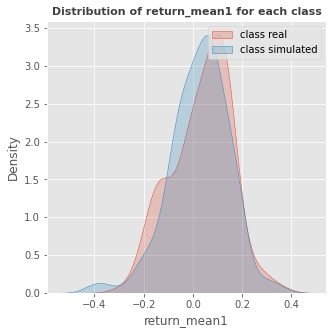

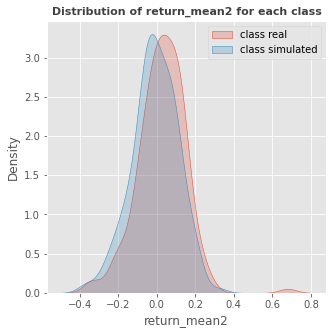

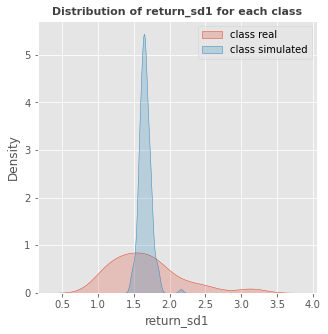

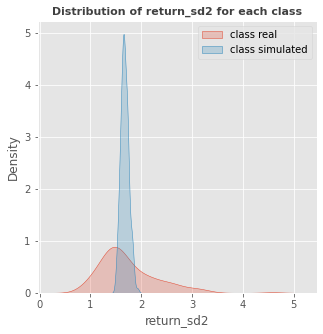

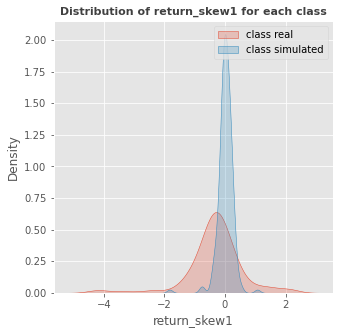

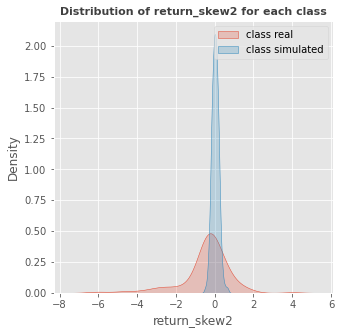

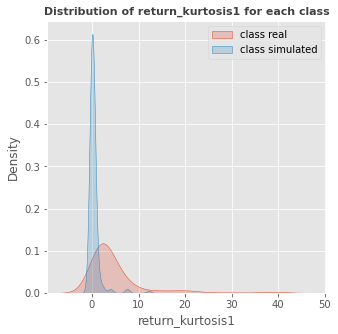

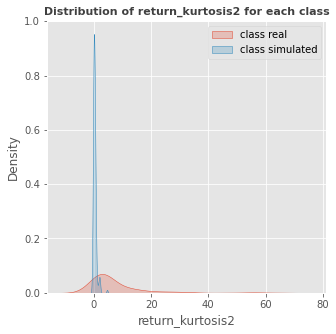

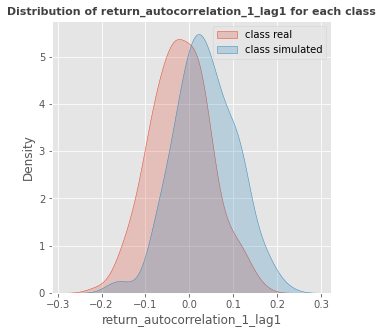

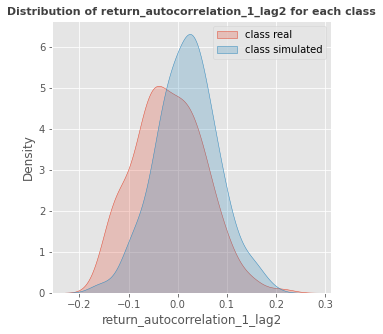

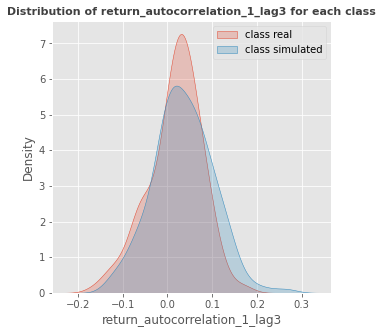

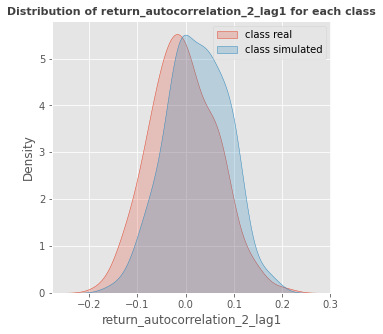

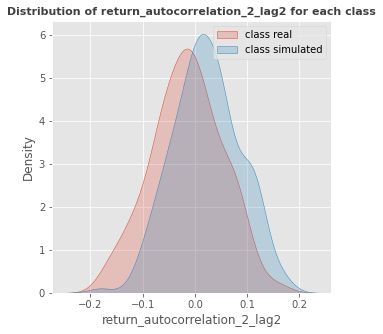

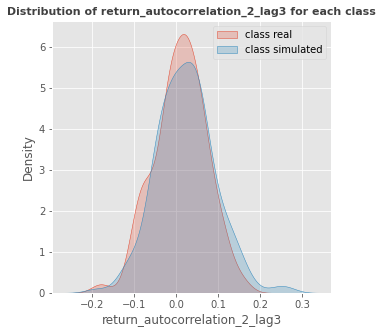

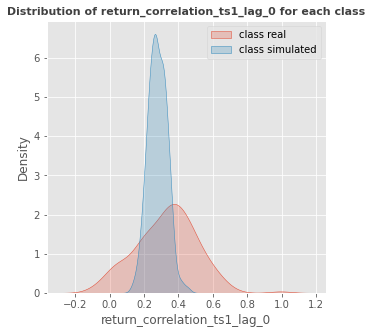

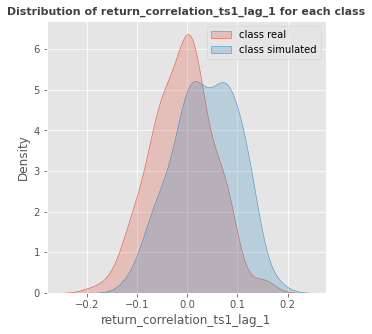

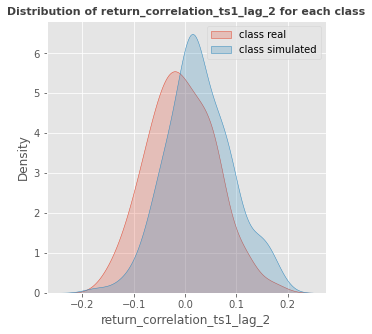

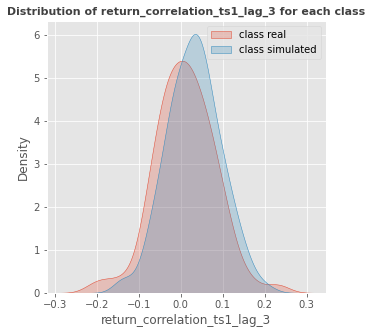

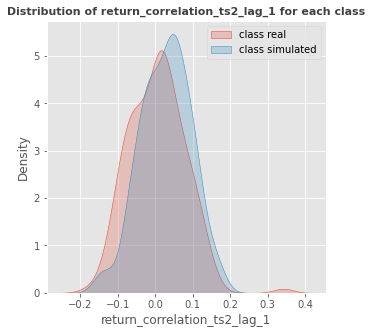

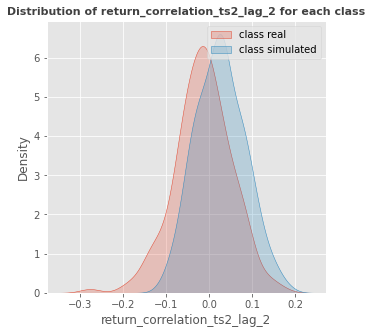

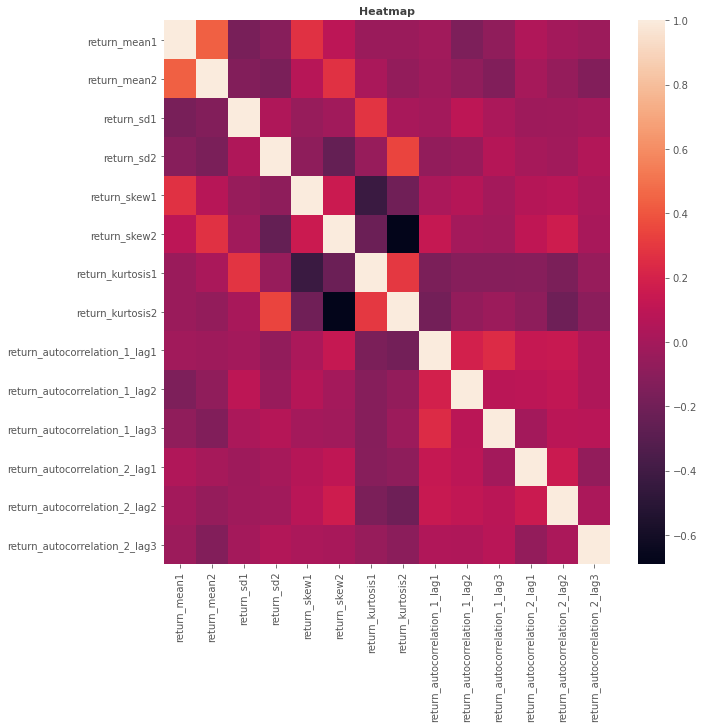

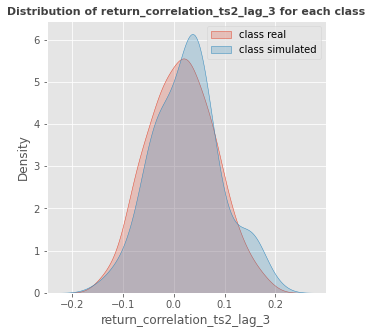

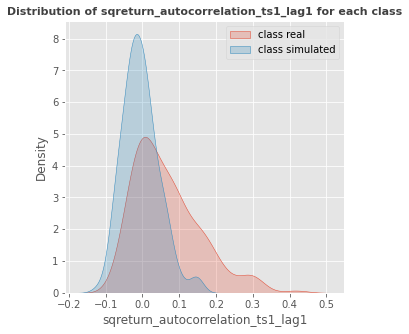

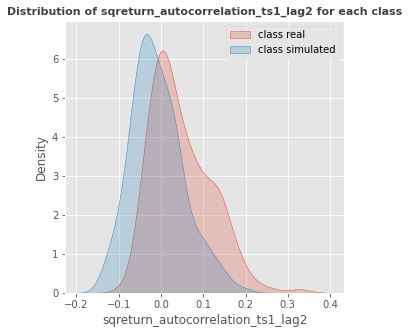

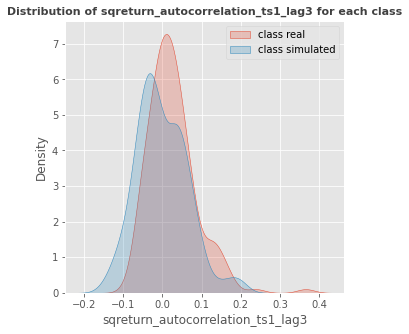

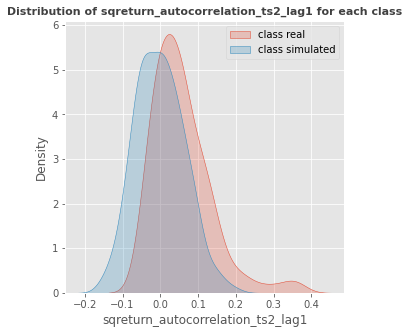

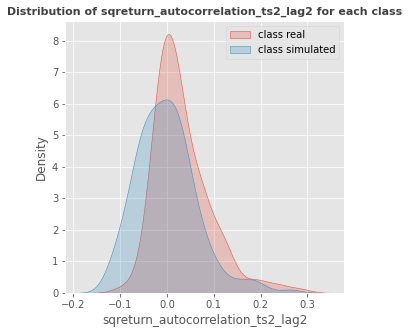

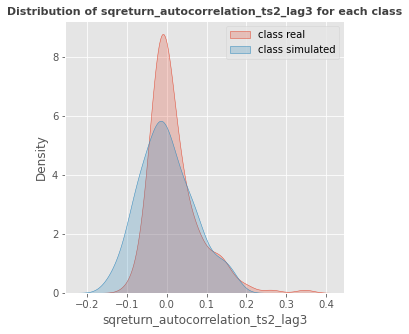

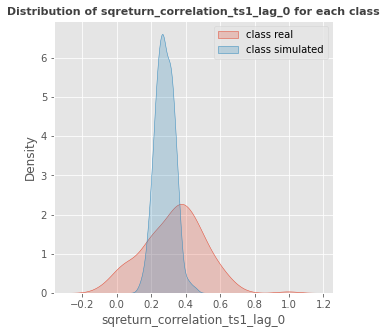

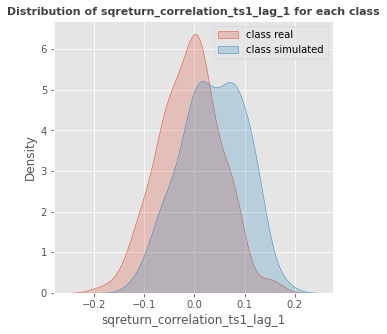

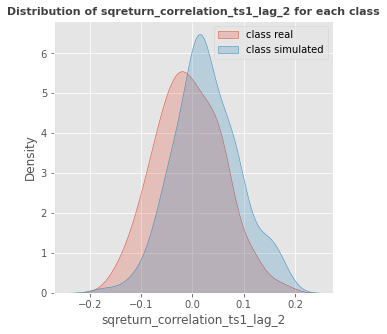

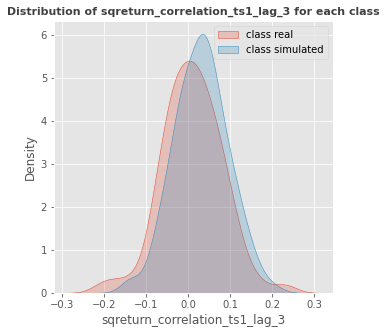

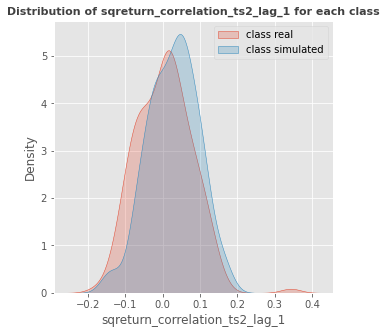

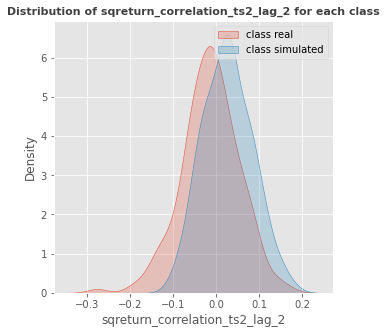

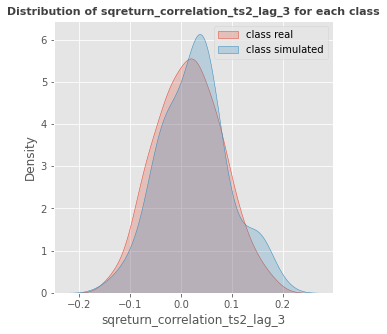

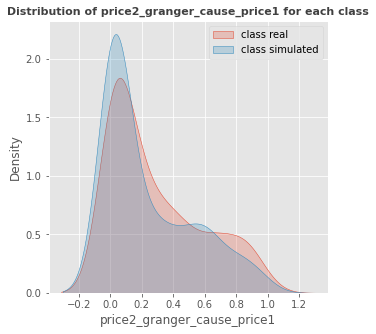

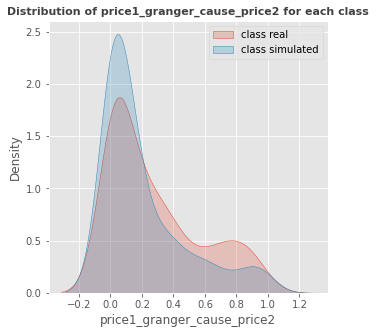

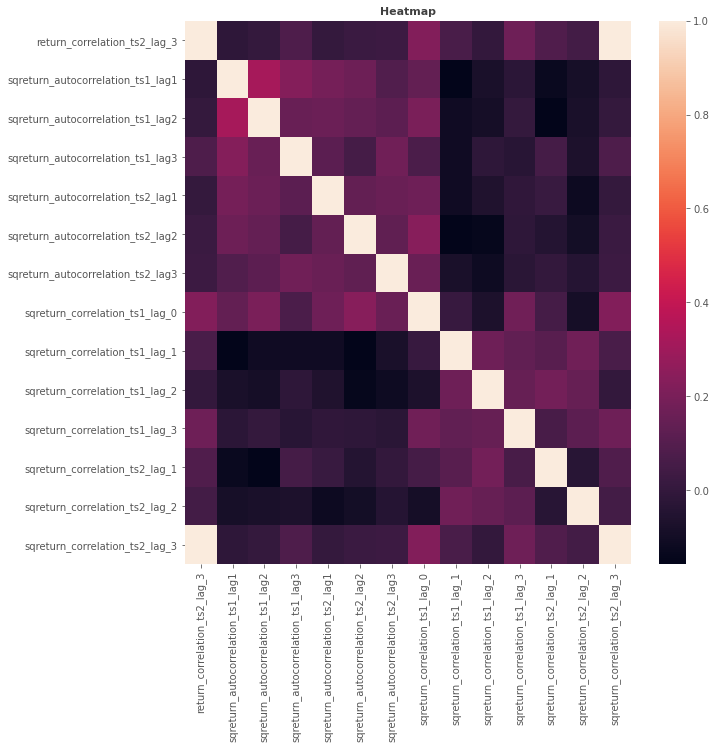

In [5]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")

In [6]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9530201342281879, 0.9395973154362416, 0.959731543624161, 0.9664429530201343, 0.9731543624161074]
0.9583892617449663
0.01154674532488946
